In [3]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric

import warnings
warnings.filterwarnings('ignore')

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [4]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.model_selection import train_test_split



2025-07-23 17:58:12.776006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753286292.870736 1737210 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753286292.935717 1737210 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 17:58:13.176065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)      


In [6]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [7]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")

    elif dataset == "mimic":
        base_cluster_dir = data_path+"data_MIMIC/"+"cluster_csv"
        output_dir = data_path+"data_MIMIC/"+"combined_cluster_data"
        os.makedirs(output_dir, exist_ok=True)
        
        train = pd.DataFrame()
        test = pd.DataFrame()
        for cluster_id in ["0","1","2","3"]:
            cluster_folder = f"cluster_{cluster_id}"
            cluster_path = os.path.join(base_cluster_dir, cluster_folder)
            os.makedirs(output_dir, exist_ok=True)

            if not os.path.isdir(cluster_path):
                print(f"Cluster folder {cluster_folder} not found.")
                return
    
            print(f"Processing {cluster_folder}...")
    
            for file_name in sorted(os.listdir(cluster_path)):
                if not file_name.endswith(".csv"):
                    continue
        
                file_path = os.path.join(cluster_path, file_name)
                df = pd.read_csv(file_path)
        
                subject_id = int(file_name.split("_")[1].replace(".csv", ""))
                df['patient_id'] = subject_id
        
                if len(df) >= 2:
                    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
                else:
                    df_train = df
                    df_test = pd.DataFrame(columns=df.columns)
        
                train = pd.concat([train, df_train], ignore_index=True)
                test = pd.concat([test, df_test], ignore_index=True)
        
            train.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_train.csv"), index=False)
            test.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_test.csv"), index=False)
        
            print(f"Cluster {cluster_id}: Train shape = {train.shape}, Test shape = {test.shape}")
            print(f"Files saved in {output_dir}")

                

In [8]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))
        test, orig_test = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))  # same for now
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg


def load_mimic_data(data_path, cluster_prefix="cluster_", n_clusters=4):
    data = pd.read_csv(data_path + "data_MIMIC/cluste_csv/" + file_name)
    return

In [110]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")
   
    start_value = float(start_value)
    desired_center = float(desired_center)

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    # Compute percent change — safe against zero-division
    denom = start_value if abs(start_value) > 1e-8 else 1e-8
    change_percent = (desired_center - start_value) / denom
    change_percent = float(change_percent)

    #change_percent = (desired_center - start_value) / start_value
    #change_percent = float(change_percent)
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [10]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
parser.add_argument( "--cluster", type=int, default=0, help="Choose cluster for MIMIC data, default 0")

# Parse the arguments from a string
#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper --cluster 0".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
#print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated":
    CHANGE_COLS = [1, 2]
elif args.dataset == "mimic": #??? more
    CHANGE_COLS = [1, 2, 3, 4]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    exog_cols=CHANGE_COLS,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)

# Define N-BEATS Block
class NBeatsBlock(layers.Layer):
    def __init__(self, units, horizon, n_in_features, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
        self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        backcast = self.backcast(x)
        forecast = self.forecast(x)
        return forecast

def build_nbeats_model(back_horizon, n_in_features, horizon, units=128):
    inputs = keras.Input(shape=(back_horizon, n_in_features))
    x = layers.Flatten()(inputs)  # Flatten time series input

    # Stack multiple N-BEATS blocks
    x = NBeatsBlock(units, horizon, n_in_features)(x)
    x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape

    model = keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
    return model

print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_target, dataset.X_train_exog), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_target, dataset.X_test_exog), axis=-1)
y_test = dataset.Y_test
X_val = np.concatenate((dataset.X_val_target, dataset.X_val_exog), axis=-1)
y_val = dataset.Y_val
print("Test", X_train, y_train)
exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_out_features = 1
n_exog_features = exog_train.shape[2]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
#if args.forecast_model == "gru":
forecast_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
    tf.keras.layers.GRU(100, activation="tanh", return_sequences=True), #200 testen
    tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
    tf.keras.layers.Reshape((horizon, n_in_features))
])

forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
#tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])


pred_all_GRU = forecast_GRU.predict(X_test)

#elif args.forecast_model == "nbeatsx":
forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
pred_all_NBEATS = forecast_NBEATS.predict(X_test)




DATA         patient_id                 Time         CGM  CHO   insulin
0                1  2024-11-04 00:00:00  152.181739  0.0  0.021125
1                1  2024-11-04 00:01:00  148.738794  0.0  0.021125
2                1  2024-11-04 00:02:00  147.236110  0.0  0.021125
3                1  2024-11-04 00:03:00  145.871758  0.0  0.021125
4                1  2024-11-04 00:04:00  144.640092  0.0  0.021125
...            ...                  ...         ...  ...       ...
322555          10  2024-11-26 09:31:00  191.613499  0.0  0.016975
322556          10  2024-11-26 09:32:00  190.693856  0.0  0.016975
322557          10  2024-11-26 09:33:00  189.870031  0.0  0.016975
322558          10  2024-11-26 09:34:00  189.135712  0.0  0.016975
322559          10  2024-11-26 09:35:00  188.485040  0.0  0.016975

[322560 rows x 5 columns]
DATA        patient_id                 Time         CGM  CHO   insulin
0               1  2024-11-26 09:36:00  133.342616  0.0  0.021125
1               1  2024-11-

2025-07-23 17:58:42.676126: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/200


2025-07-23 17:58:43.628432: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


402/403 [============================>.] - ETA: 0s - loss: 0.0895

2025-07-23 17:59:10.750145: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


403/403 [==============================] - 30s 66ms/step - loss: 0.0894 - val_loss: 0.0297
Epoch 2/200
403/403 [==============================] - 22s 55ms/step - loss: 0.0264 - val_loss: 0.0237
Epoch 3/200
403/403 [==============================] - 21s 51ms/step - loss: 0.0214 - val_loss: 0.0198
Epoch 4/200
403/403 [==============================] - 20s 50ms/step - loss: 0.0182 - val_loss: 0.0161
Epoch 5/200
403/403 [==============================] - 20s 49ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 6/200
403/403 [==============================] - 20s 50ms/step - loss: 0.0143 - val_loss: 0.0129
Epoch 7/200
403/403 [==============================] - 20s 50ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 8/200
403/403 [==============================] - 21s 51ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 9/200
403/403 [==============================] - 20s 50ms/step - loss: 0.0125 - val_loss: 0.0118
Epoch 10/200
403/403 [==============================] - 20s 50ms/step - loss: 0.0122 

2025-07-23 18:08:55.081657: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


251/251 [==============================] - 4s 12ms/step
Epoch 1/200
387/403 [===========================>..] - ETA: 0s - loss: 0.0755

2025-07-23 18:09:01.126705: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


403/403 [==============================] - 2s 3ms/step - loss: 0.0735 - val_loss: 0.0242
Epoch 2/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0185
Epoch 3/200
403/403 [==============================] - 1s 4ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 4/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0173 - val_loss: 0.0162
Epoch 5/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 6/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0143
Epoch 7/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0153 - val_loss: 0.0166
Epoch 8/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0156
Epoch 9/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 10/200
403/403 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0124
E

2025-07-23 18:09:47.198230: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


251/251 [==============================] - 0s 1ms/step


TESTTESTESTESTESTEST: (8020, 10, 3) (8020, 10, 3)
gru model trained, with test sMAPE score 1.3553; test RMSE score: 2.6850.
nbeats model trained, with test sMAPE score 1.6341; test RMSE score: 3.3088.
TEST (8020, 10) (8020, 10)


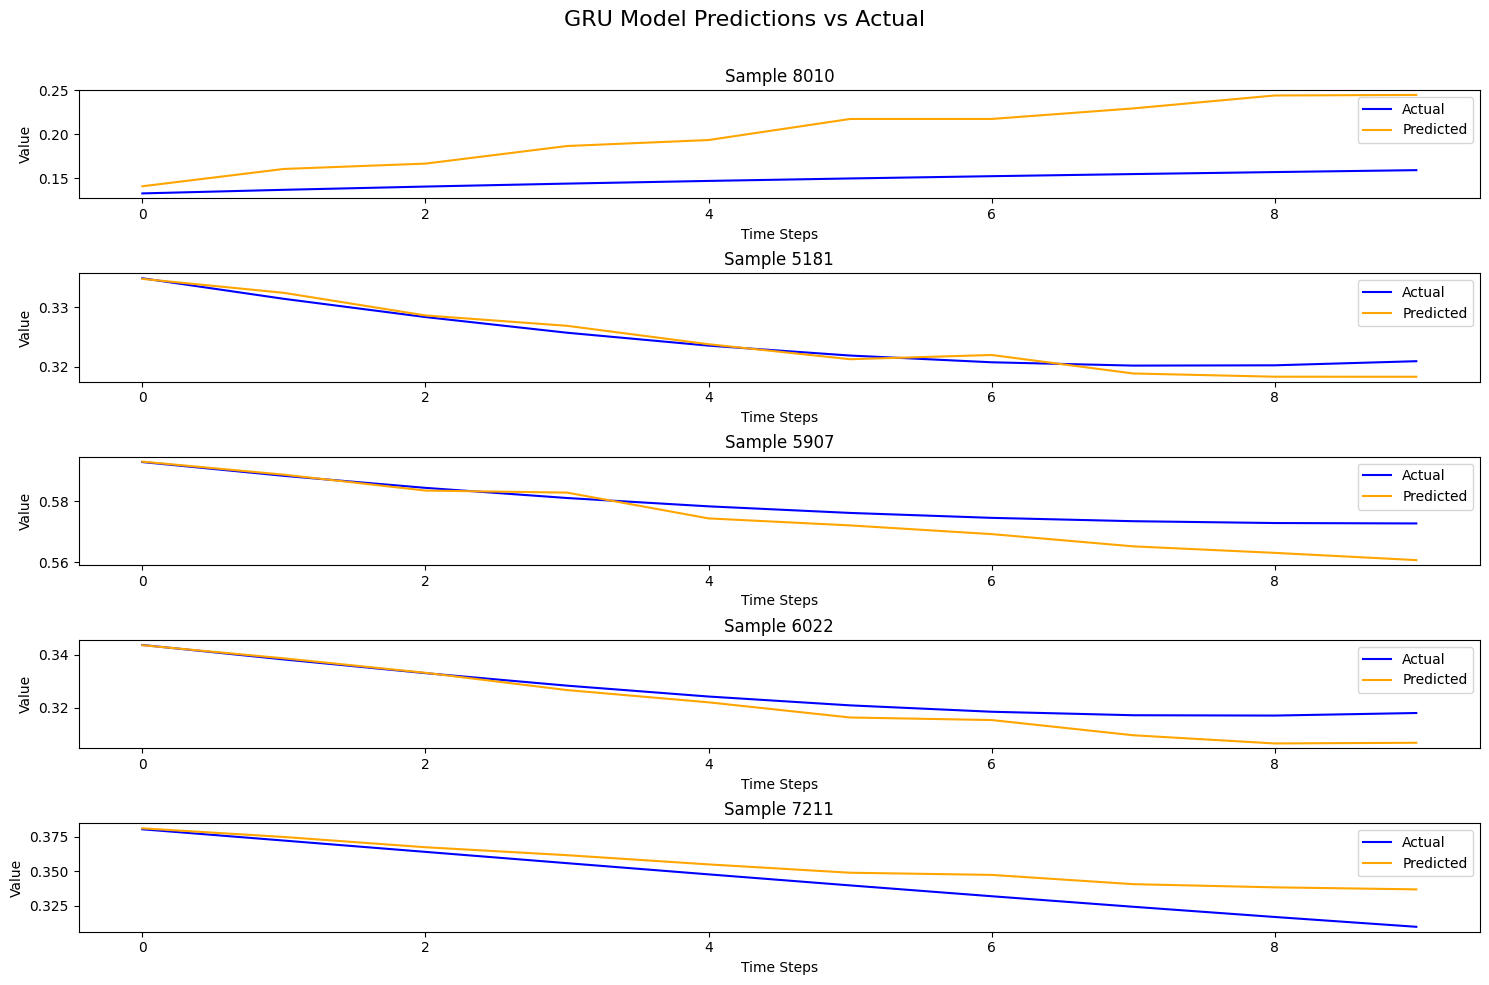

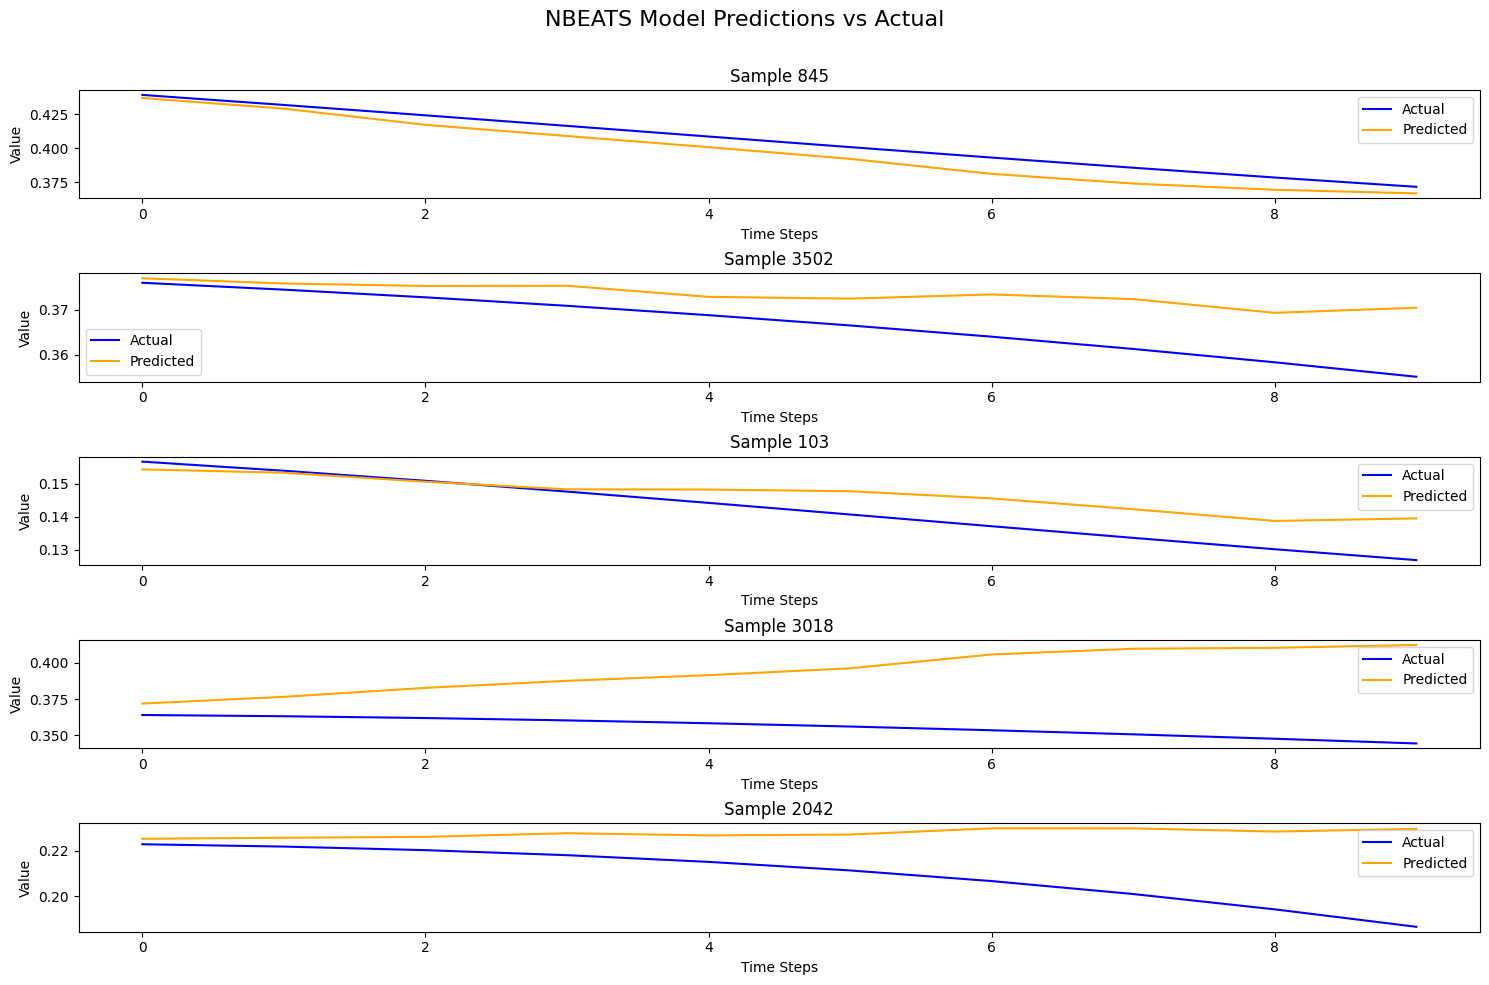

In [11]:
print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]
#pred_tf_tft = pred_all_TFT[:,:,0]
#pred_tf_tft = tf.convert_to_tensor(pred_tf_tft, dtype=tf.float32)
#pred_exog_tft = pred_all_TFT[:,:,1:]
#pred_tf_nbeatsx = pred_all_NBEATSx[:,:,0]
#pred_tf_nbeatsx = tf.convert_to_tensor(pred_tf_nbeatsx, dtype=tf.float32)
#pred_exog_nbeatsx = pred_all_NBEATSx[:,:,1:]

#print(dataset.X_test_exog.shape[0], dataset.Y_test, pred_tf)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_tft)
#print(
#    f"tft model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeatsx)
#print(
#    f"nbeatsx model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()

# Assuming you have your predictions and actual values
# pred_tf is the output from your model
# dataset.Y_test is the actual target values
# Reshape predictions if necessary
pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_tft = pred_tf_tft.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_nbeatsx = pred_tf_nbeatsx.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
# Call the plotting function
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_tft, "tft", title='TFT Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeatsx, "nbeatsx", title='NBEATSx Model Predictions vs Actual')

#for i in range(dataset.X_test_exog.shape[0]):
#print(pred_tf)

In [12]:
def get_dataset_bounds_and_scaler(args, dataset):
    """Automatically configure bounds and fetch appropriate scalers."""
    if args.dataset == "ohiot1dm":
        hyper_bound, hypo_bound = 180, 70
        exog_labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
    elif args.dataset == "simulated" or args.dataset == "simglucose":
        hyper_bound, hypo_bound = 150, 80
        exog_labels = ["carbohydrates", "insulin"]
    else:
        raise ValueError(f"Unknown dataset: {args.dataset}")

    print(f"Configured bounds — Hyper: {hyper_bound}, Hypo: {hypo_bound}")

    return hyper_bound, hypo_bound, exog_labels


def get_scaler_for_sample(dataset, sample_idx, use_reg_idx=True):
    """Fetch scaler for a sample, supporting both reg_idx and direct indexing."""
    if use_reg_idx and hasattr(dataset, "reg_idxs"):
        scaler_idx = dataset.reg_idxs[sample_idx]
    else:
        scaler_idx = sample_idx
    scaler = dataset.scaler[scaler_idx]
    return scaler


In [111]:
pred_all = pred_all_GRU
pred_tf = pred_tf_gru
pred_exog = pred_exog_gru
hyper_bound, hypo_bound = 180, 70
print(f"===========CF generation setup=============")
print(f"hyper bound value: {hyper_bound}, hypo bound: {hypo_bound}.")

#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
event_labels = list()
for i in range(len(pred_tf)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(tf.reshape(pred_tf[i], (1, -1)).numpy())
    if np.any(Y_preds_original >= hyper_bound):
        event_labels.append("hyper")
    elif np.any(Y_preds_original <= hypo_bound):
        event_labels.append("hypo")
    else:
        event_labels.append("normal")
hyper_indices = np.argwhere(np.array(event_labels) == "hyper").reshape(-1)
hypo_indices = np.argwhere(np.array(event_labels) == "hypo").reshape(-1)

print(f"hyper_indices shape: {hyper_indices.shape}")
print(f"hypo_indices shape: {hypo_indices.shape}")

print("LSASLSLKDGNS", Y_preds_original)
#plot(orig_train, orig_test, Y_preds_original)
args.dataset = "simulated"
# use a subset of the test
rand_test_size = 100
print(args.test_group)
if args.test_group == "hyper":
    if len(hyper_indices) >= rand_test_size:
        print("if", hyper_indices)
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hyper_indices, rand_test_size, replace=False
        )
    else:
        print("else", hyper_indices)
        rand_test_idx = hyper_indices
elif args.test_group == "hypo":
    if len(hypo_indices) >= rand_test_size:
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hypo_indices, rand_test_size, replace=False
        )
    else:
        rand_test_idx = hypo_indices
else:
    rand_test_idx = np.arange(dataset.X_reg_exog.shape[0])
    
pred_tf = pred_tf.numpy() if tf.is_tensor(pred_tf) else pred_tf
pred_exog = pred_exog.numpy() if tf.is_tensor(pred_exog) else pred_exog

#Exog_test = pred_exog[rand_test_idx]#dataset.X_test_exog[rand_test_idx]
#Target_test = pred_tf[rand_test_idx]#dataset.X_test_target[rand_test_idx]

#Target_test_C = np.expand_dims(Target_test, axis=-1)
#X_test = np.concatenate((Target_test_C, Exog_test), axis=-1)

#X_test = np.concatenate((Target_test, Exog_test), axis=-1)
#print("ET", Exog_test, Target_test)

Exog_test = dataset.X_reg_exog[rand_test_idx]
Target_test = dataset.X_reg_target[rand_test_idx]
print(Target_test.shape, Target_test)
print(
    f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group..."
)

# loss calculation ==> min/max bounds
desired_max_lst, desired_min_lst = list(), list()
hist_inputs = list()

# define the desired center to reach in two hours (24 timesteps for OhioT1DM)
# then we need to cut the first 6 steps to generate the desired bounds
if args.dataset == "ohiot1dm":
    hyper_bound, hypo_bound = 180, 70
    desired_steps = 24
elif args.dataset == "simulated":
    hyper_bound, hypo_bound = 160, 80
    desired_steps = 20
else:
    hyper_bound, hypo_bound = 180, 70
    desired_steps = 20

if args.test_group == "hyper":
    desired_center_2h = hyper_bound - 10  # -10 for a fluctuating bound
elif args.test_group == "hypo":
    print("here")
    desired_center_2h = hypo_bound + 10  # +10 for a fluctuating bound
else:
    print(
        f"Group not identified: {args.test_group}, use a default center"
    )
    desired_center_2h = (hyper_bound + hypo_bound) / 2
#print(f"desired center {desired_center_2h} in {desired_steps} timesteps.")
print("LEN", len(X_test))
for i in range(len(Exog_test)):#len(X_test)): #???Maybe join exog, target
    
    #scaler = get_scaler_for_sample(dataset, rand_test_idx[i])
    idx = dataset.reg_idxs[rand_test_idx[i]]
    scaler = dataset.scaler[idx]

    desired_center_scaled = scaler[TARGET_COL].transform(
        np.array(desired_center_2h).reshape(-1, 1)
    )[0][0]
    #print("TESSSSST",i,  Target_test[i], X_test[i, :, TARGET_COL])
    #print(
    #    f"desired_center: {desired_center_2h}; after scaling: {desirdesried_center_scaled:0.4f}"
    #)
    # desired trend bounds: use the `center` parameter from the input sequence as the starting point
    desired_max_scaled, desired_min_scaled = generate_bounds(
        center=center,  # Use the parameters defined at the beginning of the script
        shift=desired_shift,
        desired_center=desired_center_scaled,
        poly_order=poly_order,
        horizon=horizon,
        fraction_std=fraction_std,
        input_series=Target_test[i, :],#X_test[i, :, TARGET_COL],#np.transpose(Target_test[i,0]),
        desired_steps=desired_steps,
    )
    print("max", desired_max_scaled)
    # TODO: remove the ones that already satisfy the bounds here, OR afterwards?
    desired_max_lst.append(desired_max_scaled)
    desired_min_lst.append(desired_min_scaled)
    hist_inputs.append(dataset.historical_values[idx])
    

===========CF generation setup=============
hyper bound value: 180, hypo bound: 70.
hyper_indices shape: (304,)
hypo_indices shape: (366,)
LSASLSLKDGNS [[119.36115  119.41434  119.29113  118.96213  119.05151  118.866264
  118.880615 118.45509  118.28185  118.47748 ]]
hypo
(100, 10, 1) [[[ 5.11295932e-02]
  [ 5.32557766e-02]
  [ 5.69532687e-02]
  [ 6.23208364e-02]
  [ 6.93078306e-02]
  [ 7.78284893e-02]
  [ 8.77989938e-02]
  [ 9.91324436e-02]
  [ 1.11735475e-01]
  [ 1.25505979e-01]]

 [[ 1.27866248e-01]
  [ 1.34546598e-01]
  [ 1.41509458e-01]
  [ 1.48719922e-01]
  [ 1.56143084e-01]
  [ 1.63744039e-01]
  [ 1.71487882e-01]
  [ 1.79339708e-01]
  [ 1.87264611e-01]
  [ 1.95227686e-01]]

 [[ 1.27421341e-01]
  [ 1.24977607e-01]
  [ 1.22264855e-01]
  [ 1.10337645e-01]
  [ 1.00548698e-01]
  [ 9.27757501e-02]
  [ 8.68965368e-02]
  [ 8.27887932e-02]
  [ 8.03302548e-02]
  [ 7.93986570e-02]]

 [[ 3.00445606e-02]
  [ 3.48457997e-02]
  [ 3.95965088e-02]
  [ 4.42307879e-02]
  [ 4.86827375e-02]
  [ 5.28

In [75]:
import numpy as np

class SimpleBaseline:
    def __init__(self, dataset, back_horizon, horizon, target_col):
        self.dataset = dataset
        self.back_horizon = back_horizon
        self.horizon = horizon
        self.target_col = target_col
    
    def predict(self):
        num_samples = self.dataset.X_reg_target.shape[0]
        preds = np.empty((num_samples, self.horizon))
        
        for i in range(num_samples):
            # Using the last back_horizon values as history
            history = self.dataset.X_reg_target[i, -self.back_horizon:, self.target_col]
            mean_value = np.mean(history)
            preds[i] = np.full(self.horizon, mean_value)
        
        return preds


In [76]:
baseline = SimpleBaseline(dataset, back_horizon=10, horizon=5, target_col=0)
baseline_predictions = baseline.predict()

print("Baseline predictions shape:", baseline_predictions.shape)
print(baseline_predictions[0])  # Inspect first prediction


Baseline predictions shape: (8020, 5)
[0.34976066 0.34976066 0.34976066 0.34976066 0.34976066]


In [112]:
import numpy as np
import tensorflow as tf
import statsmodels.api as sm
def get_meal_weights(sample, activity_threshold=0):
    # for all the variables in x_sample => 0 - weights for all positive values (i.e., larger than the threshold); more effective for bolus insulin and carbs intake

    # custom_step_weights has the same dimension as all the input variables (index needed);
    # but then only the weights for `z_change_idx` will be called
    custom_step_weights = (
        np.asarray(sample <= activity_threshold, dtype=np.float32) * 1
    )
    return custom_step_weights
    
class TimeSeriesOptimizer:
    def __init__(self, method, dataset, pred_exog, desired_max_lst, desired_min_lst, pred_tf, rand_test_idx, back_horizon, horizon, target_col, change_cols, clip_ranges, hist_inputs, step_weights='meal'):
        self.method = method  # 'sarimax', 'ols', 'gru', or 'nbeats'
        self.dataset = dataset
        self.pred_exog = pred_exog
        self.desired_max_lst = desired_max_lst
        self.desired_min_lst = desired_min_lst
        self.pred_tf = pred_tf
        self.rand_test_idx = rand_test_idx
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.TARGET_COL = target_col
        self.CHANGE_COLS = change_cols #for sim change_cols
        self.learning_rate = 0.001
        
        self.pred_margin_weight = 1.0#pred_margin_weight
        self.weighted_steps_weight = 1 - self.pred_margin_weight
        
        self.MISSING_MAX_BOUND = np.inf
        self.MISSING_MIN_BOUND = -np.inf

        self.clip_range_inputs = clip_ranges
        self.hist_value_inputs = hist_inputs
        self.step_weights = step_weights
        
        self.targets = None
        self.orig_targets = None
        self.transformed_targets = None
        self.transformed_orig_targets = None
        self.transformed_exogs = None
        self.transformed_orig_exogs = None
        self.orig_exogs = None
        self.exogs = None
        self.losses = None
        self.model = None
        self.optimizer = None

        self._init_method()

    def _init_method(self):
        if self.method == 'sarimax':
            # No pretraining here, SARIMAX models trained per sample
            pass
        elif self.method == 'ols':
            # Similarly, OLS models trained per sample
            pass
        elif self.method == 'gru':
            self._init_gru_model()
        elif self.method == 'nbeats':
            self._init_nbeats_model()
        else:
            raise ValueError(f"Unknown method: {self.method}")

    def _init_gru_model(self):
        X = self.dataset.X_reg_exog
        y = self.dataset.X_reg_target[:, self.TARGET_COL]
        X_val = self.dataset.X_reg_val_exog
        y_val = self.dataset.X_reg_val_target[:, self.TARGET_COL]

        in_features = X.shape[2]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.horizon, in_features)),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=True),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=False),
            tf.keras.layers.Dense(self.horizon, activation='linear'),
            tf.keras.layers.Reshape((self.horizon, 1))
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate,  epsilon=1e-07)
        self.model.compile(optimizer=self.optimizer, loss='mae')
        self.model.fit(X, y, epochs=200, batch_size=64,
                       validation_data=(X_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)])

    def _init_nbeats_model(self):
        #back_horizon = self.back_horizon
        horizon = self.horizon
        #n_features = self.dataset.X_reg_exog.shape[2]

        class NBeatsBlock(tf.keras.layers.Layer):
            def __init__(self, units, horizon):
                super().__init__()
                self.fc1 = tf.keras.layers.Dense(units, activation='relu')
                self.fc2 = tf.keras.layers.Dense(units, activation='relu')
                self.fc3 = tf.keras.layers.Dense(units, activation='relu')
                self.fc4 = tf.keras.layers.Dense(units, activation='relu')
                self.forecast = tf.keras.layers.Dense(horizon)

            def call(self, inputs):
                x = self.fc1(inputs)
                x = self.fc2(x)
                x = self.fc3(x)
                x = self.fc4(x)
                return self.forecast(x)

        class DifferentiableNBeats(tf.keras.Model):
            def __init__(self, horizon, units=128):
                super().__init__()
                self.flatten = tf.keras.layers.Flatten()
                self.block = NBeatsBlock(units, horizon)

            def call(self, x):
                x = self.flatten(x)
                return self.block(x)

        self.model = DifferentiableNBeats(horizon=self.horizon, units=128)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mae')

        # Optionally fit here if you have X_train, y_train, etc.

    def margin_mse(self, max_bound, min_bound, pred):
         mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
         return mse(max_bound, pred) + mse(min_bound, pred)


    def weighted_ape(self, original_per_feature, cf_per_feature, step_weights):
        denum = tf.math.maximum(tf.math.abs(original_per_feature), tf.keras.backend.epsilon())
        ape_score = tf.math.abs(original_per_feature - cf_per_feature) / denum
        weighted_ape = tf.math.multiply(ape_score, step_weights)
        return tf.reduce_mean(weighted_ape)
    
    def compute_loss(self, original_sample, exog_search, step_weights, max_bound, min_bound, n_iter=None):
        loss = tf.zeros(shape=())
        if self.method == 'gru' or self.method == 'nbeats':
            pred = self.model(exog_search)
        elif self.method == 'sarimax':
            temp = exog_search.numpy()
            pred = self.model.forecast(self.horizon, start_params=self.model.params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred
        elif self.method == 'ols':
            temp = exog_search.numpy()
            pred = self.model.predict(temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred
            
        forecast_margin_loss = self.margin_mse(pred, max_bound, min_bound)
        loss += tf.cast(self.pred_margin_weight, tf.float32) * tf.cast(forecast_margin_loss, tf.float32)

        total_weighted_steps_loss = tf.zeros_like(loss)
        for d_idx, col_idx in enumerate(self.CHANGE_COLS):
            w_loss = self.weighted_ape(
                tf.cast(original_sample[:, :, d_idx], tf.float32),
                tf.cast(exog_search[:, :, d_idx], tf.float32),
                tf.cast(step_weights[:, :, d_idx], tf.float32),
            )
            loss += tf.cast(self.weighted_steps_weight, tf.float32) * w_loss
            total_weighted_steps_loss += w_loss
        return loss, forecast_margin_loss, total_weighted_steps_loss

    # def compute_loss(self, max_bound, min_bound, pred):
    #     mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    #     return mse(max_bound, pred) + mse(min_bound, pred)

    def compute_gradient_finite_difference(self, model, X_e, step_weights, max_bound, min_bound, epsilon=1e-4):
        # Used for SARIMAX and OLS only
        original_pred = None
        if self.method == 'sarimax':
            temp = X_e.numpy()
            pred = model.forecast(self.horizon, start_params=model.params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred
        elif self.method == 'ols':
            temp = X_e.numpy()
            pred = model.predict(temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred

        original_loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
            tf.expand_dims(X_e.numpy(), axis=0),     # original_sample
            tf.expand_dims(X_e.numpy(), axis=0),     # z_search (original = current)
            step_weights,  # step_weights
            max_bound,
            min_bound
        )

        gradients = np.zeros_like(X_e.numpy())
        for i in range(X_e.shape[0]):
            X_e_perturbed = X_e.numpy()
            X_e_perturbed[i] += epsilon

            if self.method == 'sarimax':
                pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
            elif self.method == 'ols':
                pred_perturbed = model.predict(X_e_perturbed)
            pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

            perturbed_loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                tf.expand_dims(X_e_perturbed, axis=0),
                tf.expand_dims(X_e_perturbed, axis=0),
                step_weights,
                max_bound,
                min_bound
            )
            gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

        return gradients

    def optimize(self):
        length = len(self.desired_max_lst)
        self.targets = np.empty((length, self.horizon))
        self.orig_targets = np.empty((length, self.horizon))
        self.transformed_targets = np.empty((length, self.horizon))
        self.transformed_orig_targets = np.empty((length, self.horizon))
        self.transformed_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.transformed_orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.losses = np.empty(length)

        for i in range(length):
            max_bound = self.desired_max_lst[i]
            min_bound = self.desired_min_lst[i]
            clip_ranges = self.clip_range_inputs[i] if self.clip_range_inputs else None
            #print(f"clip_ranges:{clip_ranges is not None}")
            hist_values = self.hist_value_inputs[i] if self.hist_value_inputs else None
            #print(f"hist_values:{hist_values is not None}")
            #step_weights = self.step_weights
            if self.step_weights in ["meal", "meal_time"]:
                step_weights = get_meal_weights(self.pred_exog[i])
                
            else:
                step_weights = np.zeros(self.pred_exog[i].shape)
                step_weights = tf.expand_dims(step_weights, axis=0)

            if self.method == 'sarimax':
                self._optimize_sarimax(i, max_bound, min_bound, clip_ranges, hist_values, step_weights)
            elif self.method == 'ols':
                self._optimize_ols(i, max_bound, min_bound, clip_ranges, hist_values, step_weights)
            elif self.method == 'gru':
                self._optimize_gru(i, max_bound, min_bound, clip_ranges, hist_values, step_weights)
            elif self.method == 'nbeats':
                self._optimize_nbeats(i, max_bound, min_bound, clip_ranges, hist_values, step_weights)
            else:
                raise ValueError(f"Unknown method: {self.method}")

    def _optimize_sarimax(self, i, max_bound, min_bound, clip_ranges, hist_values, step_weights):
        # Extract exog and target
        X = self.dataset.X_reg_exog[i]
        y = self.dataset.X_reg_target[i][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[self.rand_test_idx][i]

        if clip_ranges:
            clip_lows = tf.constant([clip[0] for clip in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([clip[1] for clip in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, -1))
            clip_highs = tf.reshape(clip_highs, (1, -1))
            def per_feature_clip(x): return tf.clip_by_value(x, clip_lows, clip_highs)
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32, constraint=per_feature_clip)
        else:
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)

        mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1, 0, 0))
        mod = mod.fit(disp=False)

        self.model = mod
        start_params = mod.params
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        if isinstance(step_weights, np.ndarray):
            step_weights = tf.convert_to_tensor(step_weights, dtype=tf.float32)
        
        # Ensure shape is (1, T, D)
        if step_weights.shape.rank == 1:
            # shape = (D,) → tile across T
            step_weights = tf.reshape(step_weights, (1, 1, -1))
            step_weights = tf.tile(step_weights, [1, self.horizon, 1])
        elif step_weights.shape.rank == 2:
            # shape = (T, D)
            step_weights = tf.expand_dims(step_weights, axis=0)
        elif step_weights.shape.rank == 3:
            # shape is already (1, T, D) or (batch, T, D) — do nothing
            pass
        else:
            raise ValueError(f"Unexpected step_weights shape: {step_weights.shape}")

        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[t, d_idx] - hist_values[feat_idx])
                    val = 1.0 if tf.reduce_min(dist) <= threshold_close else 0.0
                    step_weights = tf.tensor_scatter_nd_update(step_weights, [[0, t, d_idx]], [val])

        pred = mod.forecast(self.horizon, start_params=start_params, exog=grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        it = 0
        max_iter = 100
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e, step_weights, max_bound, min_bound)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
            pred = tf.convert_to_tensor(mod.forecast(self.horizon, start_params=mod.params, exog=grad_X_e.numpy()), dtype=tf.float32)
            it += 1

        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(self.pred_exog[i][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)

        self.targets[i] = pred.numpy().squeeze()
        self.orig_targets[i] = self.pred_tf[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.orig_exogs[i] = self.pred_exog[i]
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = self.compute_loss(
            tf.expand_dims(self.pred_exog[i], axis=0),      # original_sample
            tf.expand_dims(grad_X_e, axis=0),               # z_search
            step_weights,           # step_weights
            max_bound,
            min_bound
        )[0].numpy()

    def _optimize_ols(self, i, max_bound, min_bound, clip_ranges, hist_values, step_weights):
        X = self.dataset.X_reg_exog[i]
        y = self.dataset.X_reg_target[i][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[self.rand_test_idx][i]
        
        if clip_ranges:
            clip_lows = tf.constant([clip[0] for clip in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([clip[1] for clip in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, -1))
            clip_highs = tf.reshape(clip_highs, (1, -1))
            def per_feature_clip(x): return tf.clip_by_value(x, clip_lows, clip_highs)
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32, constraint=per_feature_clip)
        else:
            grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)


        model = sm.OLS(y, X).fit()
        self.model = model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        if isinstance(step_weights, np.ndarray):
            step_weights = tf.convert_to_tensor(step_weights, dtype=tf.float32)
        
        # Ensure shape is (1, T, D)
        if step_weights.shape.rank == 1:
            # shape = (D,) → tile across T
            step_weights = tf.reshape(step_weights, (1, 1, -1))
            step_weights = tf.tile(step_weights, [1, self.horizon, 1])
        elif step_weights.shape.rank == 2:
            # shape = (T, D)
            step_weights = tf.expand_dims(step_weights, axis=0)
        elif step_weights.shape.rank == 3:
            # shape is already (1, T, D) or (batch, T, D) — do nothing
            pass
        else:
            raise ValueError(f"Unexpected step_weights shape: {step_weights.shape}")
            
        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[t, d_idx] - hist_values[feat_idx])
                    val = 1.0 if tf.reduce_min(dist) <= threshold_close else 0.0
                    step_weights = tf.tensor_scatter_nd_update(step_weights, [[0, t, d_idx]], [val])

        pred = model.predict(grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        it = 0
        max_iter = 100

        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            gradients = self.compute_gradient_finite_difference(model, grad_X_e, step_weights, max_bound, min_bound)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = model.predict(grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            it += 1
        pred = model.predict(grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(self.pred_exog[i][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
        
        self.targets[i] = pred.numpy().squeeze()
        self.orig_targets[i] = self.pred_tf[i]
        self.orig_exogs[i] = self.pred_exog[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = self.compute_loss(
            tf.expand_dims(pred_exog_sample, axis=0),
            tf.expand_dims(grad_X_e, axis=0),
            step_weights,
            max_bound,
            min_bound
        )[0].numpy()

    # def _optimize_gru(self, i, max_bound, min_bound, clip_ranges, hist_values):
    #     for dim in range(self.dataset.X_reg_exog.shape[2]):
    #         if clip_ranges:
    #             clip_low, clip_high = clip_ranges[dim]
    #             grad_X_e = tf.Variable(
    #                 self.pred_exog[i],
    #                 dtype=tf.float32,
    #                 constraint=lambda x: tf.clip_by_value(x, clip_low, clip_high)
    #             )
    #         else:
    #             grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)  # shape should be (horizon, n_features)

    #     it = 0
    #     optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    #     max_iter = 100
    
    #     pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]  # (1, horizon, 1) -> (horizon,)
    #     loss = self.compute_loss(max_bound, min_bound, pred)
    
    #     while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
    #         with tf.GradientTape() as tape:
    #             pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]
    #             loss = self.compute_loss(max_bound, min_bound, pred)
    
    #         gradients = tape.gradient(loss, grad_X_e)
    #         optimizer.apply_gradients([(gradients, grad_X_e)])
    
    #         it += 1
    def _optimize_gru(self, i, max_bound, min_bound, clip_ranges, hist_values, step_weights):
        pred_exog_sample = self.pred_exog[self.rand_test_idx][i]  # shape (horizon, n_features)

        if clip_ranges:
            clip_lows = tf.constant([clip[0] for clip in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([clip[1] for clip in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, 1, -1))
            clip_highs = tf.reshape(clip_highs, (1, 1, -1))
            def per_feature_clip(x):
                return tf.clip_by_value(x, clip_lows, clip_highs)
            grad_X_e = tf.Variable(
                pred_exog_sample[None, :, :],
                dtype=tf.float32,
                constraint=per_feature_clip
            )
        else:
            grad_X_e = tf.Variable(pred_exog_sample[None, :, :], dtype=tf.float32)
        #grad_X_e = tf.Variable(pred_exog_sample[None, :, :], dtype=tf.float32)  # shape (1, horizon, features)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        it = 0
        max_iter = 100
        #step_weights = tf.ones((1, self.horizon, len(self.CHANGE_COLS)))  # (1, T, D)
        if isinstance(step_weights, np.ndarray):
            step_weights = tf.convert_to_tensor(step_weights, dtype=tf.float32)
        if len(step_weights.shape) == 2:
            step_weights = tf.expand_dims(step_weights, 0)

        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[0, t, d_idx] - hist_values[feat_idx])
                    if tf.reduce_min(dist) <= threshold_close:
                        step_weights = tf.tensor_scatter_nd_update(
                            step_weights,
                            indices=[[0, t, d_idx]],
                            updates=[1.0]
                        )
                    else:
                        step_weights = tf.tensor_scatter_nd_update(
                            step_weights,
                            indices=[[0, t, d_idx]],
                            updates=[0.0]
                        )
                        
        with tf.GradientTape() as tape:
            tape.watch(grad_X_e)
            pred = self.model(grad_X_e)
            loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                tf.convert_to_tensor(pred_exog_sample[None, :, :], dtype=tf.float32),#pred_exog_sample[None, :, :], dtype=tf.float32),
                grad_X_e,
                step_weights,
                max_bound,
                min_bound
            )
        gradients = tape.gradient(loss, grad_X_e)
        optimizer.apply_gradients([(gradients, grad_X_e)])
    
        # Optimization loop
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and (it < max_iter if max_iter else True):
            with tf.GradientTape() as tape:
                tape.watch(grad_X_e)
                pred = self.model(grad_X_e)
                loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                    tf.convert_to_tensor(pred_exog_sample[None, :, :], dtype=tf.float32),#pred_exog_sample[None, :, :], dtype=tf.float32),
                    grad_X_e,
                    step_weights,
                    max_bound,
                    min_bound
                )
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
            it += 1
            
        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[0, :, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(pred_exog_sample[:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
        
        self.targets[i] = pred.numpy().squeeze()
        self.orig_targets[i] = self.pred_tf[i]
        self.orig_exogs[i] = self.pred_exog[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = loss.numpy()


    def _optimize_nbeats(self, i, max_bound, min_bound, clip_ranges, hist_values, step_weights):
        pred_exog_sample = self.pred_exog[self.rand_test_idx][i]  # shape (horizon, n_features)
        if clip_ranges:
            clip_lows = tf.constant([clip[0] for clip in clip_ranges], dtype=tf.float32)
            clip_highs = tf.constant([clip[1] for clip in clip_ranges], dtype=tf.float32)
            clip_lows = tf.reshape(clip_lows, (1, 1, -1))
            clip_highs = tf.reshape(clip_highs, (1, 1, -1))
            def per_feature_clip(x):
                return tf.clip_by_value(x, clip_lows, clip_highs)
            grad_X_e = tf.Variable(
                pred_exog_sample[None, :, :],
                dtype=tf.float32,
                constraint=per_feature_clip
            )
        else:
            grad_X_e = tf.Variable(pred_exog_sample[None, :, :], dtype=tf.float32)
        
        #grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        it = 0
        max_iter = 100
        if isinstance(step_weights, np.ndarray):
            step_weights = tf.convert_to_tensor(step_weights, dtype=tf.float32)
        if len(step_weights.shape) == 2:
            step_weights = tf.expand_dims(step_weights, 0)
        if hist_values is not None:
            threshold_close = 0.001
            for d_idx, feat_idx in enumerate(self.CHANGE_COLS):
                for t in range(self.horizon):
                    dist = tf.abs(grad_X_e[0, t, d_idx] - hist_values[feat_idx])
                    if tf.reduce_min(dist) <= threshold_close:
                        step_weights = tf.tensor_scatter_nd_update(
                            step_weights,
                            indices=[[0, t, d_idx]],
                            updates=[1.0]
                        )
                    else:
                        step_weights = tf.tensor_scatter_nd_update(
                            step_weights,
                            indices=[[0, t, d_idx]],
                            updates=[0.0]
                        )
        with tf.GradientTape() as tape:
            tape.watch(grad_X_e)
            pred = self.model(grad_X_e)
            loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                tf.convert_to_tensor(pred_exog_sample[None, :, :], dtype=tf.float32),#pred_exog_sample[None, :, :], dtype=tf.float32),
                grad_X_e,
                step_weights,
                max_bound,
                min_bound
            )
        
        gradients = tape.gradient(loss, grad_X_e)
        optimizer.apply_gradients([(gradients, grad_X_e)])

        
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            with tf.GradientTape() as tape:
                tape.watch(grad_X_e)
                pred = self.model(grad_X_e)
                loss, forecast_margin_loss, weighted_steps_loss = self.compute_loss(
                    tf.convert_to_tensor(pred_exog_sample[None, :, :], dtype=tf.float32),#pred_exog_sample[None, :, :], dtype=tf.float32),
                    grad_X_e,
                    step_weights,
                    max_bound,
                    min_bound
                )
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
            it += 1

        
        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[0, :, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(pred_exog_sample[:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_orig_exogs)
        
        self.targets[i] = pred.numpy().squeeze()
        self.orig_targets[i] = self.pred_tf[i]
        self.orig_exogs[i] = self.pred_exog[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = loss.numpy()


In [113]:
#X_test = np.concatenate((Target_test, Exog_test), axis=2)
pred_exog = pred_exog_nbeats#nbeats
clip_ranges = [[[0.0, 1.0]] * len(CHANGE_COLS)] * len(X_test)

In [114]:

opt = TimeSeriesOptimizer(method='gru', dataset=dataset, pred_exog=pred_exog_nbeats, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf_nbeats, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs, step_weights="meal")
opt.optimize()
sim_targets_gru = opt.targets
sim_orig_targets_gru = opt.orig_targets
sim_exogs_gru = opt.exogs
sim_orig_exogs_gru = opt.orig_exogs
sim_losses_gru = opt.losses
sim_transformed_targets_gru = opt.transformed_targets
sim_transformed_exogs_gru = opt.transformed_exogs
sim_transformed_orig_targets_gru = opt.transformed_orig_targets
sim_transformed_orig_exogs_gru = opt.transformed_orig_exogs

Epoch 1/200


2025-07-25 14:23:37.630571: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


124/126 [============================>.] - ETA: 0s - loss: 0.1564

2025-07-25 14:23:43.083716: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


126/126 [==============================] - 7s 27ms/step - loss: 0.1560 - val_loss: 0.1381
Epoch 2/200
126/126 [==============================] - 3s 22ms/step - loss: 0.1393 - val_loss: 0.1383
Epoch 3/200
126/126 [==============================] - 3s 24ms/step - loss: 0.1408 - val_loss: 0.1386
Epoch 4/200
126/126 [==============================] - 3s 24ms/step - loss: 0.1396 - val_loss: 0.1381
Epoch 5/200
126/126 [==============================] - 3s 23ms/step - loss: 0.1385 - val_loss: 0.1381
Epoch 6/200
126/126 [==============================] - 2s 20ms/step - loss: 0.1394 - val_loss: 0.1382
Epoch 7/200
126/126 [==============================] - 3s 21ms/step - loss: 0.1390 - val_loss: 0.1387
Epoch 8/200
126/126 [==============================] - 2s 20ms/step - loss: 0.1388 - val_loss: 0.1386
Epoch 9/200
126/126 [==============================] - 3s 20ms/step - loss: 0.1390 - val_loss: 0.1381
Epoch 10/200
126/126 [==============================] - 3s 22ms/step - loss: 0.1390 - val_loss

In [92]:
zipped = zip(sim_targets_gru, sim_orig_targets_gru, sim_exogs_gru, sim_orig_exogs_gru, sim_losses_gru, sim_transformed_targets_gru, sim_transformed_exogs_gru, sim_transformed_orig_targets_gru, sim_transformed_orig_exogs_gru)
np.savez('sim.csv', zipped)

In [95]:
import numpy as np

# Load the saved zip file
ohio_data = np.load("ohio.csv/arr_0_ohio.npy", allow_pickle=True)
unzipped_ohio = list(ohio_data.item())

# Unzip and convert to arrays
ohio_targets_gru, ohio_orig_targets_gru, ohio_exogs_gru, ohio_orig_exogs_gru, \
ohio_losses_gru, ohio_transformed_targets_gru, ohio_transformed_exogs_gru, \
ohio_transformed_orig_targets_gru, ohio_transformed_orig_exogs_gru = map(np.array, zip(*unzipped_ohio))

# Load the saved zip file
simu_data = np.load("sim.csv/arr_0_sim.npy", allow_pickle=True)
unzipped_simu = list(simu_data.item())

# Unzip and convert to arrays
simu_targets_gru, simu_orig_targets_gru, simu_exogs_gru, simu_orig_exogs_gru, \
simu_losses_gru, simu_transformed_targets_gru, simu_transformed_exogs_gru, \
simu_transformed_orig_targets_gru, simu_transformed_orig_exogs_gru = map(np.array, zip(*unzipped_simu))


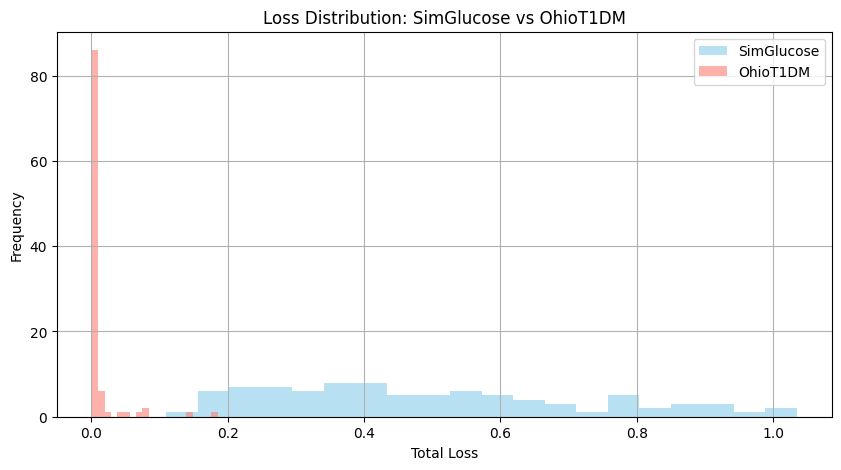

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(simu_losses_gru, bins=20, alpha=0.6, label='SimGlucose', color='skyblue')
plt.hist(ohio_losses_gru, bins=20, alpha=0.6, label='OhioT1DM', color='salmon')
plt.title("Loss Distribution: SimGlucose vs OhioT1DM")
plt.xlabel("Total Loss")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [102]:
delta_sim = (simu_transformed_targets_gru - simu_transformed_orig_targets_gru).mean(axis=1)
print(delta_sim)

[  0.26729355   0.18515396  -0.99143372   2.04672852  -3.27985916
  -9.95841446 -12.64636078 -10.28283386 -19.72820282 -25.37726822
 -16.77185135 -24.14504013 -37.04596863 -37.43827972 -28.05924683
 -19.93960495 -23.46476364 -29.53580093 -42.6179924  -43.78376312
 -39.98750839 -40.03270493 -45.40546188 -47.44122009 -45.40740356
 -46.8864502  -49.20609436 -60.5317627  -54.87821884 -50.77753601
 -39.1696373  -39.16787186 -54.67253265 -54.53777313 -53.09397736
 -34.58311539 -37.03142395 -37.72662506 -28.89418488 -21.92140045
 -23.01150436  -1.77220993  -7.60374374   1.80268173   1.24979401
   3.25428162   6.0300705    7.63186493 -15.16084366 -32.41856079
 -42.92038803 -54.63487854 -64.69567871 -70.74338303 -64.54353561
 -38.27232513 -45.04539948 -24.35357437 -21.01986237 -13.93083725
  -9.90333557 -13.78347473 -16.71332397 -11.35937805 -14.3507019
 -28.06032944 -14.69571381  -5.90250092  -1.29233475  -9.25515594
  -8.6788681   -9.69565964 -15.93062286 -16.71329498   0.40909042
   8.011223

In [103]:
delta_ohio = (ohio_transformed_targets_gru - ohio_transformed_orig_targets_gru).mean(axis=1)
print(delta_ohio)

[  81.61194738    2.24598312    9.28799438   68.51760737   77.22959073
  201.477211     86.45382945  -13.11080043    8.75122706  112.16854604
   36.11552429   41.06740824   27.45391973   55.62087377   15.53507996
  -21.25172424  -20.65450541  -32.77886963   -4.94534047    2.82062276
   25.9650116    62.26423899   98.67490641   93.22702154   27.68439611
  125.34850947   47.925162     63.22689438   77.46377945   53.270696
   77.2414945   135.8898557   139.63650258   50.97484589   29.79897181
   -8.32757187   29.42070516   34.98702367   24.95060094  -19.57158915
  -33.36215719  -36.67897797   -2.34536489   14.70379003   21.5700086
   13.5477918    -3.22785823   58.47233327   30.48787562   86.06665421
   73.78689575  -12.38407008    5.04409281    8.69974772  -71.03643799
 -106.26717504 -155.65886052  -85.57618459  -62.80430603   63.6876653
  165.87878799  157.49920781   24.29860942  101.58894602   49.67929395
   29.21441905   14.53046417   -9.84223429  -23.12391663   38.15789922
   -4.6603

In [104]:
print("Mean Δ SimGlucose:", delta_sim.mean())
print("Std Δ SimGlucose:", delta_sim.std())
print("Mean Δ OhioT1DM:", delta_ohio.mean())
print("Std Δ OhioT1DM:", delta_ohio.std())


Mean Δ SimGlucose: -10.255283596038817
Std Δ SimGlucose: 32.72329764398774
Mean Δ OhioT1DM: 30.595795160929367
Std Δ OhioT1DM: 58.33774215107951


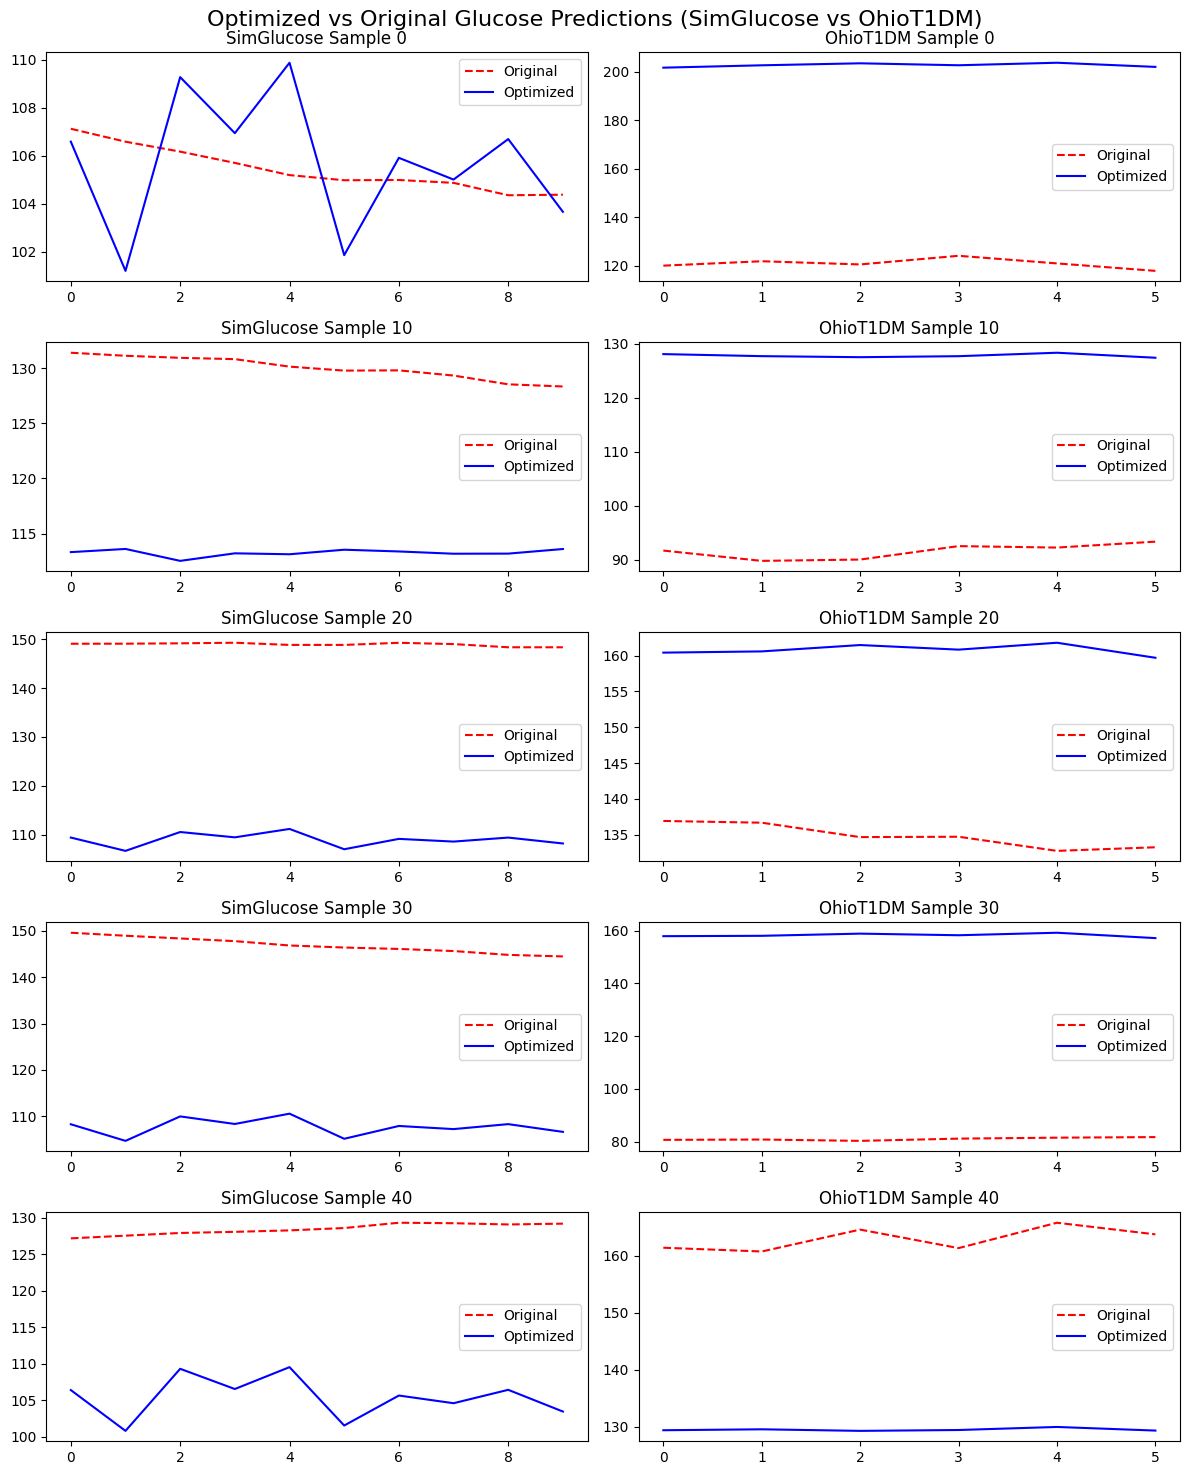

In [97]:
sample_indices = [0, 10, 20, 30, 40]

fig, axes = plt.subplots(5, 2, figsize=(12, 15))
for i, idx in enumerate(sample_indices):
    axes[i, 0].plot(simu_transformed_orig_targets_gru[idx], 'r--', label='Original')
    axes[i, 0].plot(simu_transformed_targets_gru[idx], 'b-', label='Optimized')
    axes[i, 0].set_title(f"SimGlucose Sample {idx}")
    axes[i, 0].legend()
    
    axes[i, 1].plot(ohio_transformed_orig_targets_gru[idx], 'r--', label='Original')
    axes[i, 1].plot(ohio_transformed_targets_gru[idx], 'b-', label='Optimized')
    axes[i, 1].set_title(f"OhioT1DM Sample {idx}")
    axes[i, 1].legend()

fig.suptitle("Optimized vs Original Glucose Predictions (SimGlucose vs OhioT1DM)", fontsize=16)
plt.tight_layout()
plt.show()


In [38]:
#print(pred_exog, pred_exog.shape)
opt = TimeSeriesOptimizer(method='sarimax', dataset=dataset, pred_exog=pred_exog_nbeats, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf_nbeats, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs, step_weights="meal")
opt.optimize()
sim_targets_sarimax = opt.targets
sim_orig_targets_sarimax = opt.orig_targets
sim_exogs_sarimax = opt.exogs
sim_orig_exogs_sarimax = opt.orig_exogs
sim_losses_sarimax = opt.losses
sim_transformed_targets_sarimax = opt.transformed_targets
sim_transformed_exogs_sarimax = opt.transformed_exogs
sim_transformed_orig_targets_sarimax = opt.transformed_orig_targets
sim_transformed_orig_exogs_sarimax = opt.transformed_orig_exogs
print(sim_transformed_targets_sarimax.shape, sim_transformed_exogs_sarimax.shape)

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/s

(100, 10) (100, 10, 2)


In [41]:
opt = TimeSeriesOptimizer(method='ols', dataset=dataset, pred_exog=pred_exog_nbeats, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf_nbeats, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs, step_weights="meal")
opt.optimize()
sim_targets_ols = opt.targets
sim_orig_targets_ols = opt.orig_targets
sim_exogs_ols = opt.exogs
sim_orig_exogs_ols = opt.orig_exogs
sim_losses_ols = opt.losses
sim_transformed_targets_ols = opt.transformed_targets
sim_transformed_exogs_ols = opt.transformed_exogs
sim_transformed_orig_targets_ols = opt.transformed_orig_targets
sim_transformed_orig_exogs_ols = opt.transformed_orig_exogs

In [42]:
opt = TimeSeriesOptimizer(method='nbeats', dataset=dataset, pred_exog=pred_exog_nbeats, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf_nbeats, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs, step_weights="meal")
opt.optimize()
sim_targets_nbeats = opt.targets
sim_orig_targets_nbeats = opt.orig_targets
sim_exogs_nbeats = opt.exogs
sim_orig_exogs_nbeats = opt.orig_exogs
sim_losses_nbeats = opt.losses
sim_transformed_targets_nbeats = opt.transformed_targets
sim_transformed_exogs_nbeats = opt.transformed_exogs
sim_transformed_orig_targets_nbeats = opt.transformed_orig_targets
sim_transformed_orig_exogs_nbeats = opt.transformed_orig_exogs

In [46]:
# Prepare new arrays to hold the inverse-transformed values
print(desired_min_lst)
numpy_desired_min = np.array(desired_min_lst)
numpy_desired_max = np.array(desired_max_lst)

inv_desired_min = np.empty_like(numpy_desired_min)
inv_desired_max = np.empty_like(numpy_desired_max)

for i in range(len(numpy_desired_min)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]

    # Flatten [time, features] to [time * features] or [time, features]
    min_flat = numpy_desired_min[i].reshape(-1, numpy_desired_min.shape[-1])
    max_flat = numpy_desired_max[i].reshape(-1, numpy_desired_max.shape[-1])

    # Inverse transform
    inv_min_flat = scaler.inverse_transform(min_flat)
    inv_max_flat = scaler.inverse_transform(max_flat)

    # Reshape back to original [time, features] and assign
    inv_desired_min[i] = inv_min_flat.reshape(numpy_desired_min.shape[1], numpy_desired_min.shape[2])
    inv_desired_max[i] = inv_max_flat.reshape(numpy_desired_max.shape[1], numpy_desired_max.shape[2])

# Overwrite original arrays
numpy_desired_min = inv_desired_min
numpy_desired_max = inv_desired_max

#print(numpy_desired_min, numpy_desired_max)


[array([[0.04985135],
       [0.05772132],
       [0.06559129],
       [0.07346126],
       [0.08133123],
       [0.0892012 ],
       [0.09707117],
       [0.10494114],
       [0.11281111],
       [0.12068108]]), array([[0.12466959],
       [0.13269358],
       [0.14071757],
       [0.14874156],
       [0.15676555],
       [0.16478953],
       [0.17281352],
       [0.18083751],
       [0.1888615 ],
       [0.19688549]]), array([[0.12423581],
       [0.13139246],
       [0.13854911],
       [0.14570576],
       [0.15286241],
       [0.16001906],
       [0.16717571],
       [0.17433236],
       [0.18148901],
       [0.18864566]]), array([[0.02929345],
       [0.04280936],
       [0.05632528],
       [0.0698412 ],
       [0.08335711],
       [0.09687303],
       [0.11038895],
       [0.12390486],
       [0.13742078],
       [0.1509367 ]]), array([[0.14657039],
       [0.15375557],
       [0.16094075],
       [0.16812592],
       [0.1753111 ],
       [0.18249628],
       [0.18968146],
    

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random
def evaluate_prediction_error(pred, true):
    mae = np.mean(np.abs(pred - true), axis=0)
    mse = np.mean((pred - true) ** 2, axis=0)
    rmse = np.sqrt(mse)
    max_dev = np.max(np.abs(pred - true), axis=0)
    mape = np.mean(np.abs((pred - true) / (true + 1e-8)), axis=0) * 100  # avoid div by 0

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Max Dev": max_dev,
        "MAPE (%)": mape
    }


def evaluate_bound_fitness(pred_target, min_bound, max_bound):
    within_bounds = (pred_target >= min_bound) & (pred_target <= max_bound)
    in_bound_percent = np.mean(within_bounds, axis=0) * 100

    # Violations: amount by which prediction is out of bounds
    over_max = np.maximum(0, pred_target - max_bound)
    under_min = np.maximum(0, min_bound - pred_target)
    violations = over_max + under_min  # shape (T, D)

    mean_violation = np.sum(violations, axis=0) / np.count_nonzero(violations, axis=0)
    total_violation_area = np.sum(violations, axis=0)

    return {
        "In-Bound %": in_bound_percent,
        "Mean Violation": mean_violation,
        "Total Violation Area": total_violation_area
    }


def compute_extreme_change_metrics(pred_exogs, orig_exogs):
    results = {}
    for i in range(pred_exogs.shape[-1]):
        orig = orig_exogs[:, i]
        pred = pred_exogs[:, i]

        mae = np.mean(np.abs(pred - orig))
        max_dev = np.max(np.abs(pred - orig))
        rel_change = np.mean(np.abs((pred - orig) / (orig + 1e-8)) * 100)

        results[f'var_{i}'] = {
            'MAE': mae,
            'Max Dev': max_dev,
            'Mean % Change': rel_change
        }

    return results

def plot_simulation_results(
    sim_transformed_targets,
    sim_transformed_orig_targets,
    sim_transformed_exogs,
    sim_transformed_orig_exogs,
    desired_min,
    desired_max,
    method="gru",
    dataset_name="ohiot1dm",
    sample_indices=None,
    save_prefix="plot",
    num_samples=5
):
    """
    Plots predicted vs. original targets and exogenous variables, with optional desired bounds.

    Parameters:
        sim_transformed_targets: np.ndarray
        sim_transformed_orig_targets: np.ndarray
        sim_transformed_exogs: np.ndarray
        sim_transformed_orig_exogs: np.ndarray
        desired_min: np.ndarray
        desired_max: np.ndarray
        method: str - Name of the model used ("gru", "sarimax", etc.)
        dataset_name: str - "ohiot1dm" or "simulated"
        sample_indices: list of ints or None - Specific sample indices to visualize
        save_prefix: str - Prefix for saved plots
        num_samples: int - If sample_indices is None, number of random samples to choose
    """

    if sample_indices is None:
        sample_indices = random.sample(range(sim_transformed_targets.shape[0]), num_samples)

    for sam in sample_indices:
        time_steps = np.arange(sim_transformed_orig_targets.shape[1])

        orig_targets = sim_transformed_orig_targets[sam]
        pred_targets = sim_transformed_targets[sam]
        orig_exogs = sim_transformed_orig_exogs[sam]
        pred_exogs = sim_transformed_exogs[sam]

        # Expand dims if necessary
        if orig_targets.ndim == 1:
            orig_targets = orig_targets[:, np.newaxis]
        if pred_targets.ndim == 1:
            pred_targets = pred_targets[:, np.newaxis]
        if desired_min.ndim == 2:
            desired_min = desired_min[:, :, np.newaxis]
        if desired_max.ndim == 2:
            desired_max = desired_max[:, :, np.newaxis]

        num_target_vars = orig_targets.shape[-1]

        # Plot Targets
        plt.figure(figsize=(12, 4 * num_target_vars))
        for i in range(num_target_vars):
            plt.subplot(num_target_vars, 1, i + 1)
            plt.plot(time_steps, orig_targets[:, i], label='Original Target', color='blue')
            plt.plot(time_steps, pred_targets[:, i], label='Predicted Target', color='orange')
            plt.fill_between(
                time_steps,
                desired_min[sam, :, i],
                desired_max[sam, :, i],
                color='green',
                alpha=0.2,
                label='Desired Range' if i == 0 else None
            )
            plt.title(f"Target Variable {i+1} (e.g., Blood Glucose Level)")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.legend()
        plt.tight_layout()
        plt.savefig(f"{save_prefix}_targets_{method}_{sam}.png")
        plt.show()

        # Exogenous Variable Labels
        if dataset_name == "ohiot1dm":
            labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
        elif dataset_name == "simulated":
            labels = ["carbohydrates", "insulin"]
        else:
            labels = [f"Exogenous {i+1}" for i in range(orig_exogs.shape[-1])]

        num_exog_vars = orig_exogs.shape[-1]

        # Plot Exogenous Variables
        plt.figure(figsize=(12, 4 * num_exog_vars))
        for i in range(num_exog_vars):
            plt.subplot(num_exog_vars, 1, i + 1)
            plt.plot(time_steps, orig_exogs[:, i], label='Original Exogenous', color='blue')
            plt.plot(time_steps, pred_exogs[:, i], label='Predicted Exogenous', color='orange')
            plt.title(f"Exogenous Variable: {labels[i]}")
            plt.xlabel("Time Step")
            plt.ylabel("Value")
            plt.legend()
        plt.tight_layout()
        plt.savefig(f"{save_prefix}_exogs_{method}_{sam}.png")
        plt.show()

        results_exogs = compute_extreme_change_metrics(pred_exogs, orig_exogs)
        print(results_exogs)
        results_targets_in_bounds = evaluate_bound_fitness(pred_targets, desired_min, desired_max)
        print(results_targets_in_bounds)
        results_targets_comp = evaluate_prediction_error(pred_targets, orig_targets)
        print(results_targets_comp)


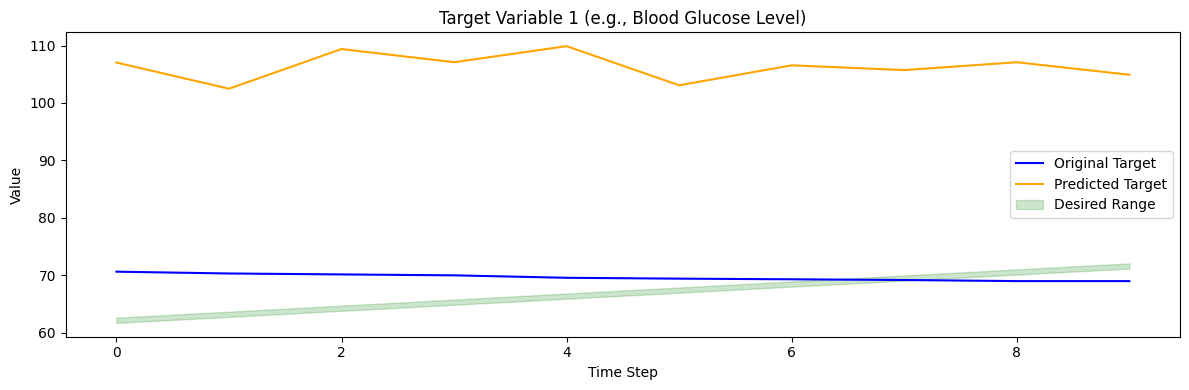

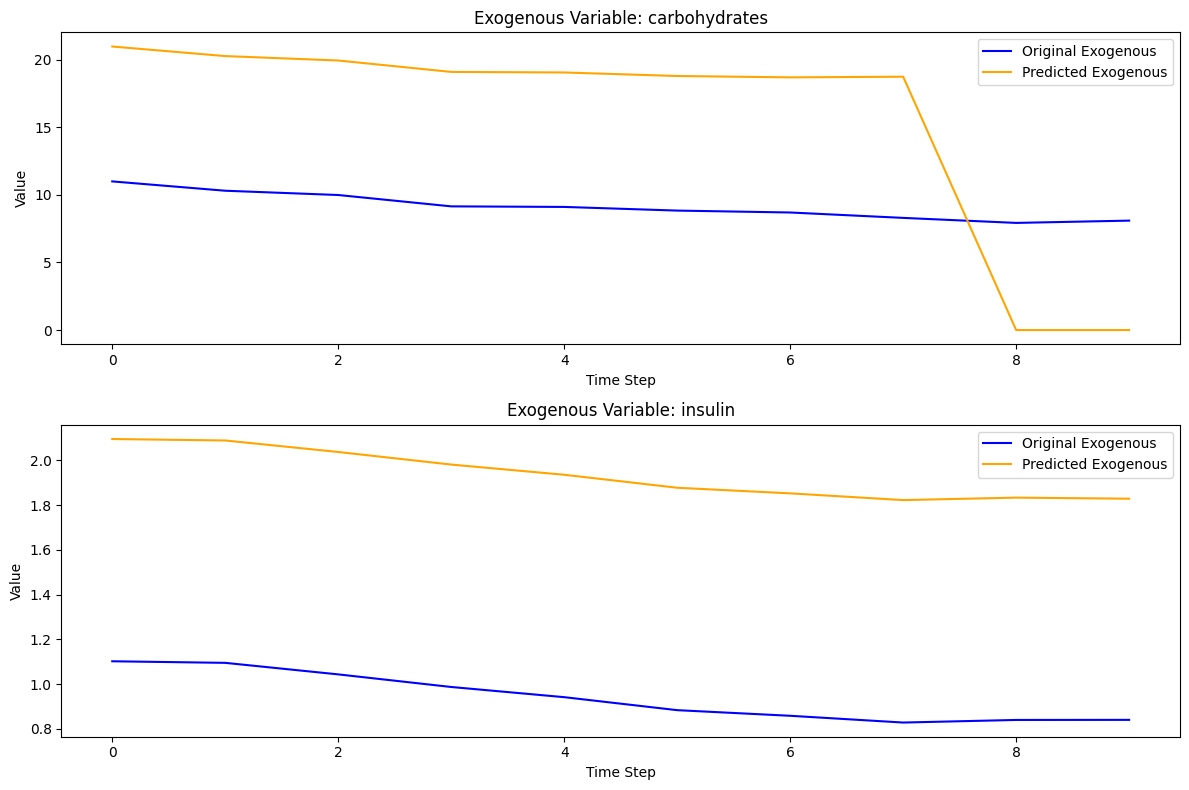

{'var_0': {'MAE': 9.622288751602174, 'Max Dev': 10.447090148925781, 'Mean % Change': 105.84312301661684}, 'var_1': {'MAE': 0.9934455871582031, 'Max Dev': 0.9943232536315918, 'Mean % Change': 106.70746870174469}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([36.6724411]), 'RMSE': array([36.74391846]), 'Max Dev': array([40.3219223]), 'MAPE (%)': array([52.65856599])}


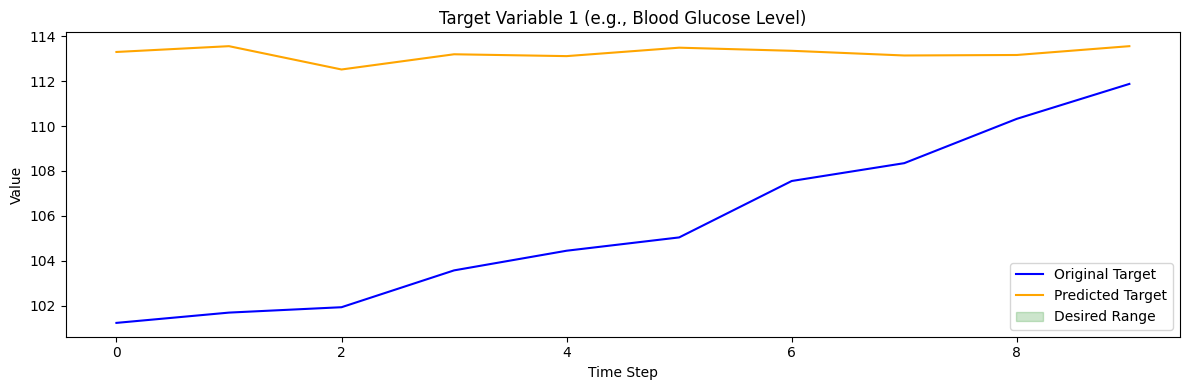

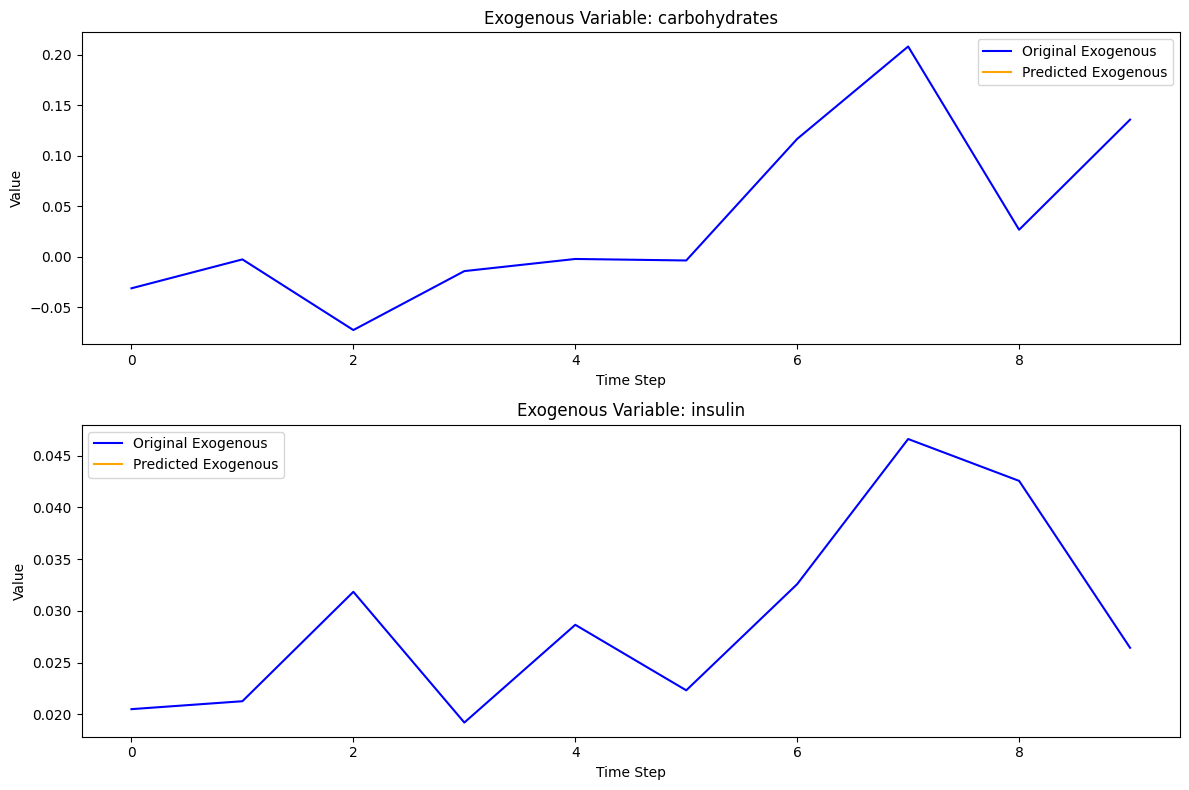

{'var_0': {'MAE': nan, 'Max Dev': nan, 'Mean % Change': nan}, 'var_1': {'MAE': nan, 'Max Dev': nan, 'Mean % Change': nan}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([7.63186493]), 'RMSE': array([8.39071866]), 'Max Dev': array([12.05596924]), 'MAPE (%)': array([7.34463483])}


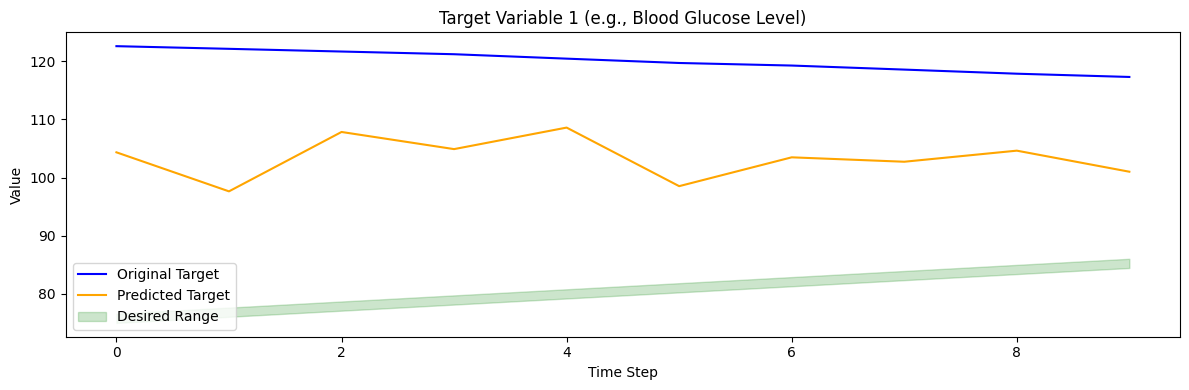

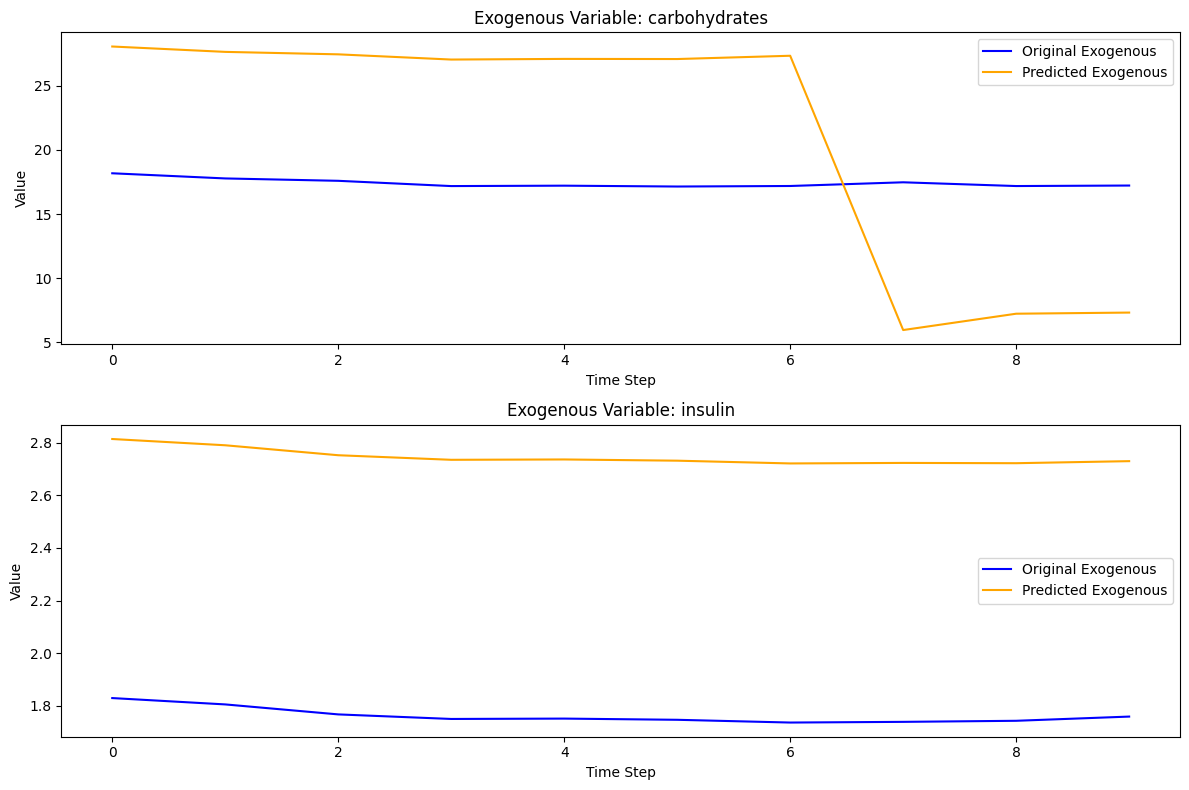

{'var_0': {'MAE': 10.08312168121338, 'Max Dev': 11.519227504730225, 'Mean % Change': 57.911475422361434}, 'var_1': {'MAE': 0.9815642595291137, 'Max Dev': 0.9837794303894043, 'Mean % Change': 55.67535264395783}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([16.71329498]), 'RMSE': array([17.09509299]), 'Max Dev': array([24.51262665]), 'MAPE (%)': array([13.90516035])}


In [62]:
plot_simulation_results(
    sim_transformed_targets=sim_transformed_targets_gru,
    sim_transformed_orig_targets=sim_transformed_orig_targets_gru,
    sim_transformed_exogs=sim_transformed_exogs_gru,
    sim_transformed_orig_exogs=sim_transformed_orig_exogs_gru,
    desired_min=numpy_desired_min,
    desired_max=numpy_desired_max,
    method="gru",
    dataset_name="simulated",
    save_prefix="sim",
    num_samples=3
)


In [74]:
import numpy as np

def summarize_sample_results(
    sample_idx,
    orig_targets,
    pred_targets,
    orig_exogs,
    pred_exogs,
    desired_min,
    desired_max,
    var_names_exog=None,
    var_name_target="Blood Glucose"
):
    summary = {}
    
    # --- Target deviation from original ---
    abs_diff = np.abs(pred_targets - orig_targets)
    mae = np.mean(abs_diff)
    rmse = np.sqrt(np.mean((pred_targets - orig_targets) ** 2))
    max_dev = np.max(abs_diff)
    mape = np.mean(np.abs((pred_targets - orig_targets) / (orig_targets + 1e-6))) * 100

    summary['target_diff'] = {
        'MAE': mae,
        'RMSE': rmse,
        'Max Dev': max_dev,
        'MAPE (%)': mape
    }

    # --- Target in-bound stats ---
    in_bounds = np.logical_and(pred_targets >= desired_min, pred_targets <= desired_max)
    percent_in_bounds = 100 * np.mean(in_bounds)
    out_of_bounds = ~in_bounds
    violation_amounts = np.where(pred_targets < desired_min,
                                 desired_min - pred_targets,
                                 np.where(pred_targets > desired_max,
                                          pred_targets - desired_max,
                                          0))
    mean_violation = np.mean(violation_amounts[out_of_bounds]) if np.any(out_of_bounds) else 0
    total_violation_area = np.sum(violation_amounts)

    summary['bound_stats'] = {
        'In-Bound %': percent_in_bounds,
        'Mean Violation': mean_violation,
        'Total Violation Area': total_violation_area
    }

    # --- Exogenous variable changes ---
    num_exogs = orig_exogs.shape[1]
    exog_stats = {}
    for i in range(num_exogs):
        orig = orig_exogs[:, i]
        pred = pred_exogs[:, i]
        diff = np.abs(pred - orig)
        mean_pct_change = np.mean(np.abs(pred - orig) / (np.abs(orig) + 1e-6)) * 100
        exog_stats[var_names_exog[i] if var_names_exog else f"var_{i}"] = {
            'MAE': np.mean(diff),
            'Max Dev': np.max(diff),
            'Mean % Change': mean_pct_change
        }
    
    summary['exog_changes'] = exog_stats

    # --- Text summary ---
    print(f"Sample {sample_idx} Summary:")
    print("Target Prediction Deviation:")
    for k, v in summary['target_diff'].items():
        print(f"  - {k}: {v:.2f}")
    
    print("Target vs Bounds:")
    print(f"  - In Bound %: {summary['bound_stats']['In-Bound %']:.1f}%")
    print(f"  - Mean Violation: {summary['bound_stats']['Mean Violation']:.2f}")
    print(f"  - Total Violation Area: {summary['bound_stats']['Total Violation Area']:.2f}")

    print("Exogenous Changes:")
    for var, stats in exog_stats.items():
        print(f"  - {var}: MAE={stats['MAE']:.2f}, MaxDev={stats['Max Dev']:.2f}, Mean %Change={stats['Mean % Change']:.1f}%")

    return summary


In [50]:
# Choose sample index
sam = 50

# Call summary
summary_stats = summarize_sample_results(
    sample_idx=sam,
    orig_targets=sim_transformed_orig_targets_gru[sam],
    pred_targets=sim_transformed_targets_gru[sam],
    orig_exogs=sim_transformed_orig_exogs_gru[sam],
    pred_exogs=sim_transformed_exogs_gru[sam],
    desired_min=numpy_desired_min[sam, :, 0],
    desired_max=numpy_desired_max[sam, :, 0],
    var_names_exog=["Basal", "Bolus", "Carbs", "Exercise"],
    var_name_target="Blood Glucose"
)


Sample 50 Summary:
Target Prediction Deviation:
  - MAE: 42.92
  - RMSE: 43.01
  - Max Dev: 46.71
  - MAPE (%): 28.22
Target vs Bounds:
  - In Bound %: 0.0%
  - Mean Violation: 50.86
  - Total Violation Area: 508.57
Exogenous Changes:
  - Basal: MAE=8.35, MaxDev=10.02, Mean %Change=547.5%
  - Bolus: MAE=1.00, MaxDev=1.00, Mean %Change=580.5%


In [79]:
import numpy as np

def evaluate_timeseries_counterfactuals(
    orig_targets,       # shape: (samples, time)
    pred_targets,       # shape: (samples, time)
    orig_exogs,         # shape: (samples, time, exog_vars)
    pred_exogs,         # shape: (samples, time, exog_vars)
    desired_mins,       # shape: (samples, time)
    desired_maxs,       # shape: (samples, time)
    var_names_exog=None,
    var_name_target="Blood Glucose"
):
    summary = {}

    # --- Target deviation metrics per sample & time ---
    abs_diff = np.abs(pred_targets - orig_targets)  # (samples, time)
    squared_diff = (pred_targets - orig_targets) ** 2

    # Metrics averaged over time first (per sample)
    mae_per_sample = np.mean(abs_diff, axis=1)
    rmse_per_sample = np.sqrt(np.mean(squared_diff, axis=1))
    max_dev_per_sample = np.max(abs_diff, axis=1)
    mape_per_sample = np.mean(np.abs((pred_targets - orig_targets) / (orig_targets + 1e-6)), axis=1) * 100

    # Then average over samples
    summary['target_diff'] = {
        'MAE': np.mean(mae_per_sample),
        'RMSE': np.mean(rmse_per_sample),
        'Max Dev': np.max(max_dev_per_sample),
        'MAPE (%)': np.mean(mape_per_sample)
    }

    # --- Target in-bound stats per sample & time ---
    in_bounds = np.logical_and(pred_targets >= desired_mins, pred_targets <= desired_maxs)  # (samples, time)
    percent_in_bounds_per_sample = 100 * np.mean(in_bounds, axis=1)
    out_of_bounds = ~in_bounds

    violation_amounts = np.where(
        pred_targets < desired_mins,
        desired_mins - pred_targets,
        np.where(pred_targets > desired_maxs,
                 pred_targets - desired_maxs,
                 0)
    )  # (samples, time)

    # Mean violation per sample only where violations exist
    mean_violation_per_sample = np.array([
        np.mean(violation_amounts[sample_idx][out_of_bounds[sample_idx]]) if np.any(out_of_bounds[sample_idx]) else 0
        for sample_idx in range(pred_targets.shape[0])
    ])

    # Total violation summed over all samples and time steps
    total_violation_area = np.sum(violation_amounts)

    summary['bound_stats'] = {
        'In-Bound %': np.mean(percent_in_bounds_per_sample),
        'Mean Violation': np.mean(mean_violation_per_sample),
        'Total Violation Area': total_violation_area
    }

    # --- Exogenous variable changes per sample & time ---
    num_exogs = orig_exogs.shape[2]
    exog_stats = {}
    for i in range(num_exogs):
        orig = orig_exogs[:, :, i]
        pred = pred_exogs[:, :, i]
        print(f"{var_names_exog[i]} - orig min: {np.nanmin(orig)}, max: {np.nanmax(orig)}, contains NaNs: {np.isnan(orig).any()}")
        print(f"{var_names_exog[i]} - pred min: {np.nanmin(pred)}, max: {np.nanmax(pred)}, contains NaNs: {np.isnan(pred).any()}")
    
        diff = np.abs(pred - orig)  # (samples, time)
        mean_pct_change_per_sample = np.mean(diff / (np.abs(orig) + 1e-6), axis=1) * 100

        exog_stats[var_names_exog[i] if var_names_exog else f"var_{i}"] = {
            'MAE': np.mean(np.mean(diff, axis=1)),         # avg MAE per sample, then avg over samples
            'Max Dev': np.max(diff),                       # max over all samples and time
            'Mean % Change': np.mean(mean_pct_change_per_sample)
        }

    summary['exog_changes'] = exog_stats

    # --- Text Summary ---
    print(f"\n🔍 Overall Time-Series Summary ({pred_targets.shape[0]} samples, {pred_targets.shape[1]} time steps):")
    print(f"📊 Target Prediction Deviation (averaged over samples and time):")
    for k, v in summary['target_diff'].items():
        if k == 'MAPE (%)':
            print(f"  - {k}: {v:.2f}%")
        else:
            print(f"  - {k}: {v:.2f}")
    
    print("\n✅ Target vs Bounds:")
    print(f"  - In Bound %: {summary['bound_stats']['In-Bound %']:.1f}%")
    print(f"  - Mean Violation: {summary['bound_stats']['Mean Violation']:.2f}")
    print(f"  - Total Violation Area: {summary['bound_stats']['Total Violation Area']:.2f}")

    print("\n📈 Exogenous Changes:")
    for var, stats in exog_stats.items():
        print(f"  - {var}: MAE={stats['MAE']:.2f}, MaxDev={stats['Max Dev']:.2f}, Mean %Change={stats['Mean % Change']:.1f}%")

    return summary


In [82]:
summary = evaluate_timeseries_counterfactuals(
    orig_targets=sim_transformed_orig_targets_gru,       # (100, 6)
    pred_targets=sim_transformed_targets_gru,            # (100, 6)
    orig_exogs=sim_transformed_orig_exogs_gru,           # (100, 6, 4)
    pred_exogs=sim_transformed_exogs_gru,                # (100, 6, 4)
    desired_mins=numpy_desired_min.squeeze(),                      # (100, 6)
    desired_maxs=numpy_desired_max.squeeze(),                      # (100, 6)
    var_names_exog=["Carbohydrates", "Insulin"]
)


Carbohydrates - orig min: -0.527387797832489, max: 22.797582626342773, contains NaNs: False
Carbohydrates - pred min: 0.0, max: 32.59765625, contains NaNs: True
Insulin - orig min: -0.022829705849289894, max: 2.3064212799072266, contains NaNs: False
Insulin - pred min: 1.0090913772583008, max: 3.281588315963745, contains NaNs: True

🔍 Overall Time-Series Summary (100 samples, 10 time steps):
📊 Target Prediction Deviation (averaged over samples and time):
  - MAE: 29.15
  - RMSE: 29.39
  - Max Dev: 76.91
  - MAPE (%): 28.19%

✅ Target vs Bounds:
  - In Bound %: 0.0%
  - Mean Violation: 31.80
  - Total Violation Area: 31796.35

📈 Exogenous Changes:
  - Carbohydrates: MAE=nan, MaxDev=nan, Mean %Change=nan%
  - Insulin: MAE=nan, MaxDev=nan, Mean %Change=nan%


In [83]:
summary = evaluate_timeseries_counterfactuals(
    orig_targets=sim_transformed_orig_targets_sarimax,       # (100, 6)
    pred_targets=sim_transformed_targets_sarimax,            # (100, 6)
    orig_exogs=sim_transformed_orig_exogs_sarimax,           # (100, 6, 4)
    pred_exogs=sim_transformed_exogs_sarimax,                # (100, 6, 4)
    desired_mins=numpy_desired_min.squeeze(),                      # (100, 6)
    desired_maxs=numpy_desired_max.squeeze(),                      # (100, 6)
    var_names_exog=["Carbohydrates", "Insulin"]
)


Carbohydrates - orig min: 2.8002467155456543, max: 74.30206298828125, contains NaNs: False
Carbohydrates - pred min: -0.40401098132133484, max: 25.01792335510254, contains NaNs: False
Insulin - orig min: 0.2811363935470581, max: 7.449990272521973, contains NaNs: False
Insulin - pred min: -0.019861096516251564, max: 2.5346336364746094, contains NaNs: False

🔍 Overall Time-Series Summary (100 samples, 10 time steps):
📊 Target Prediction Deviation (averaged over samples and time):
  - MAE: 3.33
  - RMSE: 3.58
  - Max Dev: 15.36
  - MAPE (%): 2.98%

✅ Target vs Bounds:
  - In Bound %: 0.8%
  - Mean Violation: 44.30
  - Total Violation Area: 44266.23

📈 Exogenous Changes:
  - Carbohydrates: MAE=33.05, MaxDev=66.03, Mean %Change=77.6%
  - Insulin: MAE=3.30, MaxDev=6.61, Mean %Change=76.8%


In [84]:
summary = evaluate_timeseries_counterfactuals(
    orig_targets=sim_transformed_orig_targets_ols,       # (100, 6)
    pred_targets=sim_transformed_targets_ols,            # (100, 6)
    orig_exogs=sim_transformed_orig_exogs_ols,           # (100, 6, 4)
    pred_exogs=sim_transformed_exogs_ols,                # (100, 6, 4)
    desired_mins=numpy_desired_min.squeeze(),                      # (100, 6)
    desired_maxs=numpy_desired_max.squeeze(),                      # (100, 6)
    var_names_exog=["Carbohydrates", "Insulin"]
)

Carbohydrates - orig min: 2.8002467155456543, max: 74.30206298828125, contains NaNs: False
Carbohydrates - pred min: -0.40401098132133484, max: 24.249197006225586, contains NaNs: False
Insulin - orig min: 0.2811363935470581, max: 7.449990272521973, contains NaNs: False
Insulin - pred min: -0.019861096516251564, max: 2.4491171836853027, contains NaNs: False

🔍 Overall Time-Series Summary (100 samples, 10 time steps):
📊 Target Prediction Deviation (averaged over samples and time):
  - MAE: 72.12
  - RMSE: 72.15
  - Max Dev: 129.43
  - MAPE (%): 57.65%

✅ Target vs Bounds:
  - In Bound %: 0.0%
  - Mean Violation: 21.09
  - Total Violation Area: 21091.24

📈 Exogenous Changes:
  - Carbohydrates: MAE=33.02, MaxDev=67.94, Mean %Change=77.3%
  - Insulin: MAE=3.30, MaxDev=6.83, Mean %Change=76.5%


In [85]:
summary = evaluate_timeseries_counterfactuals(
    orig_targets=sim_transformed_orig_targets_nbeats,       # (100, 6)
    pred_targets=sim_transformed_targets_nbeats,            # (100, 6)
    orig_exogs=sim_transformed_orig_exogs_nbeats,           # (100, 6, 4)
    pred_exogs=sim_transformed_exogs_nbeats,                # (100, 6, 4)
    desired_mins=numpy_desired_min.squeeze(),                      # (100, 6)
    desired_maxs=numpy_desired_max.squeeze(),                      # (100, 6)
    var_names_exog=["Carbohydrates", "Insulin"]
)

Carbohydrates - orig min: -0.527387797832489, max: 22.797582626342773, contains NaNs: False
Carbohydrates - pred min: 0.0, max: 30.057531356811523, contains NaNs: True
Insulin - orig min: -0.022829705849289894, max: 2.3064212799072266, contains NaNs: False
Insulin - pred min: 0.021124999970197678, max: 3.271723747253418, contains NaNs: True

🔍 Overall Time-Series Summary (100 samples, 10 time steps):
📊 Target Prediction Deviation (averaged over samples and time):
  - MAE: 68.47
  - RMSE: 68.72
  - Max Dev: 134.68
  - MAPE (%): 54.25%

✅ Target vs Bounds:
  - In Bound %: 0.0%
  - Mean Violation: 17.26
  - Total Violation Area: 17257.68

📈 Exogenous Changes:
  - Carbohydrates: MAE=nan, MaxDev=nan, Mean %Change=nan%
  - Insulin: MAE=nan, MaxDev=nan, Mean %Change=nan%


In [67]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_timeseries_per_timestep(
    orig_targets, pred_targets,
    orig_exogs, pred_exogs,
    desired_mins, desired_maxs,
    var_names_exog=None,
    var_name_target="Target",
    method="GRU"
):
    n_samples, n_timesteps = orig_targets.shape
    n_exogs = orig_exogs.shape[2]

    # --- Target prediction deviations per time step ---
    abs_diff = np.abs(pred_targets - orig_targets)
    mae_per_time = np.mean(abs_diff, axis=0)
    rmse_per_time = np.sqrt(np.mean((pred_targets - orig_targets) ** 2, axis=0))
    max_dev = np.max(abs_diff)  # max over all samples and time
    mape_per_time = np.mean(np.abs((pred_targets - orig_targets) / (orig_targets + 1e-6)), axis=0) * 100

    # --- Target in-bound metrics per time step ---
    in_bounds = (pred_targets >= desired_mins) & (pred_targets <= desired_maxs)
    in_bound_percent_per_time = np.mean(in_bounds, axis=0) * 100

    violation_amounts = np.where(
        pred_targets < desired_mins,
        desired_mins - pred_targets,
        np.where(
            pred_targets > desired_maxs,
            pred_targets - desired_maxs,
            0
        )
    )
    # Mean violation only over out-of-bound samples per time step
    mean_violation_per_time = np.array([
        violation_amounts[:, t][~in_bounds[:, t]].mean() if np.any(~in_bounds[:, t]) else 0
        for t in range(n_timesteps)
    ])
    total_violation_area_per_time = np.sum(violation_amounts, axis=0)

    # --- Exogenous variable changes per time step ---
    exog_stats = {}
    for i in range(n_exogs):
        orig = orig_exogs[:, :, i]
        pred = pred_exogs[:, :, i]
        diff = np.abs(pred - orig)
        mae_exog = np.mean(diff, axis=0)             # per time step
        max_dev_exog = np.max(diff, axis=0)          # per time step
        mean_pct_change_exog = np.mean(diff / (np.abs(orig) + 1e-6), axis=0) * 100

        var_name = var_names_exog[i] if var_names_exog else f"var_{i}"
        exog_stats[var_name] = {
            'MAE_per_time': mae_exog,
            'MaxDev_per_time': max_dev_exog,
            'MeanPctChange_per_time': mean_pct_change_exog
        }

    # --- Print summary ---
    print(f"\n🔍 Overall Time-Series Summary ({n_samples} samples, {n_timesteps} time steps):")

    print(f"📊 {var_name_target} Prediction Deviation (per time step):")
    for t in range(n_timesteps):
        print(f"  - Time {t}: MAE={mae_per_time[t]:.2f}, RMSE={rmse_per_time[t]:.2f}, MAPE={mape_per_time[t]:.2f}%")
    print(f"  - Max Dev (overall): {max_dev:.2f}")

    print(f"\n✅ {var_name_target} vs Bounds (per time step):")
    for t in range(n_timesteps):
        print(f"  - Time {t}: In Bound %={in_bound_percent_per_time[t]:.1f}%, "
              f"Mean Violation={mean_violation_per_time[t]:.2f}, Total Violation Area={total_violation_area_per_time[t]:.2f}")

    print(f"\n📈 Exogenous Changes (per time step):")
    for var, stats in exog_stats.items():
        print(f"  - {var}:")
        for t in range(n_timesteps):
            print(f"    * Time {t}: MAE={stats['MAE_per_time'][t]:.2f}, MaxDev={stats['MaxDev_per_time'][t]:.2f}, "
                  f"Mean %Change={stats['MeanPctChange_per_time'][t]:.2f}%")

    # --- Optional: plot errors and in-bound percentages ---
    time_steps = np.arange(n_timesteps)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(time_steps, mae_per_time, marker='o', label='MAE')
    plt.plot(time_steps, rmse_per_time, marker='x', label='RMSE')
    plt.xlabel('Time Step')
    plt.ylabel('Error')
    plt.title(f'{var_name_target} Prediction Errors Over Time')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(time_steps, in_bound_percent_per_time, marker='o', color='green')
    plt.xlabel('Time Step')
    plt.ylabel('In Bound %')
    plt.title(f'{var_name_target} In-Bound Percentage Over Time')
    plt.ylim(0, 100)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"errors_inbound_over_time_{method}.png")
    plt.show()

    return {
        'mae_per_time': mae_per_time,
        'rmse_per_time': rmse_per_time,
        'max_dev': max_dev,
        'mape_per_time': mape_per_time,
        'in_bound_percent_per_time': in_bound_percent_per_time,
        'mean_violation_per_time': mean_violation_per_time,
        'total_violation_area_per_time': total_violation_area_per_time,
        'exog_stats_per_time': exog_stats
    }



🔍 Overall Time-Series Summary (100 samples, 10 time steps):
📊 Blood Glucose Prediction Deviation (per time step):
  - Time 0: MAE=28.93, RMSE=34.17, MAPE=28.15%
  - Time 1: MAE=30.91, RMSE=36.01, MAPE=28.90%
  - Time 2: MAE=28.25, RMSE=33.55, MAPE=28.06%
  - Time 3: MAE=28.94, RMSE=34.23, MAPE=28.22%
  - Time 4: MAE=28.03, RMSE=33.37, MAPE=28.09%
  - Time 5: MAE=30.44, RMSE=35.64, MAPE=28.68%
  - Time 6: MAE=29.05, RMSE=34.36, MAPE=28.07%
  - Time 7: MAE=29.20, RMSE=34.48, MAPE=28.07%
  - Time 8: MAE=28.50, RMSE=33.73, MAPE=27.81%
  - Time 9: MAE=29.29, RMSE=34.58, MAPE=27.89%
  - Max Dev (overall): 76.91

✅ Blood Glucose vs Bounds (per time step):
  - Time 0: In Bound %=0.0%, Mean Violation=38.58, Total Violation Area=3857.95
  - Time 1: In Bound %=0.0%, Mean Violation=32.73, Total Violation Area=3272.59
  - Time 2: In Bound %=0.0%, Mean Violation=38.22, Total Violation Area=3821.74
  - Time 3: In Bound %=0.0%, Mean Violation=34.68, Total Violation Area=3468.27
  - Time 4: In Bound %

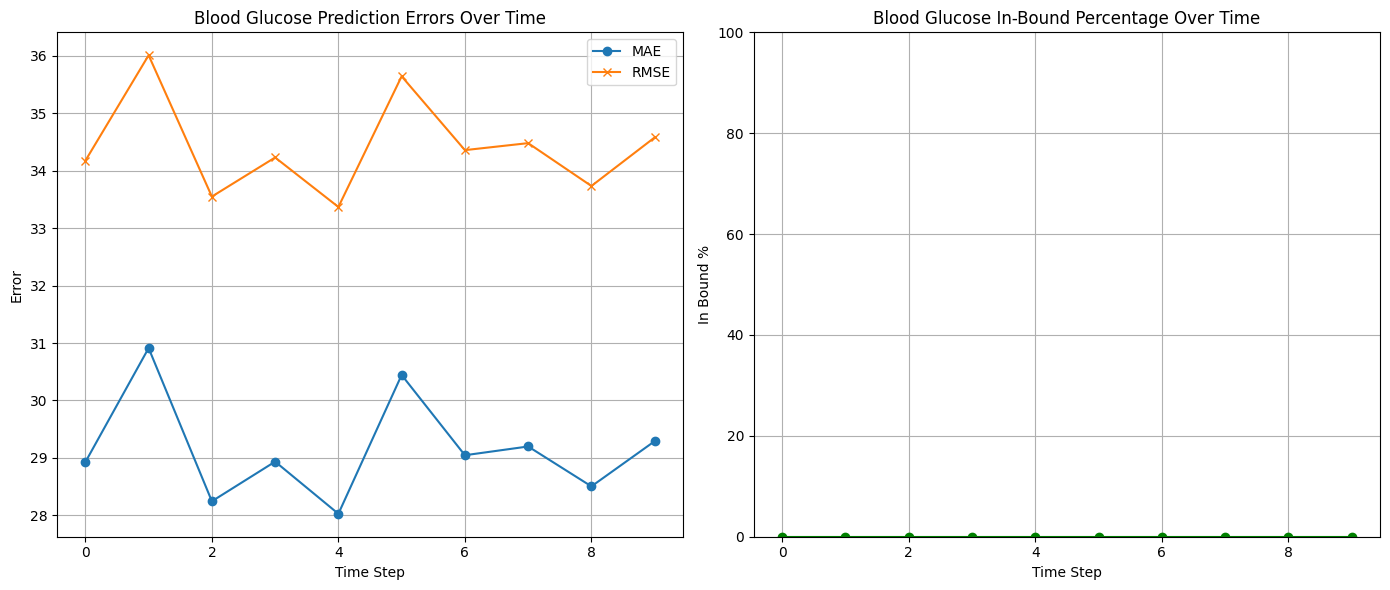

In [69]:
summary = evaluate_timeseries_per_timestep(
    orig_targets=sim_transformed_orig_targets_gru,
    pred_targets=sim_transformed_targets_gru,
    orig_exogs=sim_transformed_orig_exogs_gru,
    pred_exogs=sim_transformed_exogs_gru,
    desired_mins=numpy_desired_min.squeeze(),
    desired_maxs=numpy_desired_max.squeeze(),
    var_names_exog=["Carbohydrates", "Insulin"],
    var_name_target="Blood Glucose",
    method="GRU"
)


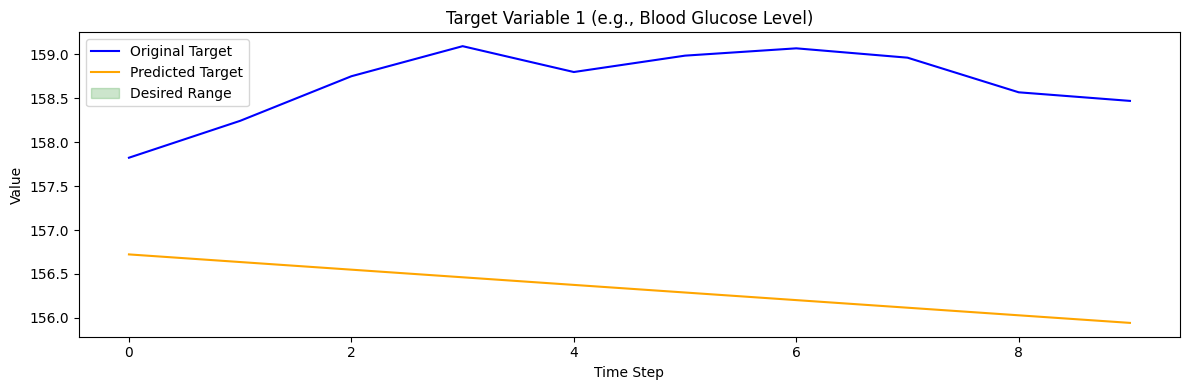

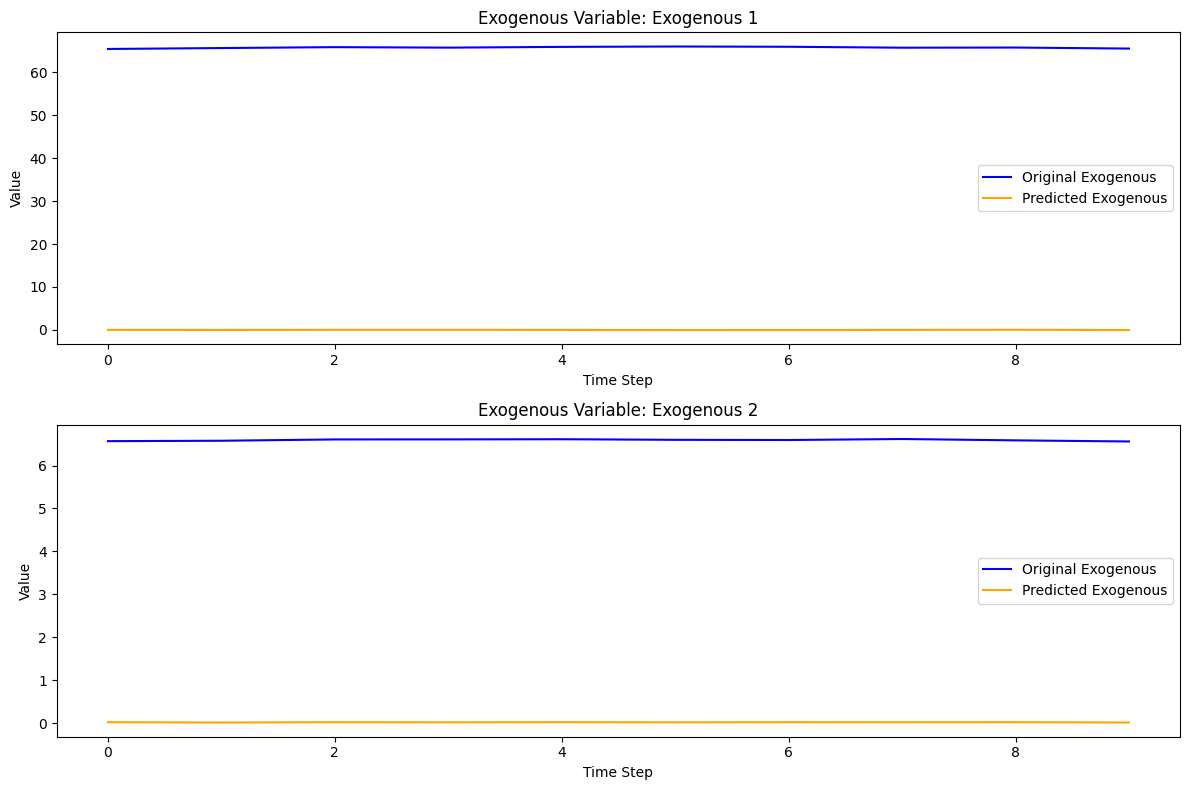

{'var_0': {'MAE': 65.75523295272141, 'Max Dev': 66.02865231409669, 'Mean % Change': 100.00656109210213}, 'var_1': {'MAE': 6.573525460343808, 'Max Dev': 6.596405329182744, 'Mean % Change': 99.6957243331322}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([2.34009094]), 'RMSE': array([2.40142551]), 'Max Dev': array([2.86151123]), 'MAPE (%)': array([1.47404221])}


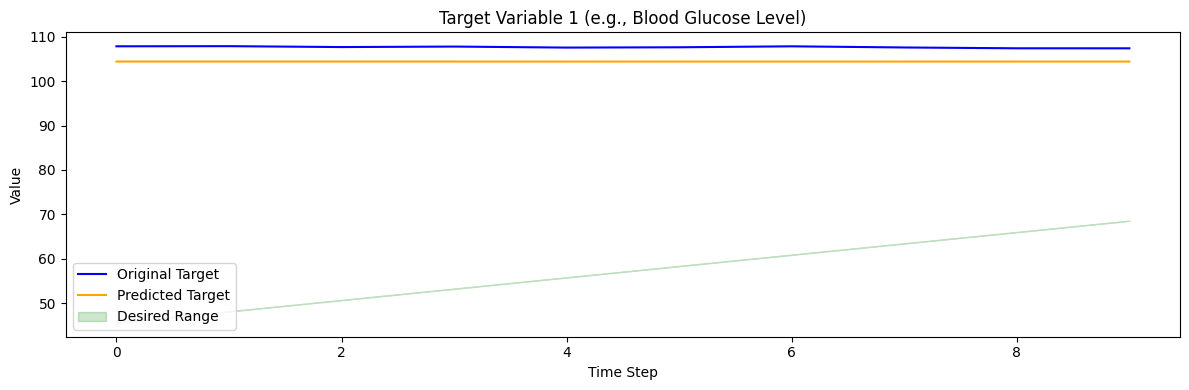

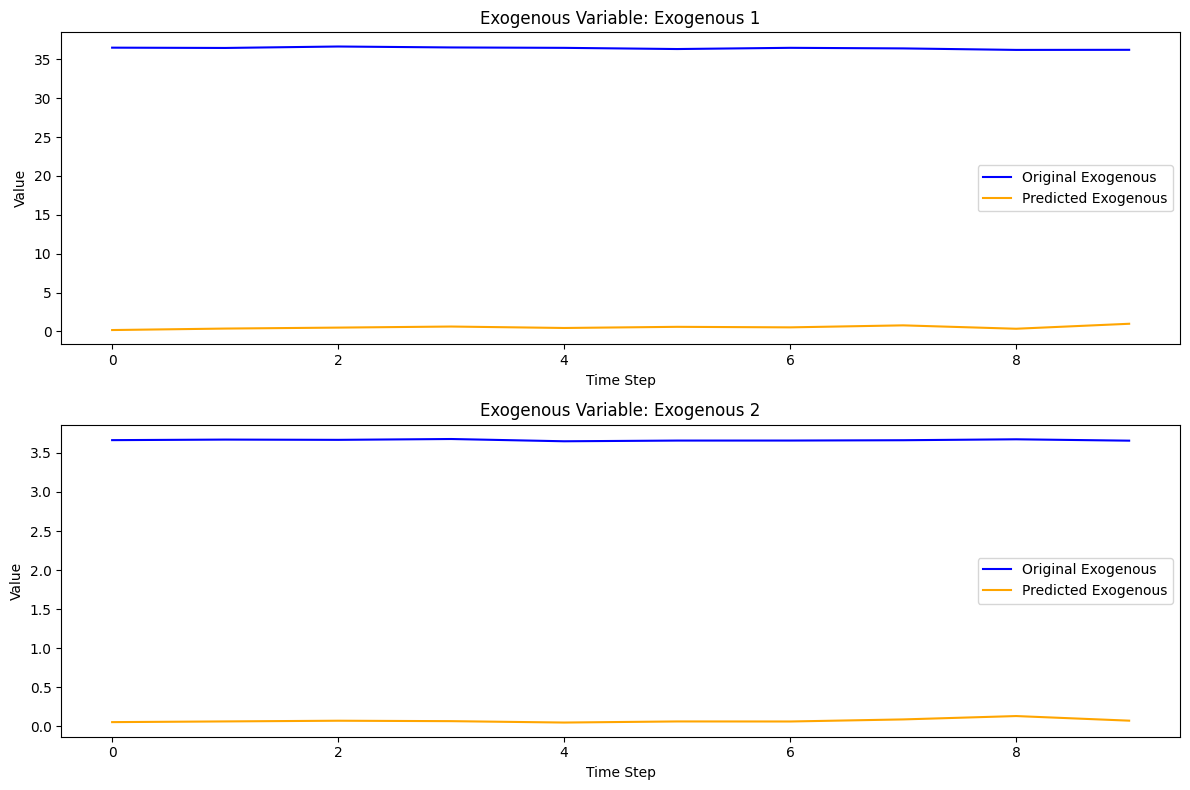

{'var_0': {'MAE': 35.913370192050934, 'Max Dev': 36.34423193335533, 'Mean % Change': 98.54824444501753}, 'var_1': {'MAE': 3.5926831647753716, 'Max Dev': 3.6126463785767555, 'Mean % Change': 98.060353424698}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([3.24381866]), 'RMSE': array([3.24817875]), 'Max Dev': array([3.45912933]), 'MAPE (%)': array([3.01307849])}


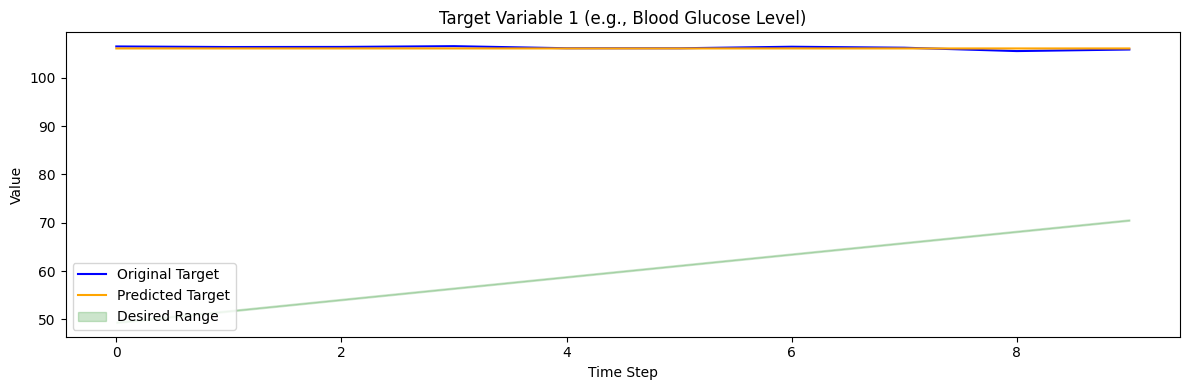

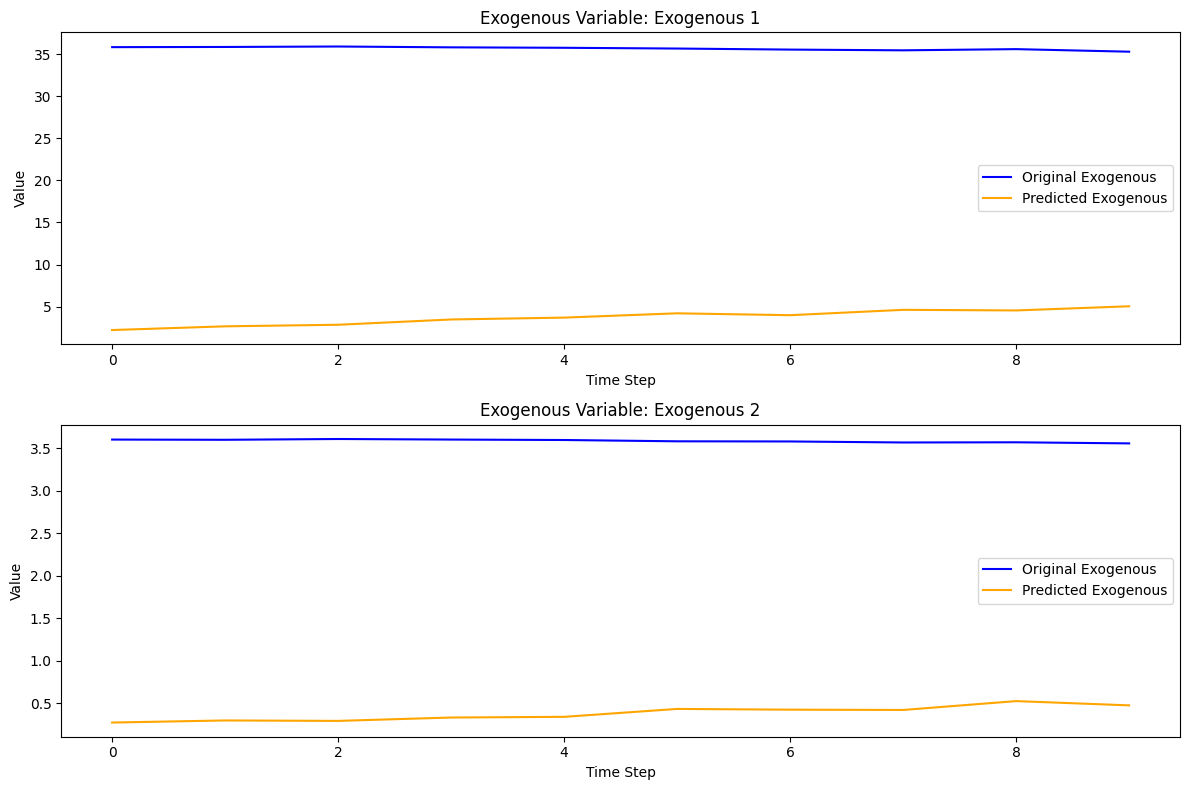

{'var_0': {'MAE': 31.939981293678283, 'Max Dev': 33.61210608482361, 'Mean % Change': 89.54775538364036}, 'var_1': {'MAE': 3.2072518467903137, 'Max Dev': 3.331244170665741, 'Mean % Change': 89.38846831408549}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([0.28482437]), 'RMSE': array([0.32815654]), 'Max Dev': array([0.54337311]), 'MAPE (%)': array([0.26810285])}


In [70]:
plot_simulation_results(
    sim_transformed_targets=sim_transformed_targets_sarimax,
    sim_transformed_orig_targets=sim_transformed_orig_targets_sarimax,
    sim_transformed_exogs=sim_transformed_exogs_sarimax,
    sim_transformed_orig_exogs=sim_transformed_orig_exogs_sarimax,
    desired_min=numpy_desired_min,
    desired_max=numpy_desired_max,
    method="sarimax",
    dataset_name="simluated",
    save_prefix="sim",
    num_samples=3
)

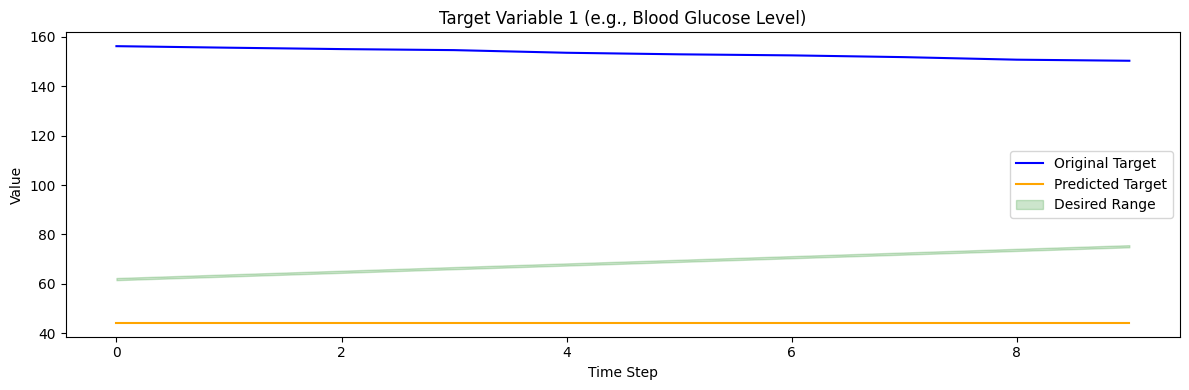

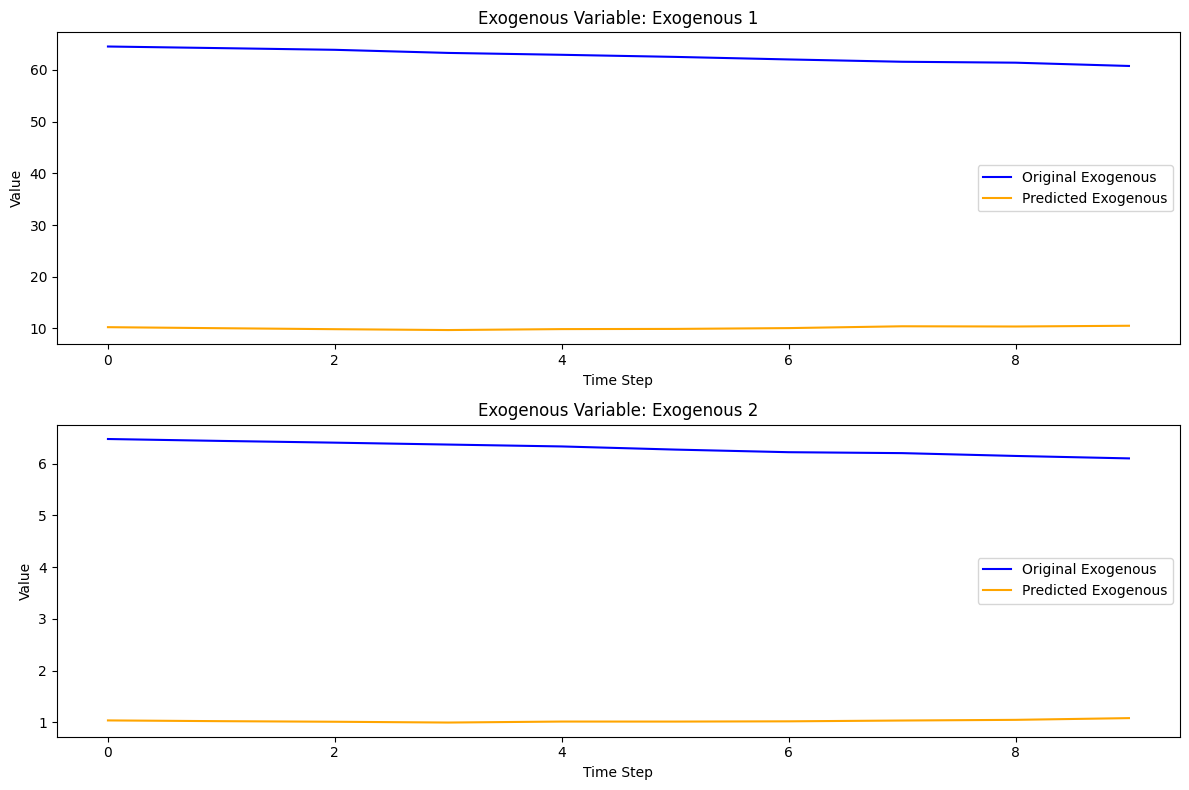

{'var_0': {'MAE': 52.62646493911743, 'Max Dev': 54.29628658294678, 'Mean % Change': 83.89242694416124}, 'var_1': {'MAE': 5.265851074457169, 'Max Dev': 5.435969233512878, 'Mean % Change': 83.63337183168994}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([109.22049103]), 'RMSE': array([109.2375264]), 'Max Dev': array([112.11501312]), 'MAPE (%)': array([71.20098085])}


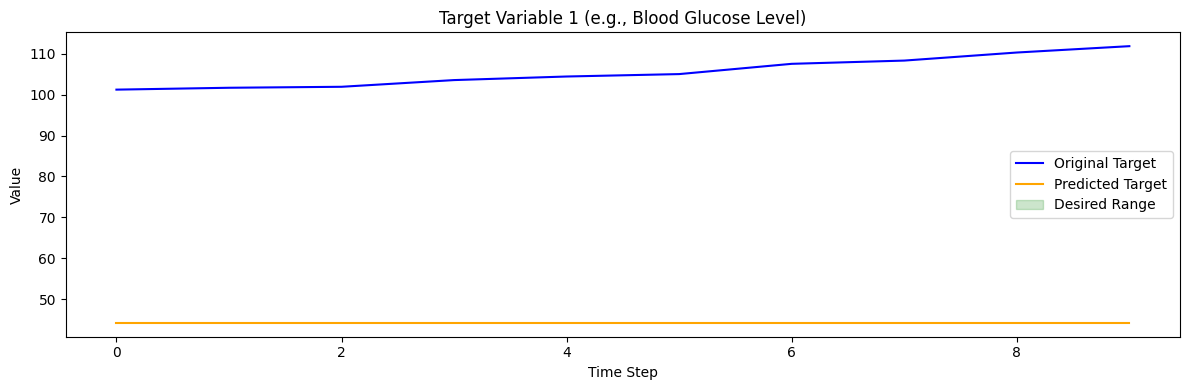

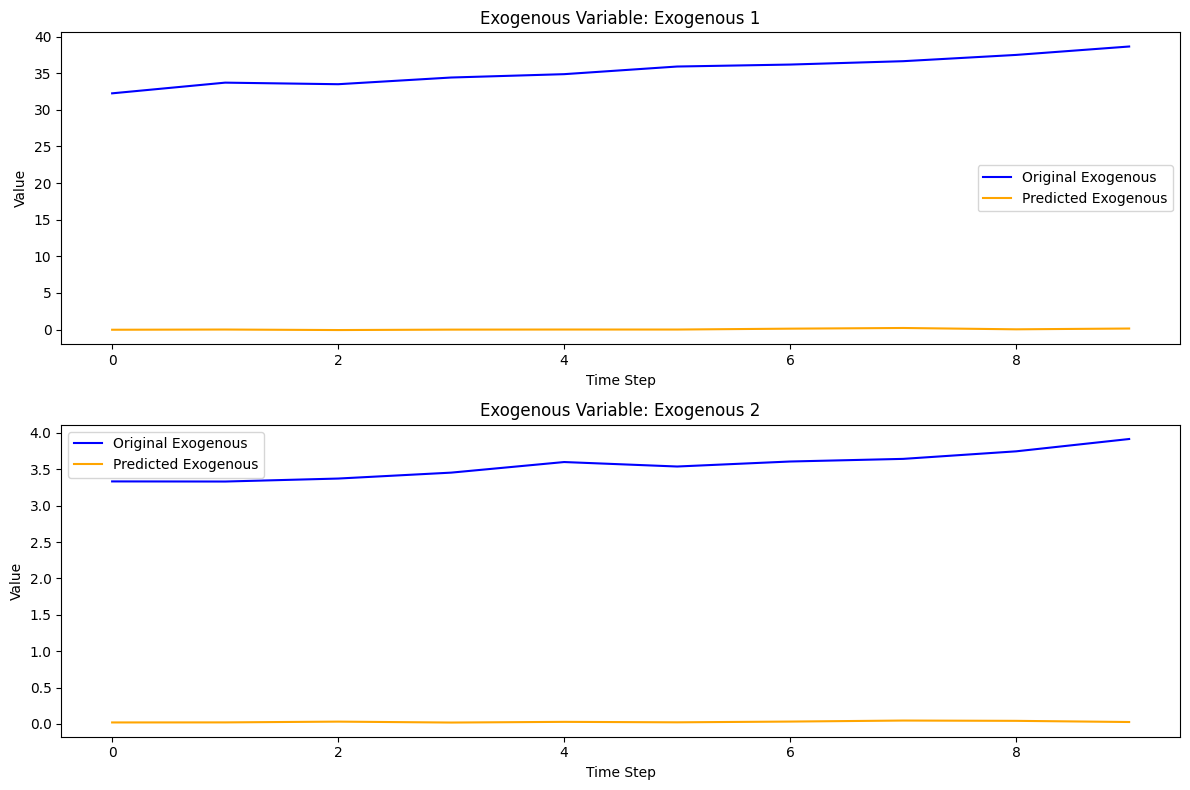

{'var_0': {'MAE': 35.33708145711571, 'Max Dev': 38.52216650545597, 'Mean % Change': 99.90713792993617}, 'var_1': {'MAE': 3.5244789393618703, 'Max Dev': 3.889061141759157, 'Mean % Change': 99.18259724637666}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([61.4356636]), 'RMSE': array([61.53844643]), 'Max Dev': array([67.70561981]), 'MAPE (%)': array([58.12930029])}


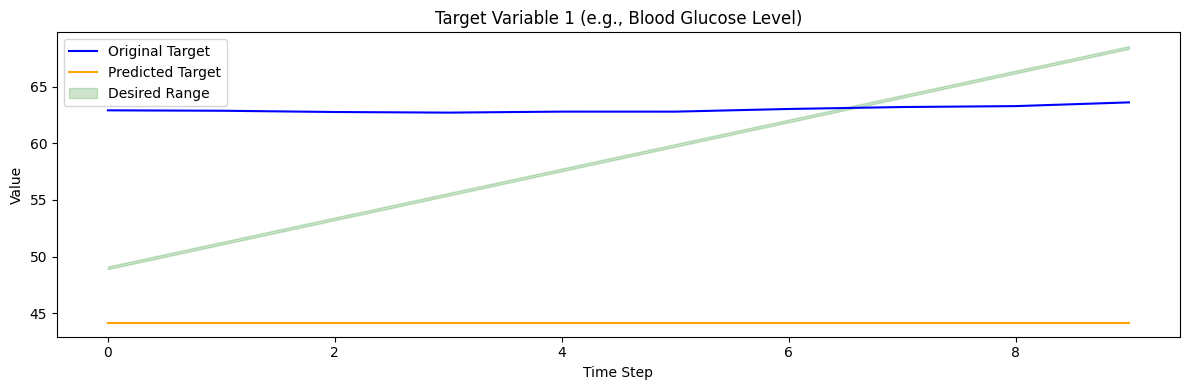

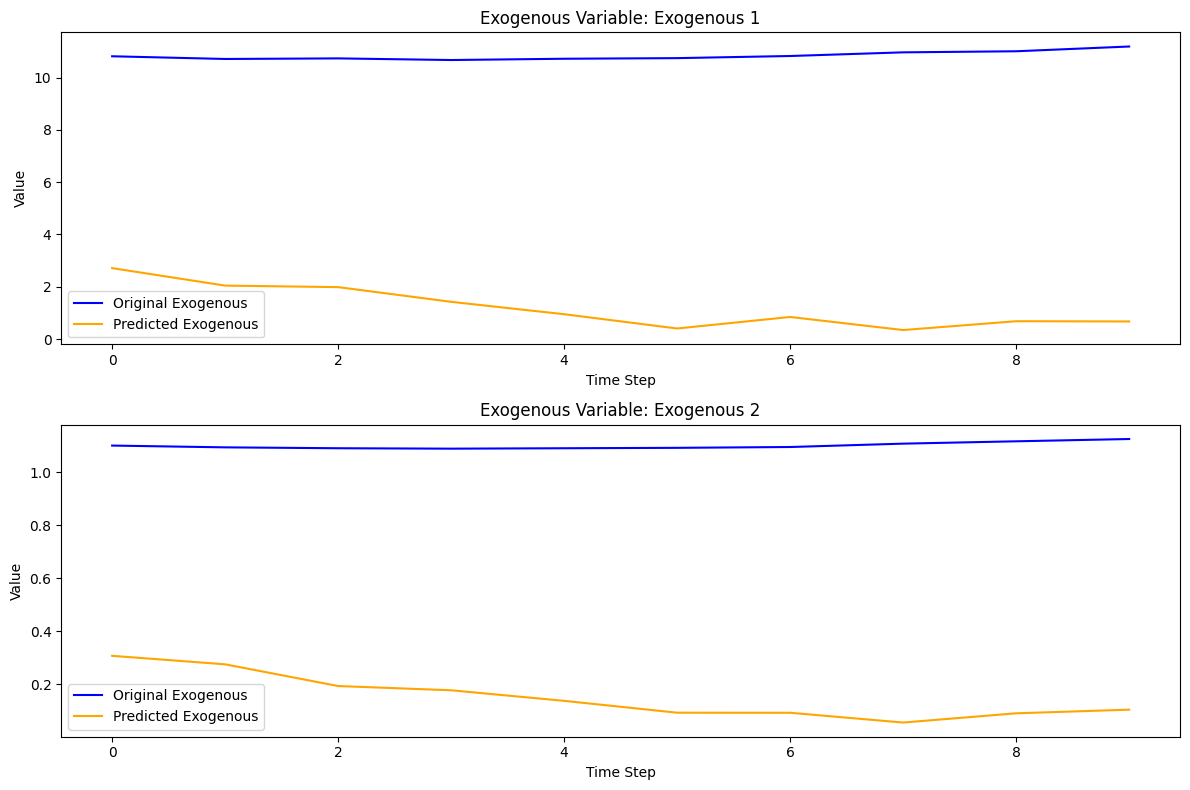

{'var_0': {'MAE': 9.62965344786644, 'Max Dev': 10.618485689163208, 'Mean % Change': 88.82337833519463}, 'var_1': {'MAE': 0.9485990986227989, 'Max Dev': 1.053460031747818, 'Mean % Change': 86.13697352894818}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([18.82012672]), 'RMSE': array([18.82209767]), 'Max Dev': array([19.43354416]), 'MAPE (%)': array([29.87795189])}


In [72]:
plot_simulation_results(
    sim_transformed_targets=sim_transformed_targets_ols,
    sim_transformed_orig_targets=sim_transformed_orig_targets_ols,
    sim_transformed_exogs=sim_transformed_exogs_ols,
    sim_transformed_orig_exogs=sim_transformed_orig_exogs_ols,
    desired_min=numpy_desired_min,
    desired_max=numpy_desired_max,
    method="ols",
    dataset_name="simluated",
    save_prefix="sim",
    num_samples=3
)

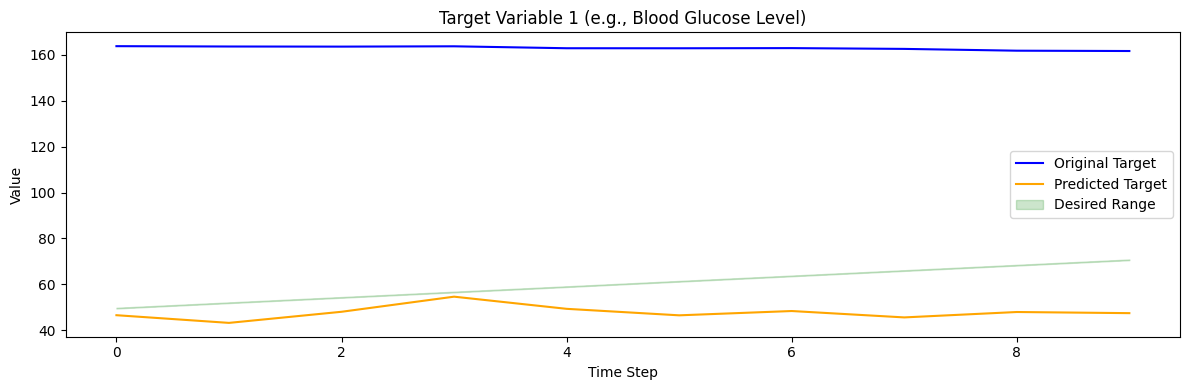

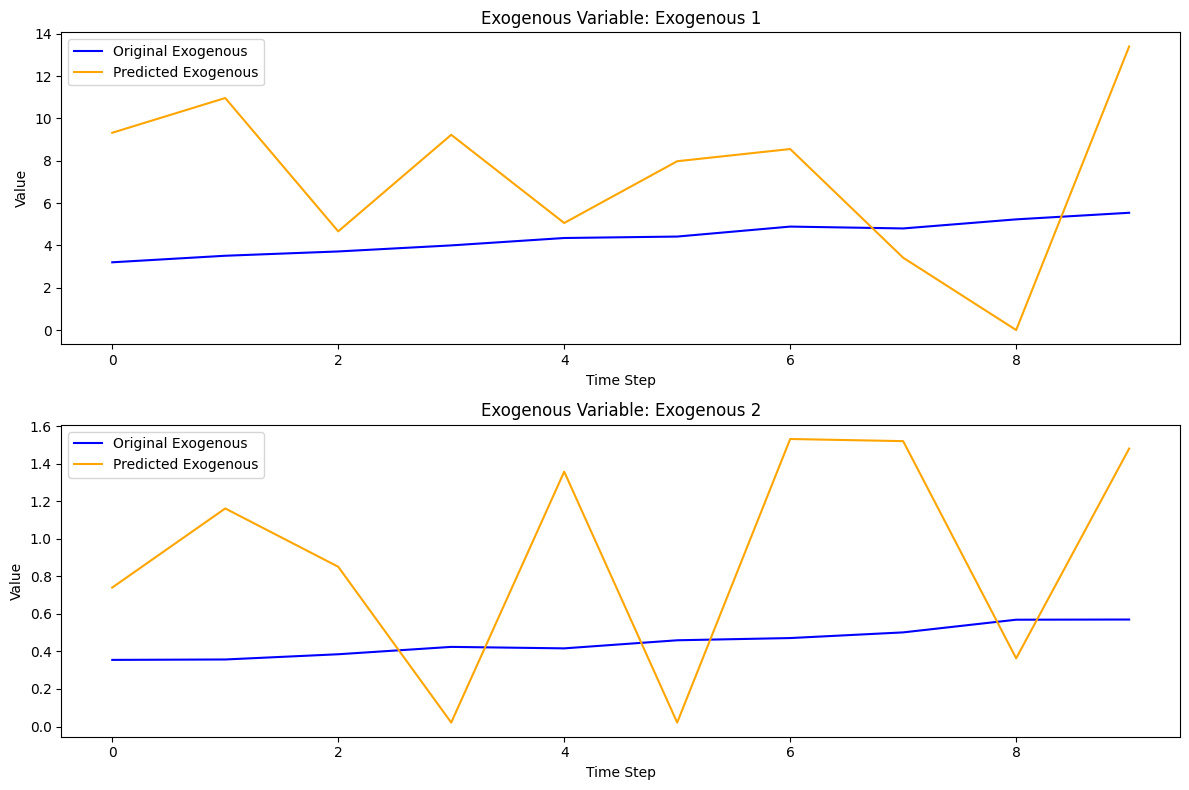

{'var_0': {'MAE': 4.214654064178466, 'Max Dev': 7.854888916015625, 'Mean % Change': 100.22003452486307}, 'var_1': {'MAE': 0.6637329436838627, 'Max Dev': 1.0608416199684143, 'Mean % Change': 149.56701625198204}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([115.11964188]), 'RMSE': array([115.15404105]), 'Max Dev': array([120.36034393]), 'MAPE (%)': array([70.66364844])}


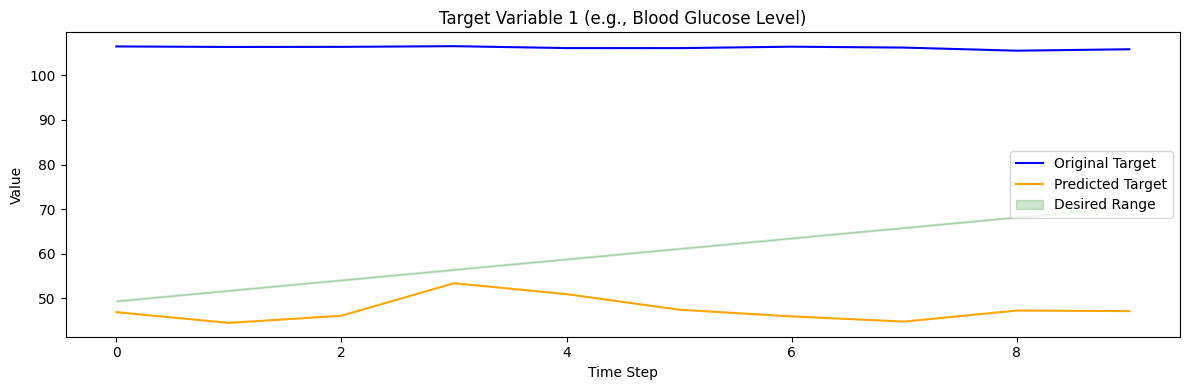

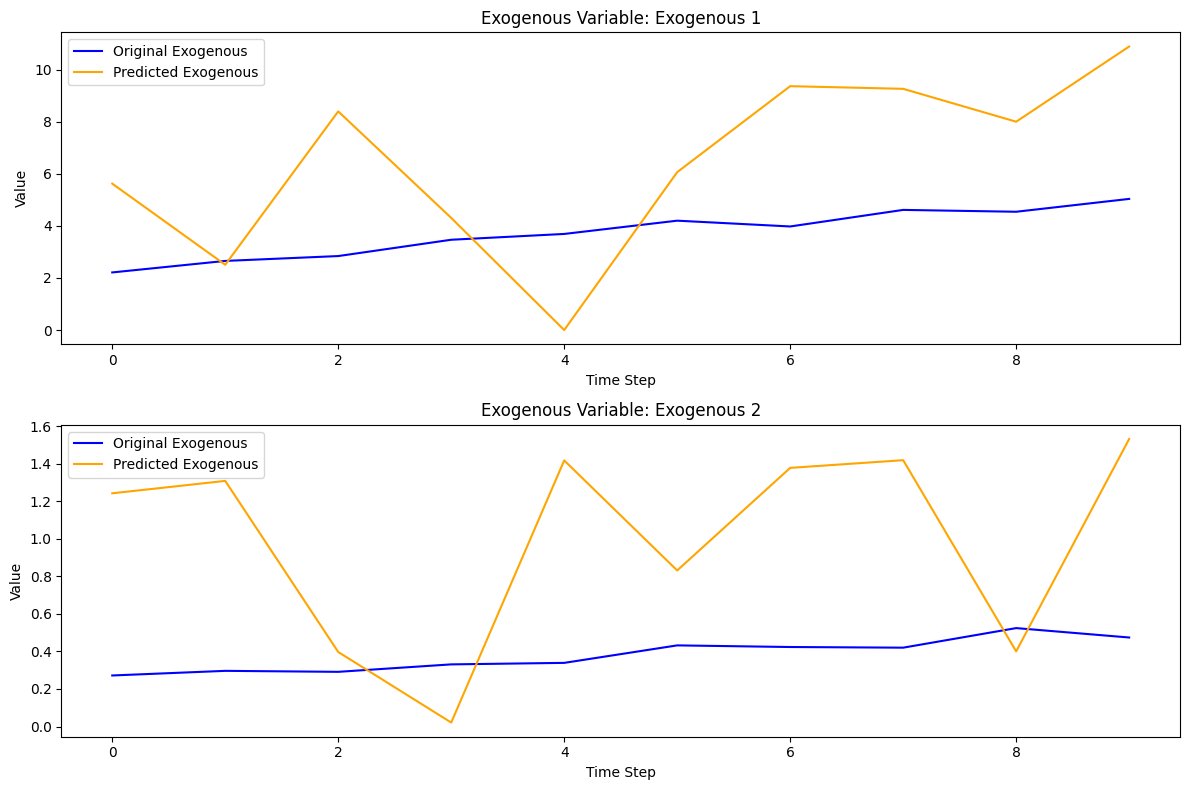

{'var_0': {'MAE': 3.4850565910339357, 'Max Dev': 5.851730823516846, 'Mean % Change': 95.23117905958178}, 'var_1': {'MAE': 0.700943835452199, 'Max Dev': 1.078375667333603, 'Mean % Change': 194.84172144810037}}
{'In-Bound %': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([58.83443336]), 'RMSE': array([58.89174299]), 'Max Dev': array([61.94546509]), 'MAPE (%)': array([55.38234079])}


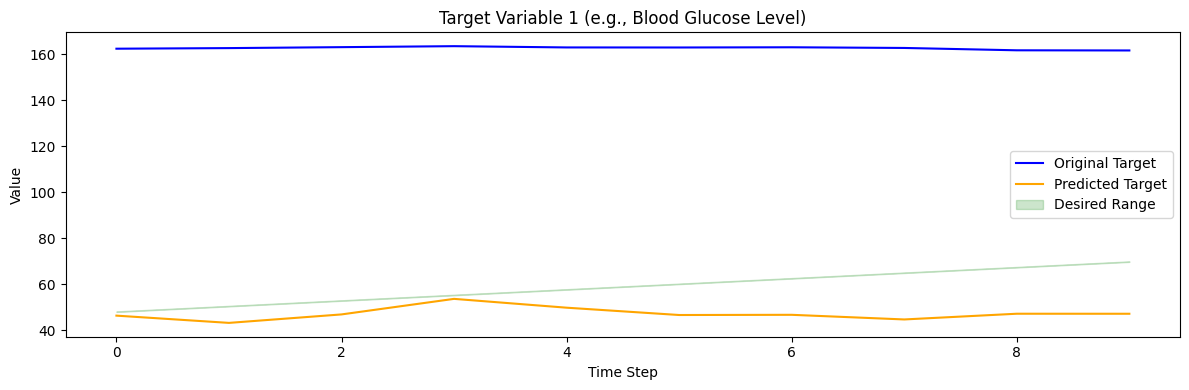

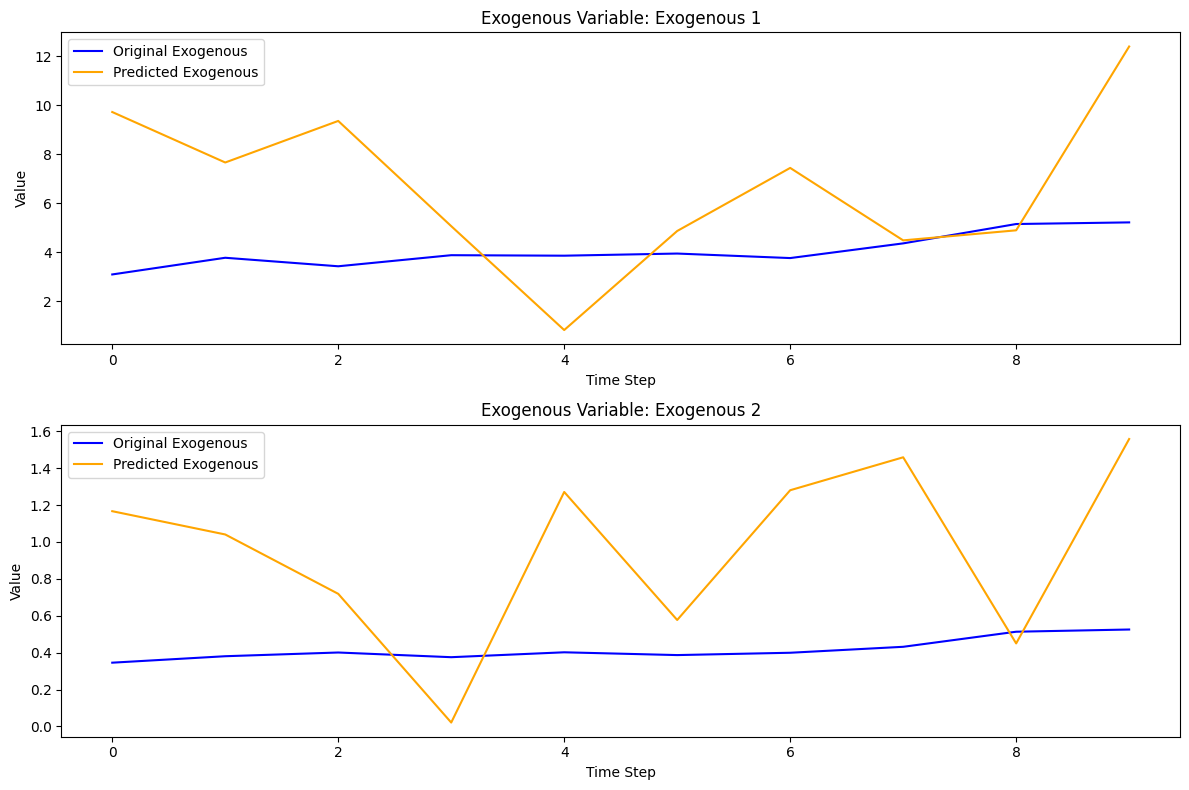

{'var_0': {'MAE': 3.2785942375659944, 'Max Dev': 7.168860912322998, 'Mean % Change': 86.41712635122549}, 'var_1': {'MAE': 0.6217965532094241, 'Max Dev': 1.03279447555542, 'Mean % Change': 151.75186345354066}}
{'In-Bound %': array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'Mean Violation': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]]), 'Total Violation Area': array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])}
{'MAE': array([115.39993477]), 'RMSE': array([115.42743966]), 'Max Dev': array([119.42643356]), 'MAPE (%)': array([70.91802469])}


In [73]:
plot_simulation_results(
    sim_transformed_targets=sim_transformed_targets_nbeats,
    sim_transformed_orig_targets=sim_transformed_orig_targets_nbeats,
    sim_transformed_exogs=sim_transformed_exogs_nbeats,
    sim_transformed_orig_exogs=sim_transformed_orig_exogs_nbeats,
    desired_min=numpy_desired_min,
    desired_max=numpy_desired_max,
    method="nbeats",
    dataset_name="simluated",
    save_prefix="sim",
    num_samples=3
)

In [30]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import euclidean, cosine
from sklearn.metrics import pairwise_distances

from sklearn.metrics import r2_score

def compute_r2_score(orig_targets, cf_targets):
    """
    Compute the coefficient of determination (R²) between original and counterfactual target time series.
    
    Args:
        orig_targets: np.ndarray of shape (samples, timesteps)
        cf_targets: np.ndarray of shape (samples, timesteps)
        
    Returns:
        avg_r2: float, average R² score over all samples
        r2_scores: list of R² scores per sample
    """
    assert orig_targets.shape == cf_targets.shape, "Shape mismatch between original and counterfactual targets."
    r2_scores = []
    for i in range(orig_targets.shape[0]):
        r2 = r2_score(orig_targets[i], cf_targets[i])
        r2_scores.append(r2)
    avg_r2 = np.mean(r2_scores)
    return avg_r2, r2_scores


def is_nonempty_series(series):
    return np.any(np.abs(series) > 1e-5)

def compute_norm_factor(data, method="std"):
    """
    Compute normalization factor per feature over all samples and timesteps.

    Args:
        data: np.ndarray, shape [samples, time, features]
        method: str, "std" or "range"

    Returns:
        norm_factors: np.ndarray of shape (features,)
    """
    num_features = data.shape[2]
    norm_factors = np.zeros(num_features)

    for f in range(num_features):
        flat = data[:, :, f].reshape(-1)
        if method == "std":
            val = np.std(flat)
        elif method == "range":
            val = np.ptp(flat)
        else:
            raise ValueError("Normalization method must be 'std' or 'range'")
        norm_factors[f] = val if val > 0 else 1.0
    return norm_factors


def compare_closest_healthy_pairs(
    orig_targets, pred_targets, orig_exogs, pred_exogs,
    dataset_name="dataset", top_k=5, labels=None, norm_method="std"
):
    """
    Compare counterfactuals to healthy samples by finding target-level similarity.

    Args:
        orig_targets (np.ndarray): Original/healthy target time series [samples, time]
        pred_targets (np.ndarray): Counterfactual/predicted target time series [samples, time]
        orig_exogs (np.ndarray): Original/healthy exogenous input [samples, time, features]
        pred_exogs (np.ndarray): Counterfactual/predicted exogenous input [samples, time, features]
        dataset_name (str): Dataset name for saving figures
        top_k (int): Number of closest target matches to compare
        labels (List[str]): List of exogenous feature names
    """
    # Prepare dimensions
    orig_targets = np.atleast_2d(orig_targets.squeeze())
    pred_targets = np.atleast_2d(pred_targets.squeeze())
    dist_matrix = pairwise_distances(orig_targets, pred_targets, metric='euclidean')

    # Avoid self-pairs if data is the same
    if np.array_equal(orig_targets, pred_targets):
        np.fill_diagonal(dist_matrix, np.inf)

    flat_indices = np.argsort(dist_matrix, axis=None)[:top_k]
    closest_pairs = list(zip(*np.unravel_index(flat_indices, dist_matrix.shape)))

    if labels is None:
        labels = [f"Feature {i}" for i in range(orig_exogs.shape[2])]
    
    norm_factors = compute_norm_factor(orig_exogs, method=norm_method)

    exog_distances_per_feature = []

    for rank, (orig_idx, pred_idx) in enumerate(closest_pairs, 1):
        orig_target = orig_targets[orig_idx]
        pred_target = pred_targets[pred_idx]
        target_distance = np.linalg.norm(orig_target - pred_target)

        if not (is_nonempty_series(orig_target) and is_nonempty_series(pred_target)):
            print(f"Skipping rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}): Empty or invalid target.")
            continue

        print(f"Pair {rank} (Orig idx: {orig_idx}, Pred idx: {pred_idx}) Target Euclidean distance: {target_distance:.4f}")

        # --- Plot targets ---
        plt.figure(figsize=(12, 5))
        time_axis = range(orig_target.shape[0])
        plt.plot(time_axis, orig_target, label='Healthy Target', color='green')
        plt.plot(time_axis, pred_target, label='CF Target', color='orange')
        plt.title(f"Target Comparison: Orig {orig_idx} vs CF {pred_idx}")
        plt.xlabel("Time Step")
        plt.ylabel("Blood Glucose Level")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"comparison_target_{dataset_name}_{orig_idx}_{pred_idx}.png")
        #plt.show()

        # --- Plot exogenous features ---
        orig_exog = orig_exogs[orig_idx]
        pred_exog = pred_exogs[pred_idx]

        if not (is_nonempty_series(orig_exog) and is_nonempty_series(pred_exog)):
            print(f"Skipping exog plot rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}) due to empty values.")
            continue

        num_features = orig_exog.shape[1]
        plt.figure(figsize=(14, 2.5 * num_features))
        for f in range(num_features):
            plt.subplot(num_features, 1, f + 1)
            plt.plot(orig_exog[:, f], label='Healthy Exog', color='green')
            plt.plot(pred_exog[:, f], label='CF Exog', color='orange')
            plt.ylabel(labels[f])
            if f == 0:
                plt.title(f'Exogenous Comparison: Rank {rank} – Orig {orig_idx} vs CF {pred_idx}')
            if f == num_features - 1:
                plt.xlabel('Time Step')
            plt.legend()
        plt.tight_layout()
        plt.savefig(f"comparison_exog_{dataset_name}_{orig_idx}_{pred_idx}.png")
        #plt.show()
        
        # Compute distances
        distances = []
        norm_distances = []
        for f in range(num_features):
            dist = np.linalg.norm(orig_exog[:, f] - pred_exog[:, f])
            distances.append(dist)
            norm_distances.append(dist / norm_factors[f])
            print(f"  Feature {f + 1} ({labels[f]}): Euclidean Distance = {dist:.4f}, Normalized = {dist / norm_factors[f]:.4f}")

        exog_distances_per_feature.append({
            "pair": (orig_idx, pred_idx),
            "raw_distances": distances,
            "normalized_distances": norm_distances
        })

    return exog_distances_per_feature


def compute_normalized_per_feature_euclidean(orig_exog, cf_exog, feature_names=None, method="std"):
    """
    Computes normalized per-feature Euclidean distance between original and counterfactual exogenous variables.

    Parameters:
        orig_exog: np.ndarray of shape (samples, timesteps, features)
        cf_exog: np.ndarray of same shape
        feature_names: optional list of feature names
        method: "std" (standard deviation) or "range" for normalization

    Returns:
        List of normalized Euclidean distances per feature.
    """
    assert orig_exog.shape == cf_exog.shape, "Shape mismatch between original and counterfactual inputs."
    
    num_features = orig_exog.shape[2]
    distances = []

    for feature_idx in range(num_features):
        # Flatten across samples and time for normalization calculation
        orig_flat = orig_exog[:, :, feature_idx].reshape(-1)

        if method == "std":
            norm_factor = np.std(orig_flat)
        elif method == "range":
            norm_factor = np.ptp(orig_flat)  # peak-to-peak (max - min)
        else:
            raise ValueError("Unsupported normalization method. Use 'std' or 'range'.")

        # Prevent division by zero
        norm_factor = norm_factor if norm_factor > 0 else 1.0

        # Compute per-sample Euclidean distance for this feature
        per_sample_dist = np.linalg.norm(
            orig_exog[:, :, feature_idx] - cf_exog[:, :, feature_idx],
            axis=1
        )
        normalized_dist = np.mean(per_sample_dist) / norm_factor
        distances.append(normalized_dist)

        if feature_names:
            print(f"Feature {feature_names[feature_idx]} - Normalized Euclidean Distance: {normalized_dist:.4f}")
        else:
            print(f"Feature {feature_idx} - Normalized Euclidean Distance: {normalized_dist:.4f}")

    return distances

def compute_per_feature_euclidean(orig_exog, cf_exog, feature_names=None):
    """
    Computes per-feature Euclidean distance between original and counterfactual exogenous sequences.

    Parameters:
        orig_exog: np.ndarray of shape (samples, timesteps, features)
        cf_exog: np.ndarray of same shape
        feature_names: Optional list of feature names

    Returns:
        A list of per-feature Euclidean distances averaged across all samples.
    """
    assert orig_exog.shape == cf_exog.shape, "Shape mismatch between original and counterfactual inputs."
    
    num_features = orig_exog.shape[2]
    distances = []

    for feature_idx in range(num_features):
        # Compute per-sample Euclidean distance for this feature
        per_sample_dist = np.linalg.norm(
            orig_exog[:, :, feature_idx] - cf_exog[:, :, feature_idx],
            axis=1  # across time
        )
        avg_dist = np.mean(per_sample_dist)
        distances.append(avg_dist)

        if feature_names:
            print(f"Feature {feature_names[feature_idx]} - Avg Euclidean Distance: {avg_dist:.4f}")
        else:
            print(f"Feature {feature_idx} - Avg Euclidean Distance: {avg_dist:.4f}")

    return distances


def find_closest_targets_exog(reference_targets, all_targets, all_exogs, top_k=1):
    """Find the closest target profiles and return their corresponding exogenous variables."""
    if reference_targets.ndim == 2:
        reference_targets = reference_targets.reshape(reference_targets.shape[0], -1)
    if all_targets.ndim == 2:
        all_targets = all_targets.reshape(all_targets.shape[0], -1)

    dist_matrix = pairwise_distances(reference_targets, all_targets, metric='euclidean')

    # Avoid matching to self
    if np.array_equal(reference_targets, all_targets):
        np.fill_diagonal(dist_matrix, np.inf)

    closest_indices = np.argsort(dist_matrix, axis=1)[:, :top_k]

    # Return the average of the top_k closest exogenous profiles
    healthy_like_exogs = np.array([
        np.mean(all_exogs[idxs], axis=0) for idxs in closest_indices
    ])
    return healthy_like_exogs

def evaluate_counterfactuals_with_internal_healthy(
    orig_exog, cf_exog, cf_targets, desired_min, desired_max,
    all_targets, all_exogs, k_for_healthy=1
):
    """
    Internal 'healthy' baseline: find closest target matches in original data.
    """

    # Step 1: Estimate healthy-like exogs based on target similarity
    healthy_exog = find_closest_targets_exog(cf_targets, all_targets, all_exogs, top_k=k_for_healthy)

    # Step 2: Proceed with the same evaluation
    results = {}
    feature_names = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]

    diff = cf_exog - orig_exog
    avg_change = np.mean(np.abs(diff), axis=(0, 1))  # per feature
    euc_dist = compute_per_feature_euclidean(orig_exog, cf_exog, feature_names)
    euc_dist_norm = compute_normalized_per_feature_euclidean(orig_exog, cf_exog, feature_names)
    results["avg_change_per_feature"] = avg_change.tolist()
    results["euclidean_distance_per_feature"] = euc_dist
    results["euclidean_distance_per_feature_normalized"] = euc_dist_norm

    changed = np.abs(diff) > 1e-3
    fraction_changed = np.sum(changed) / changed.size
    results["fraction_values_changed"] = fraction_changed

    # Severity (Z-score & LOF)
    severity = []
    lof_scores = []
    for i in range(orig_exog.shape[0]):
        for f in range(orig_exog.shape[2]):
            orig = orig_exog[i, :, f]
            new = cf_exog[i, :, f]
            std = np.std(orig) if np.std(orig) > 0 else 1.0
            severity.append(np.mean(np.abs((new - orig) / std)))

            X = np.stack([orig, new], axis=0)
            lof = LocalOutlierFactor(n_neighbors=2)
            lof_score = -lof.fit_predict(X)
            lof_scores.append(np.mean(lof_score))

    results["avg_z_score_change"] = np.mean(severity)
    results["avg_lof_score"] = np.mean(lof_scores)

    # Fitting within bounds
    within_bounds = np.logical_and(cf_targets >= desired_min, cf_targets <= desired_max)
    results["percent_within_bounds"] = 100 * np.mean(within_bounds)

    out_of_bounds = np.where(within_bounds, 0,
                             np.minimum(np.abs(cf_targets - desired_min), np.abs(cf_targets - desired_max)))
    results["violation_rmse"] = np.sqrt(np.mean(out_of_bounds**2))

    # Compare to internally selected healthy-like exog
    healthy_diff = np.mean(np.abs(cf_exog - healthy_exog))
    cosine_sim = np.mean([
        1 - cosine(c.flatten(), h.flatten()) for c, h in zip(cf_exog, healthy_exog)
    ])
    results["mean_abs_diff_to_healthy"] = healthy_diff
    results["cosine_sim_to_healthy"] = cosine_sim

    #r2_avg, r2_per_sample = compute_r2_score(all_targets, cf_targets)
    #results["r2_avg"] = r2_avg
    #results["r2_per_sample"] = r2_per_sample


    return results


In [604]:
desired_min_squeezed = numpy_desired_min.squeeze(-1)
desired_max_squeezed = numpy_desired_max.squeeze(-1)

results = evaluate_counterfactuals_with_internal_healthy(
    orig_exog=sim_transformed_orig_exogs_gru,
    cf_exog=sim_transformed_exogs_gru,
    cf_targets=sim_transformed_targets_gru,
    desired_min=desired_min_squeezed,
    desired_max=desired_max_squeezed,
    all_targets=sim_transformed_orig_targets_gru,
    all_exogs=sim_transformed_orig_exogs_gru,
    k_for_healthy=3
)

# Print all results
print("\n📊 Counterfactual Evaluation Metrics:")
for metric, value in results.items():
    print(f"{metric}: {value}")



Feature basal insulin - Avg Euclidean Distance: 1.2356
Feature bolus insulin - Avg Euclidean Distance: 7.1287
Feature carbohydrates - Avg Euclidean Distance: 59.2930
Feature exercise intensity - Avg Euclidean Distance: 0.5816
Feature basal insulin - Normalized Euclidean Distance: 4.2353
Feature bolus insulin - Normalized Euclidean Distance: 4.4934
Feature carbohydrates - Normalized Euclidean Distance: 4.2498
Feature exercise intensity - Normalized Euclidean Distance: 4.1659

📊 Counterfactual Evaluation Metrics:
avg_change_per_feature: [0.44004766110779503, 2.577443213648318, 21.089972275719045, 0.20761472071540388]
euclidean_distance_per_feature: [1.235574984361495, 7.1286866616270625, 59.292985729401906, 0.5815581564995903]
euclidean_distance_per_feature_normalized: [4.235294074650372, 4.493356631476084, 4.249806422375892, 4.165944419641461]
fraction_values_changed: 0.9979166666666667
avg_z_score_change: 37.99233450479865
avg_lof_score: -1.0
percent_within_bounds: 41.66666666666667
vi

Pair 1 (Orig idx: 70, Pred idx: 46) Target Euclidean distance: 1.7209
  Feature 1 (Basal): Euclidean Distance = 0.8084, Normalized = 2.7711
  Feature 2 (Bolus): Euclidean Distance = 7.6929, Normalized = 4.8490
  Feature 3 (Carbs): Euclidean Distance = 48.4378, Normalized = 3.4718
  Feature 4 (Exercise): Euclidean Distance = 0.3876, Normalized = 2.7764
Pair 2 (Orig idx: 73, Pred idx: 46) Target Euclidean distance: 2.1164
  Feature 1 (Basal): Euclidean Distance = 0.7179, Normalized = 2.4608
  Feature 2 (Bolus): Euclidean Distance = 7.7761, Normalized = 4.9014
  Feature 3 (Carbs): Euclidean Distance = 49.4722, Normalized = 3.5459
  Feature 4 (Exercise): Euclidean Distance = 0.3764, Normalized = 2.6960
Pair 3 (Orig idx: 77, Pred idx: 39) Target Euclidean distance: 2.2299
  Feature 1 (Basal): Euclidean Distance = 1.5801, Normalized = 5.4161
  Feature 2 (Bolus): Euclidean Distance = 11.6026, Normalized = 7.3134
  Feature 3 (Carbs): Euclidean Distance = 75.4905, Normalized = 5.4108
  Feature 

[{'pair': (70, 46),
  'raw_distances': [0.8084284702417573,
   7.692861284333997,
   48.43778724832503,
   0.38758145031835056],
  'normalized_distances': [2.7711246610928733,
   4.848967405603183,
   3.471763427010766,
   2.776408106506222]},
 {'pair': (73, 46),
  'raw_distances': [0.7179039878142032,
   7.77609651132412,
   49.472231761700186,
   0.37635247320110604],
  'normalized_distances': [2.460825562382697,
   4.901432267213908,
   3.5459069177197065,
   2.695970244811646]},
 {'pair': (77, 39),
  'raw_distances': [1.5800536032033852,
   11.602628086076534,
   75.4905012764475,
   0.9714249775632301],
  'normalized_distances': [5.4160951362538885,
   7.313373181873496,
   5.41075834192535,
   6.958723593076663]},
 {'pair': (29, 91),
  'raw_distances': [1.9827308099227914,
   7.910860418652854,
   89.298406976644,
   0.44296838038449826],
  'normalized_distances': [6.7963888531073335,
   4.986376707252038,
   6.400435714423685,
   3.1731678624332327]},
 {'pair': (82, 36),
  'raw_

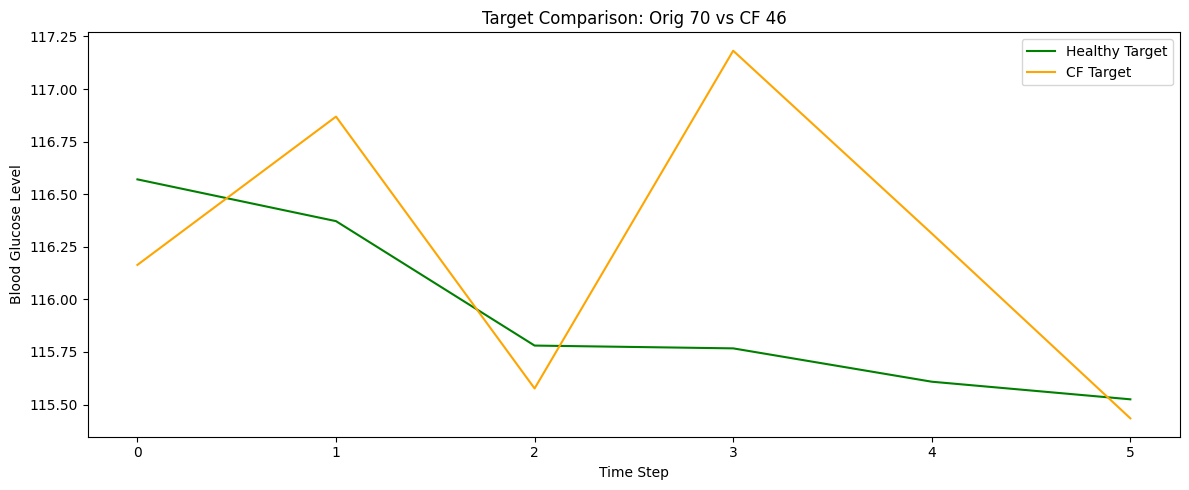

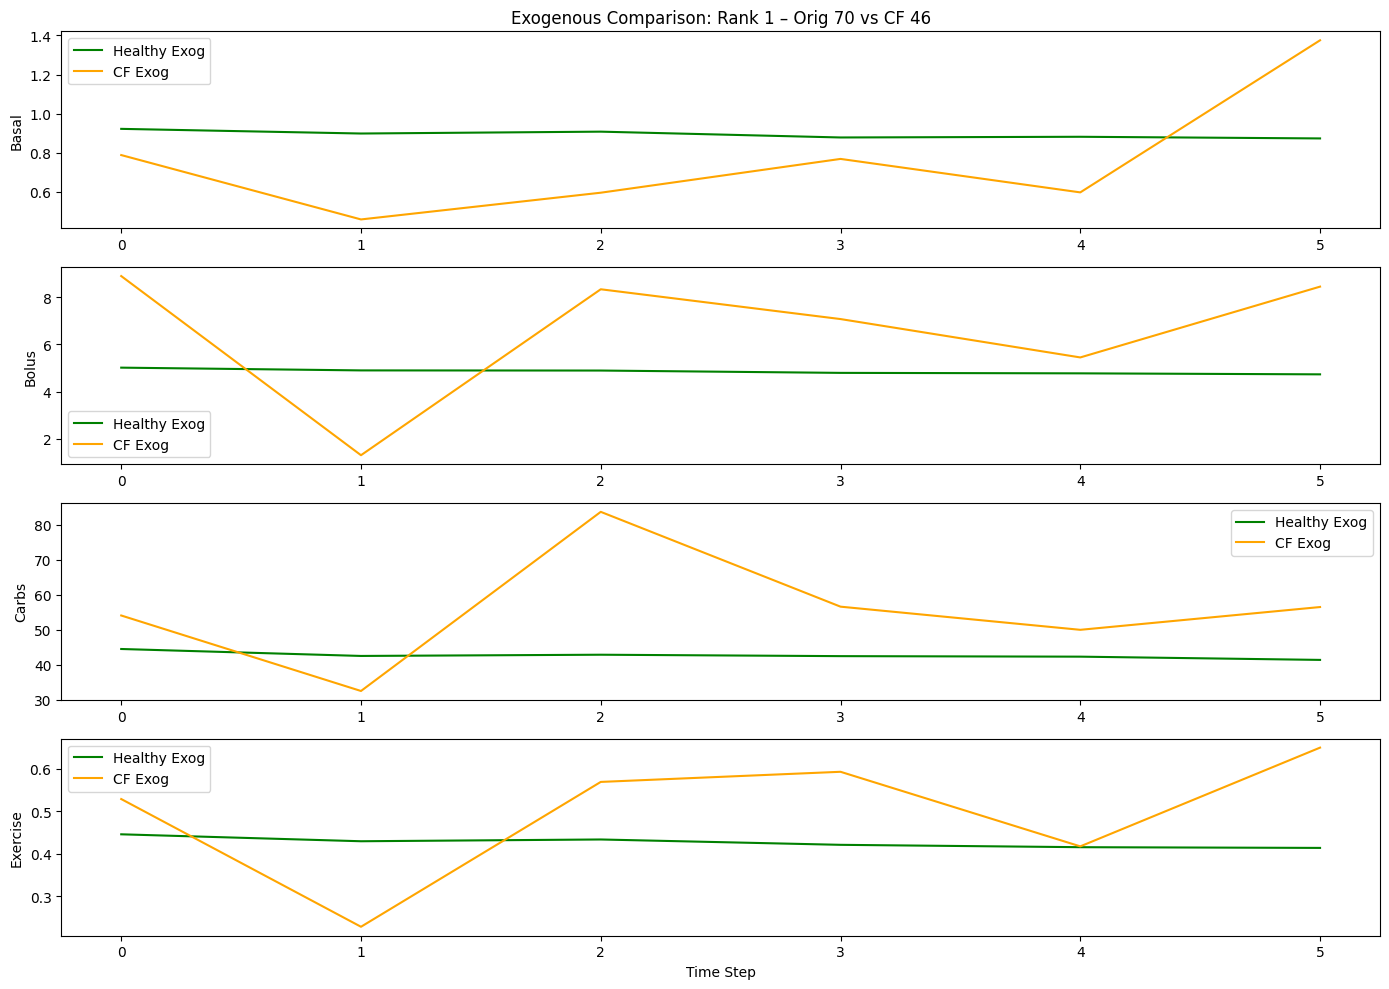

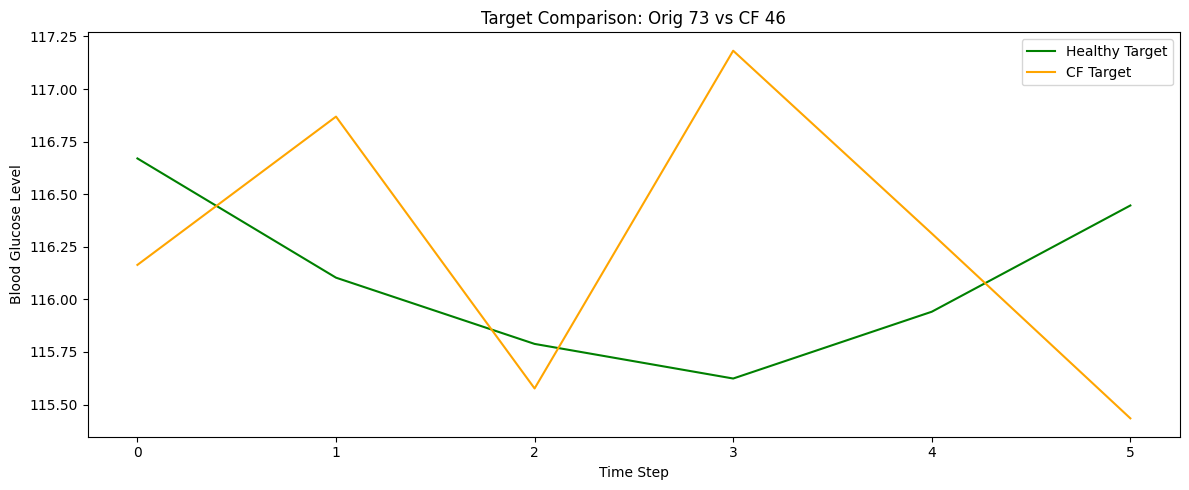

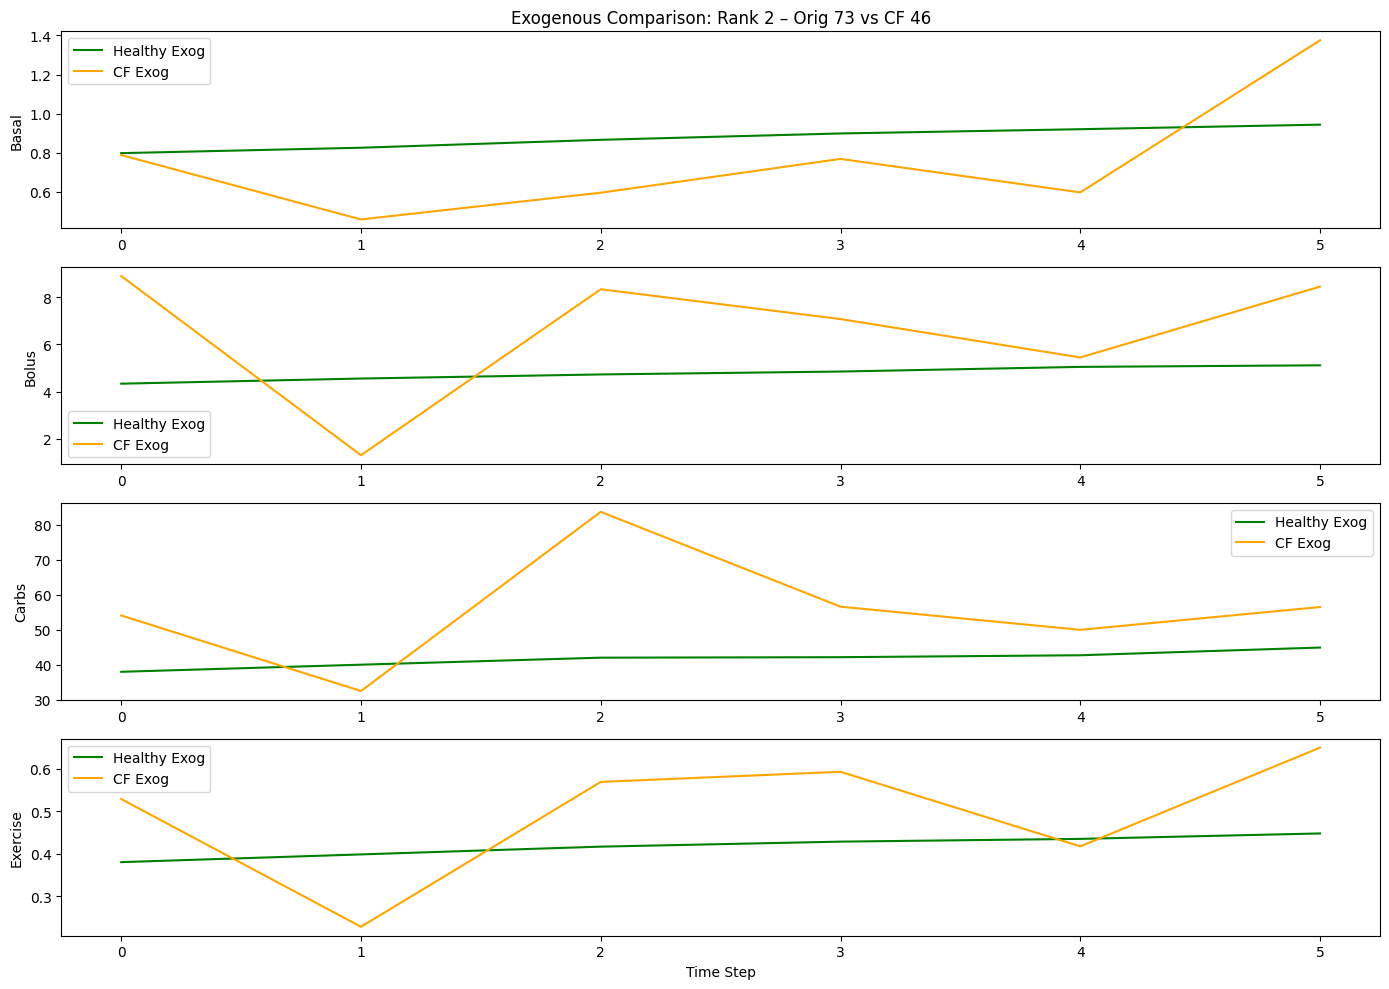

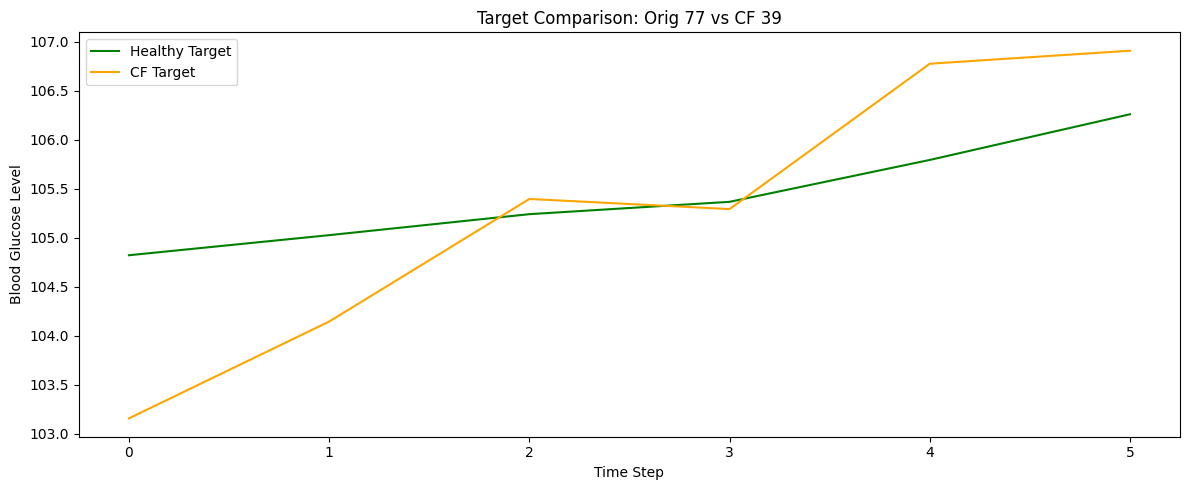

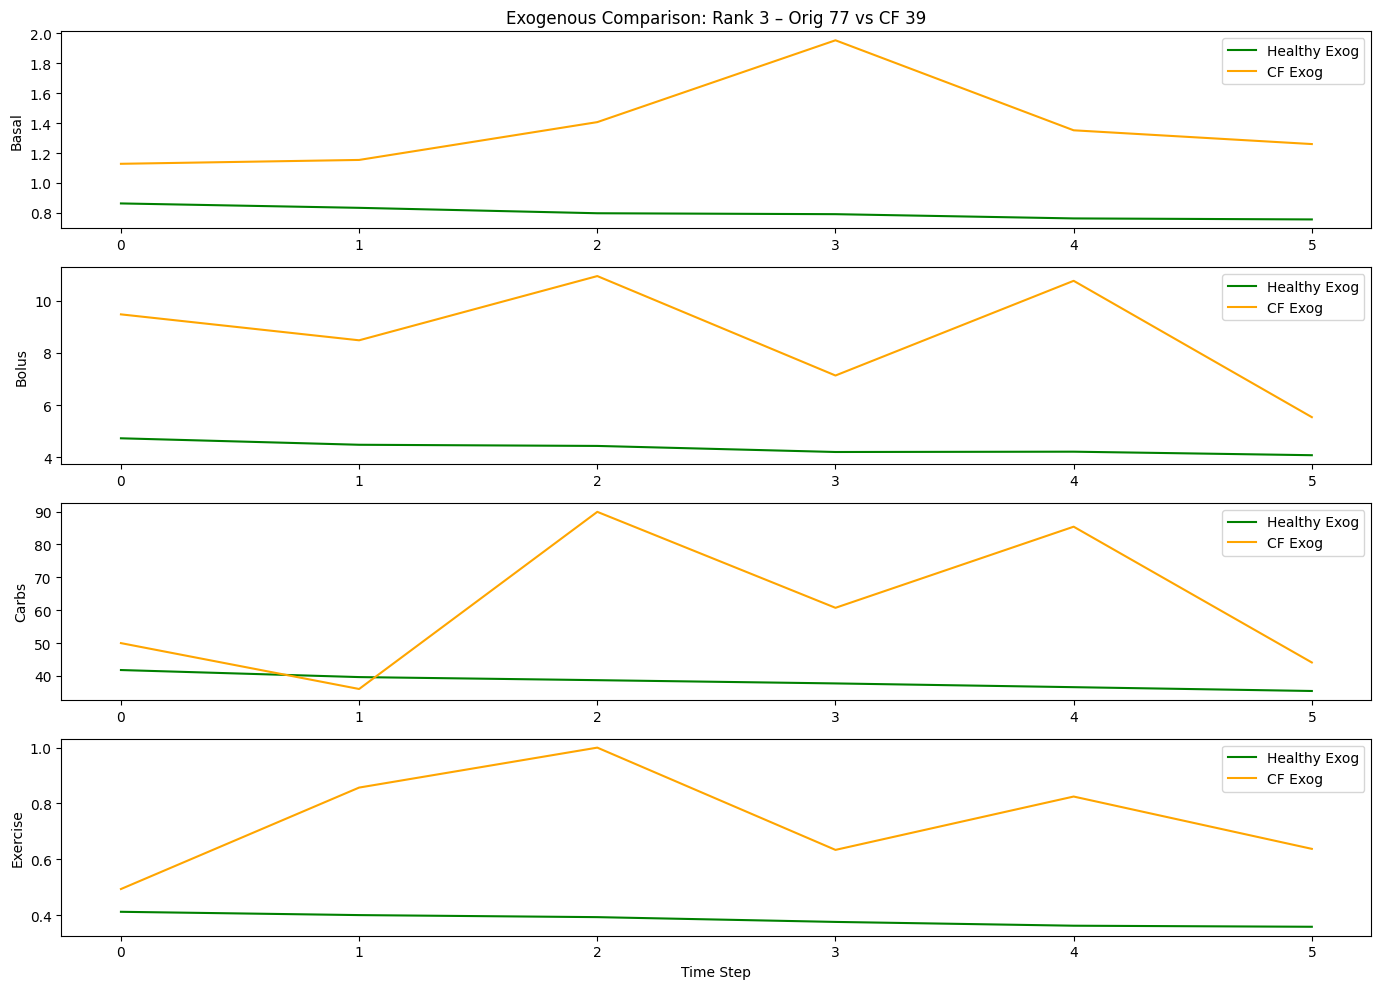

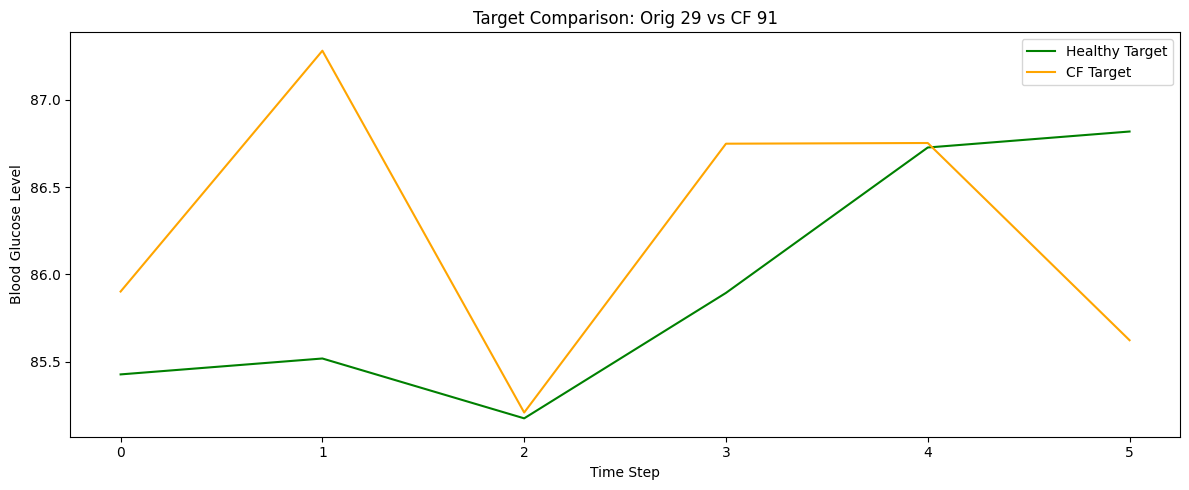

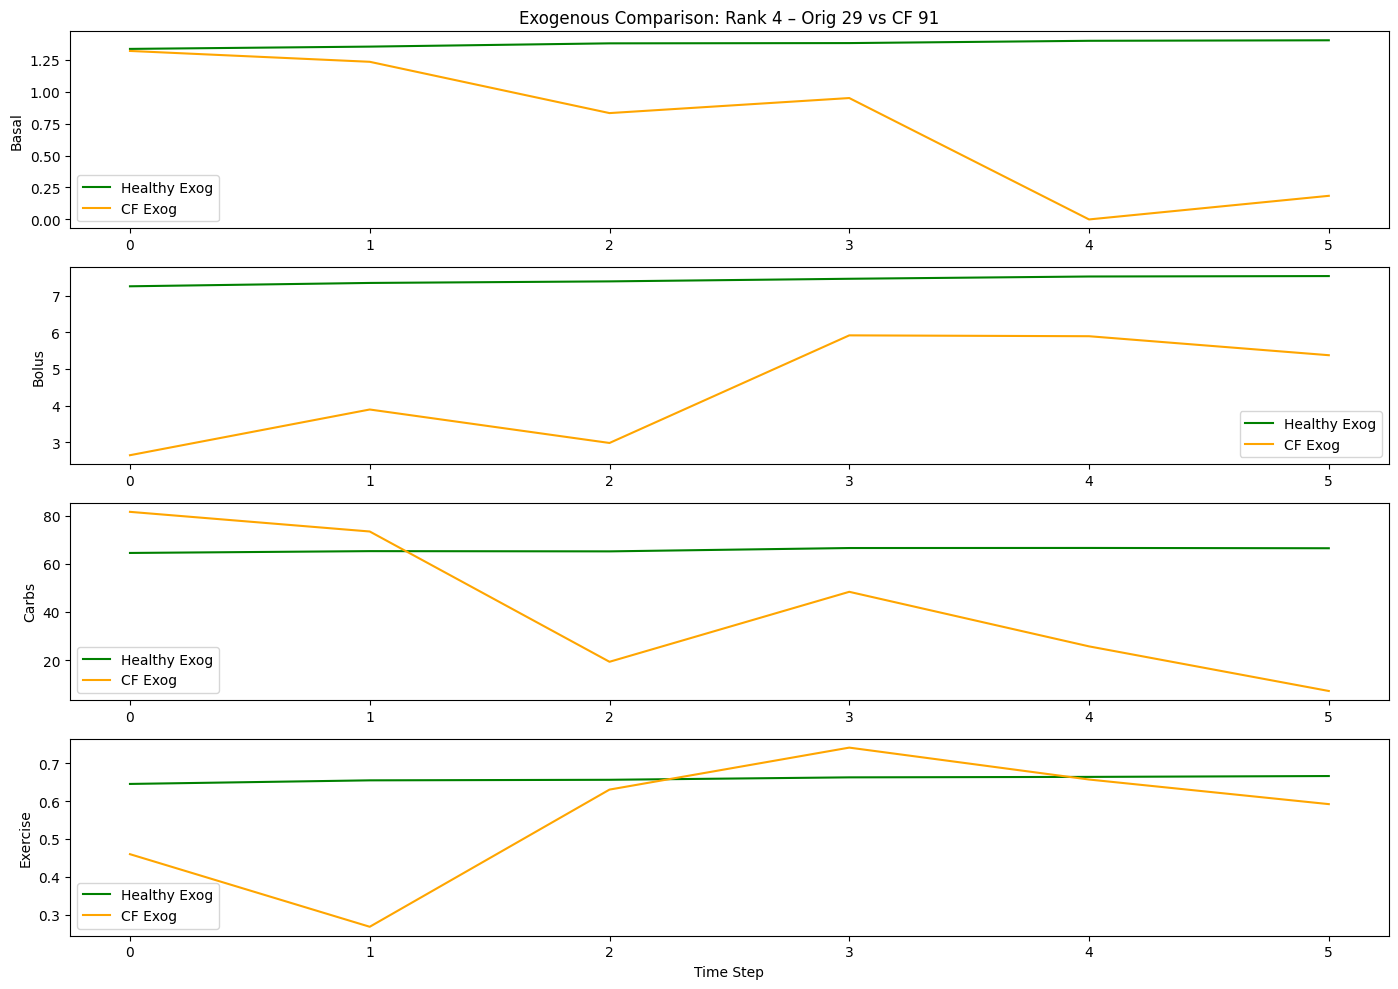

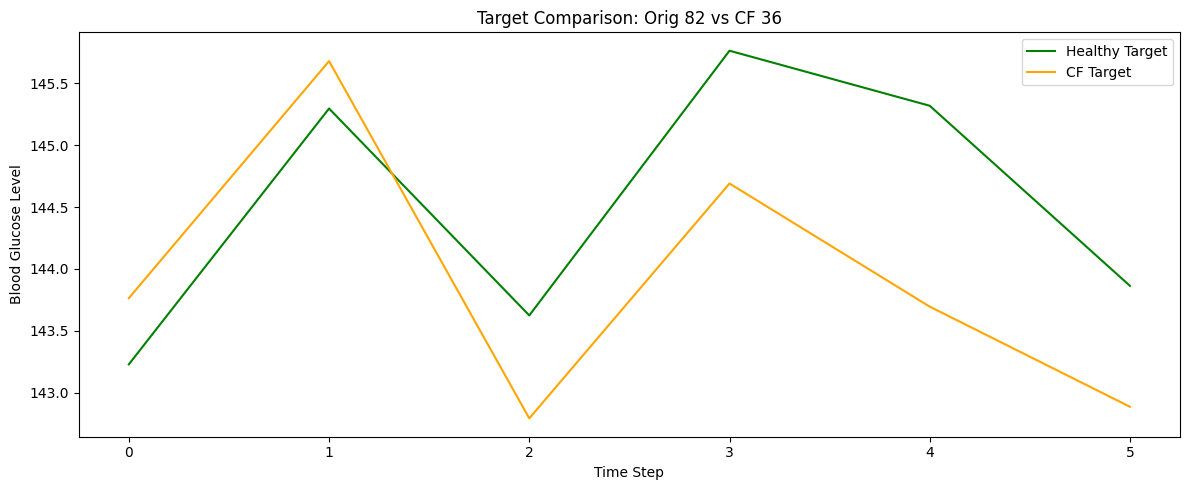

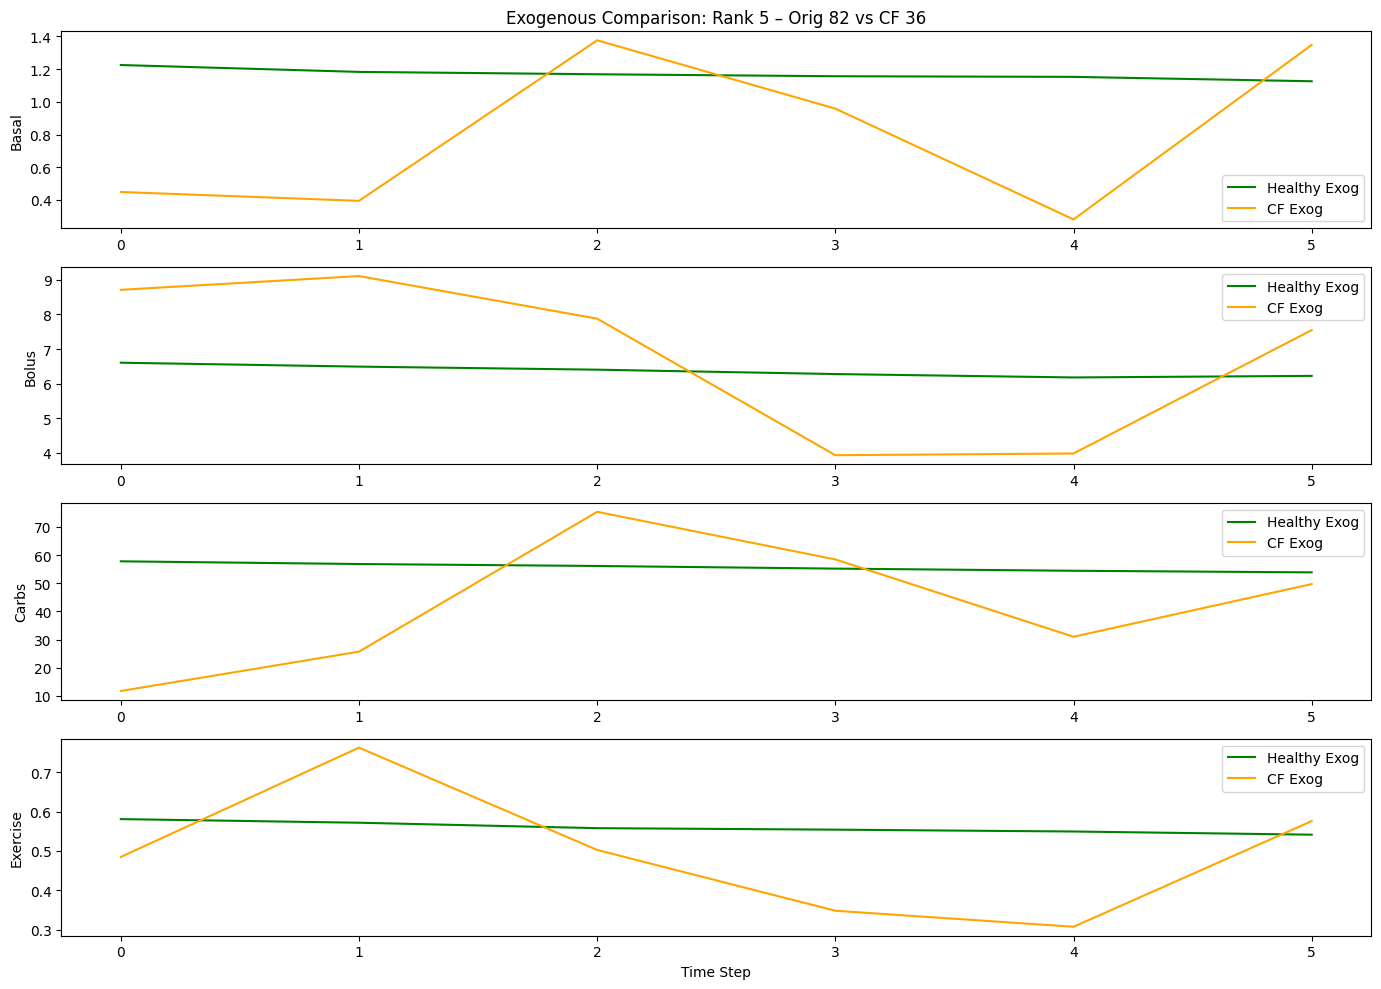

In [605]:
compare_closest_healthy_pairs(
    orig_targets=sim_transformed_orig_targets_gru,
    pred_targets=sim_transformed_targets_gru,
    orig_exogs=sim_transformed_orig_exogs_gru,
    pred_exogs=sim_transformed_exogs_gru,
    dataset_name="ohiot1dm",
    top_k=5,
    labels=["Basal", "Bolus", "Carbs", "Exercise"],
    norm_method="std"
)


[92.96295929 93.3817215  93.4054184  94.37353516 94.57344818 96.78234863] [135.5841217  133.51670837 136.14102173 135.00195312 135.56208801
 136.67474365]


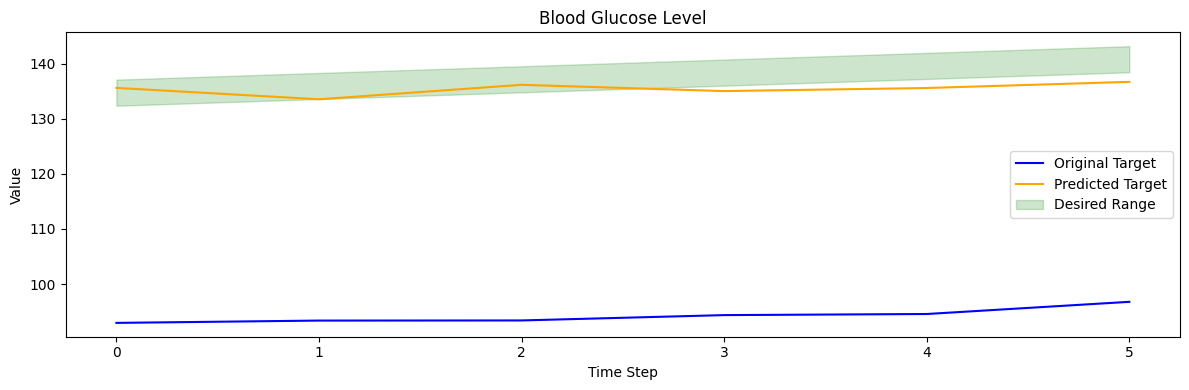

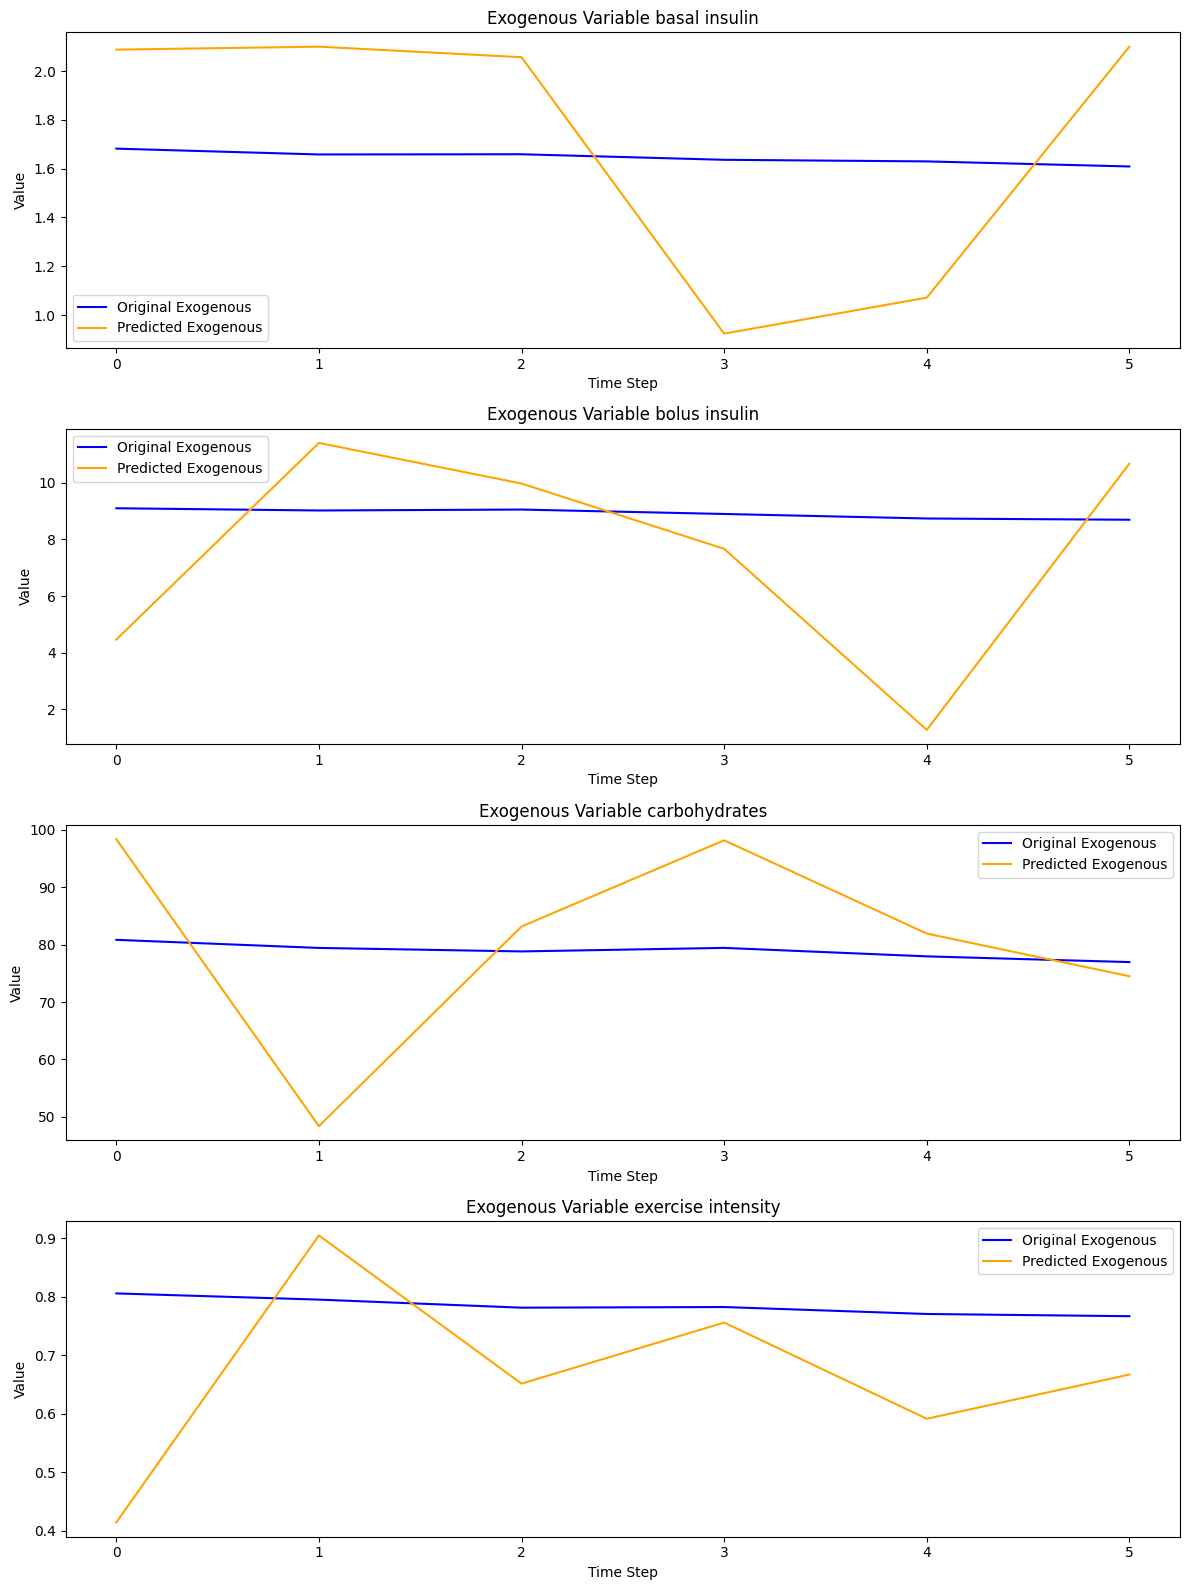

[150.35621643 147.04841614 150.89830017 147.87960815 148.46418762
 147.34849548] [144.94839478 146.53074646 144.11100769 146.9072113  144.0018158
 145.25245667]


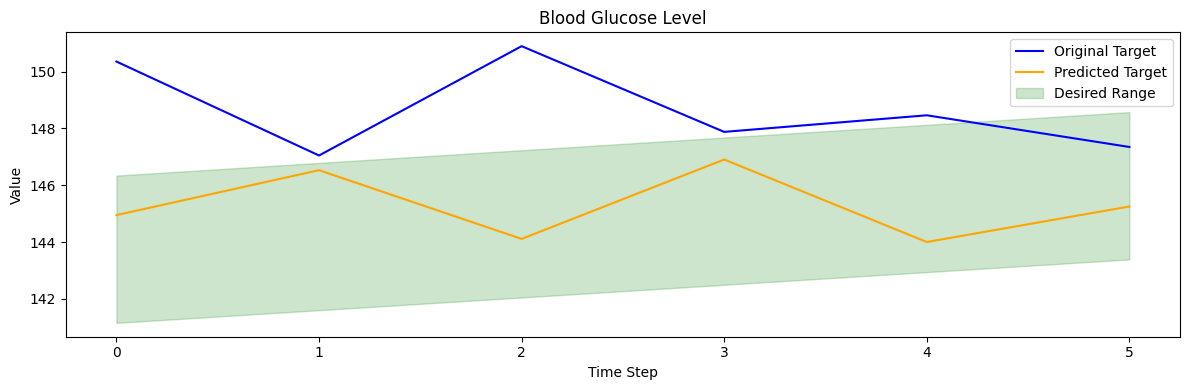

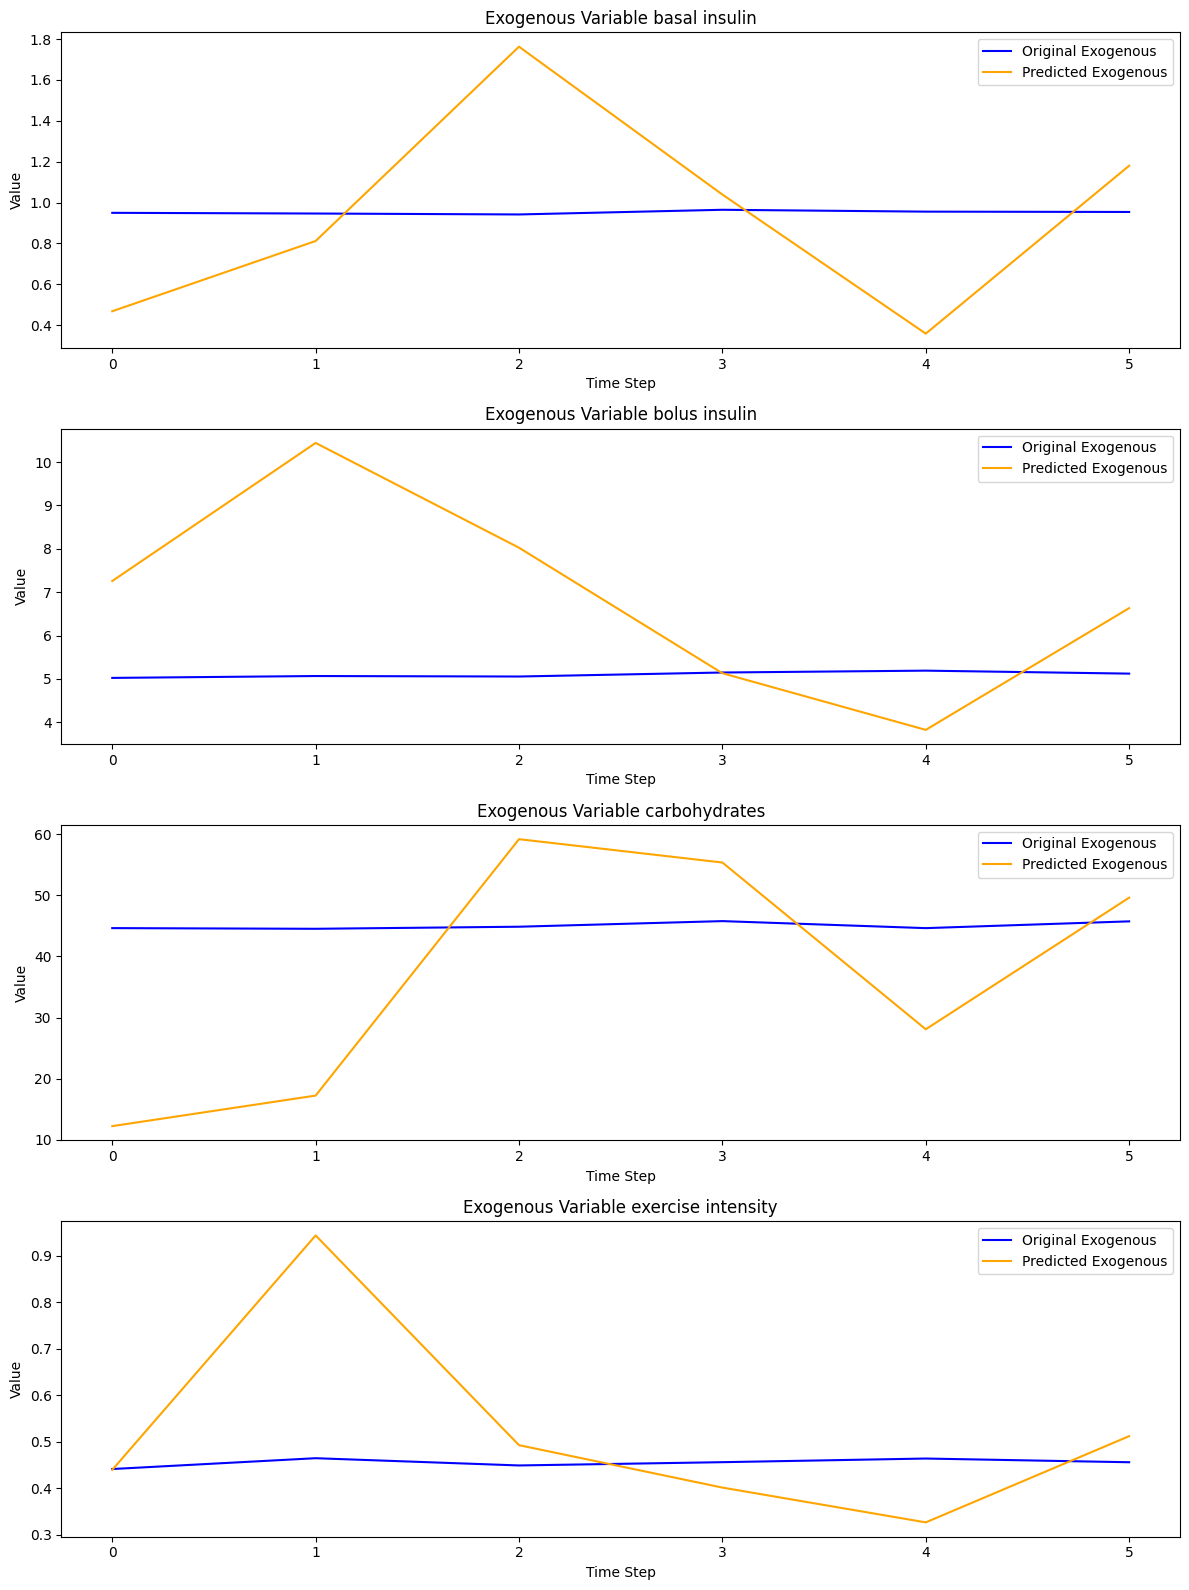

[48.89341736 49.14718246 49.05943298 49.05998993 50.76353455 53.03072739] [257.03979492 265.91604614 263.18899536 258.35479736 263.83081055
 253.54960632]


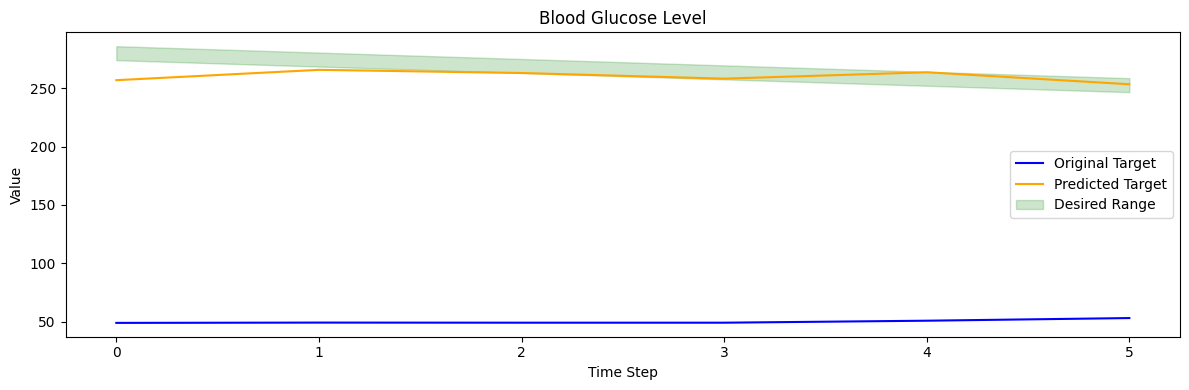

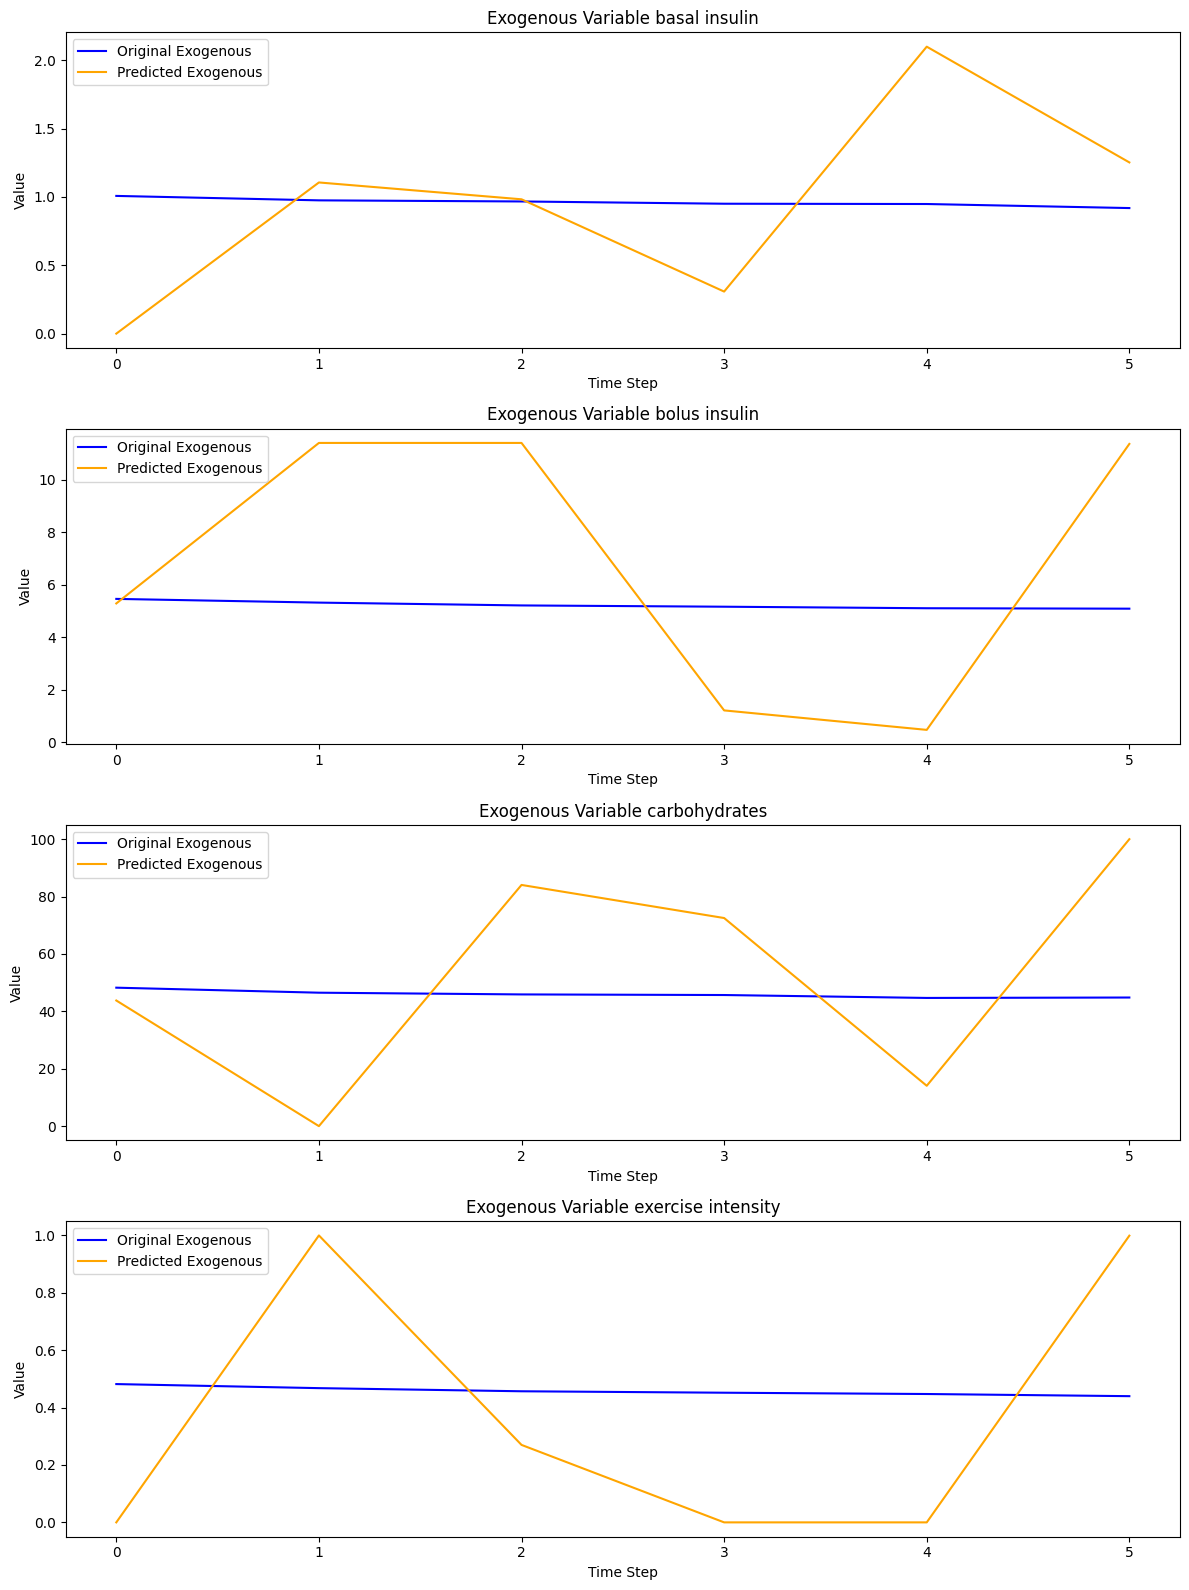

[120.16096497 120.34558868 120.2938385  120.97424316 121.50766754
 121.82305908] [89.09978485 89.53822327 94.22868347 93.38508606 90.54685974 96.64669037]


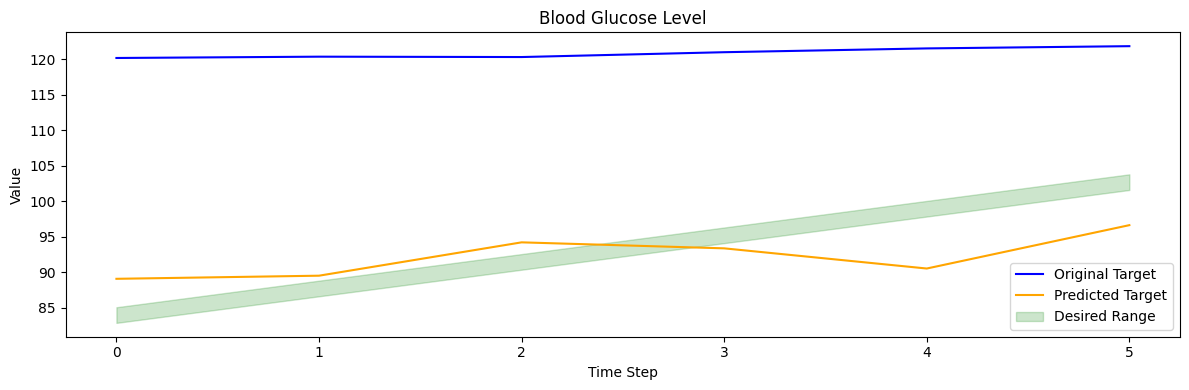

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/tf_keras/src/backend.py", line 5160, in <genexpr>
    output_ta_t = tuple(  File "/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


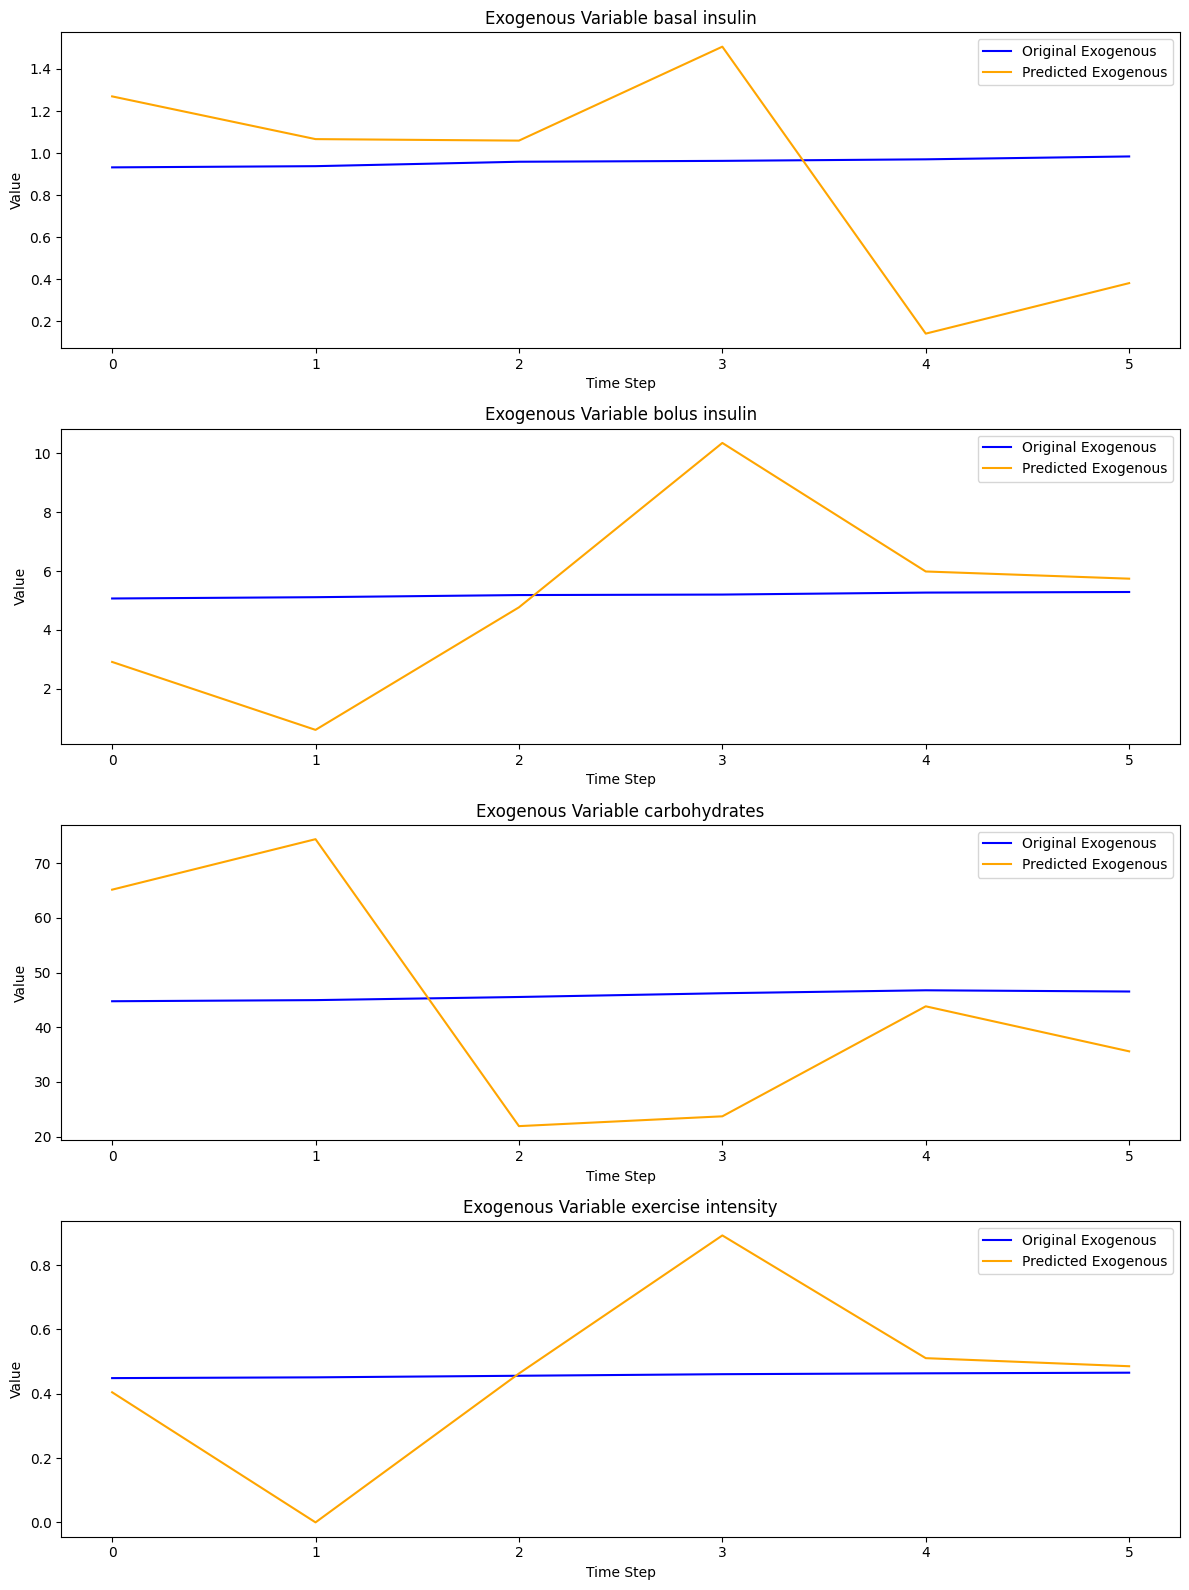

[134.15055847 131.26611328 130.56251526 128.48042297 126.08818054
 125.93344879] [180.8200531  183.17581177 185.22702026 181.96142578 183.11013794
 180.57223511]


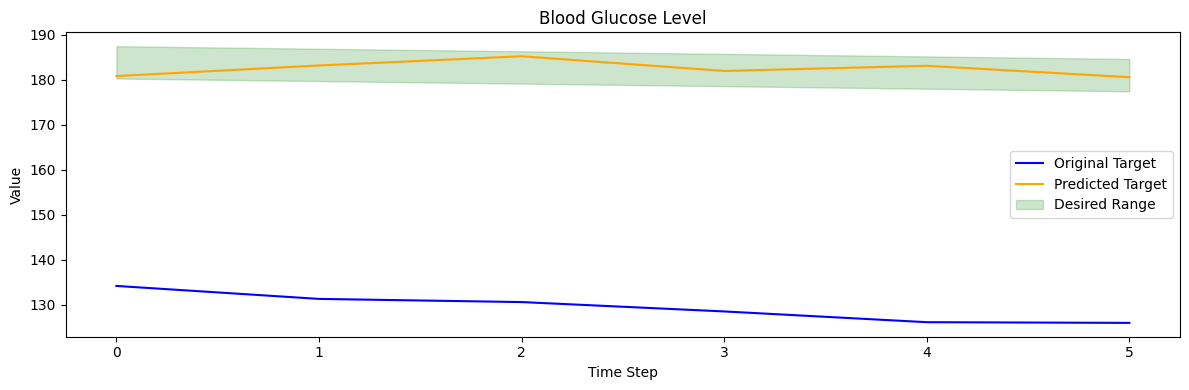

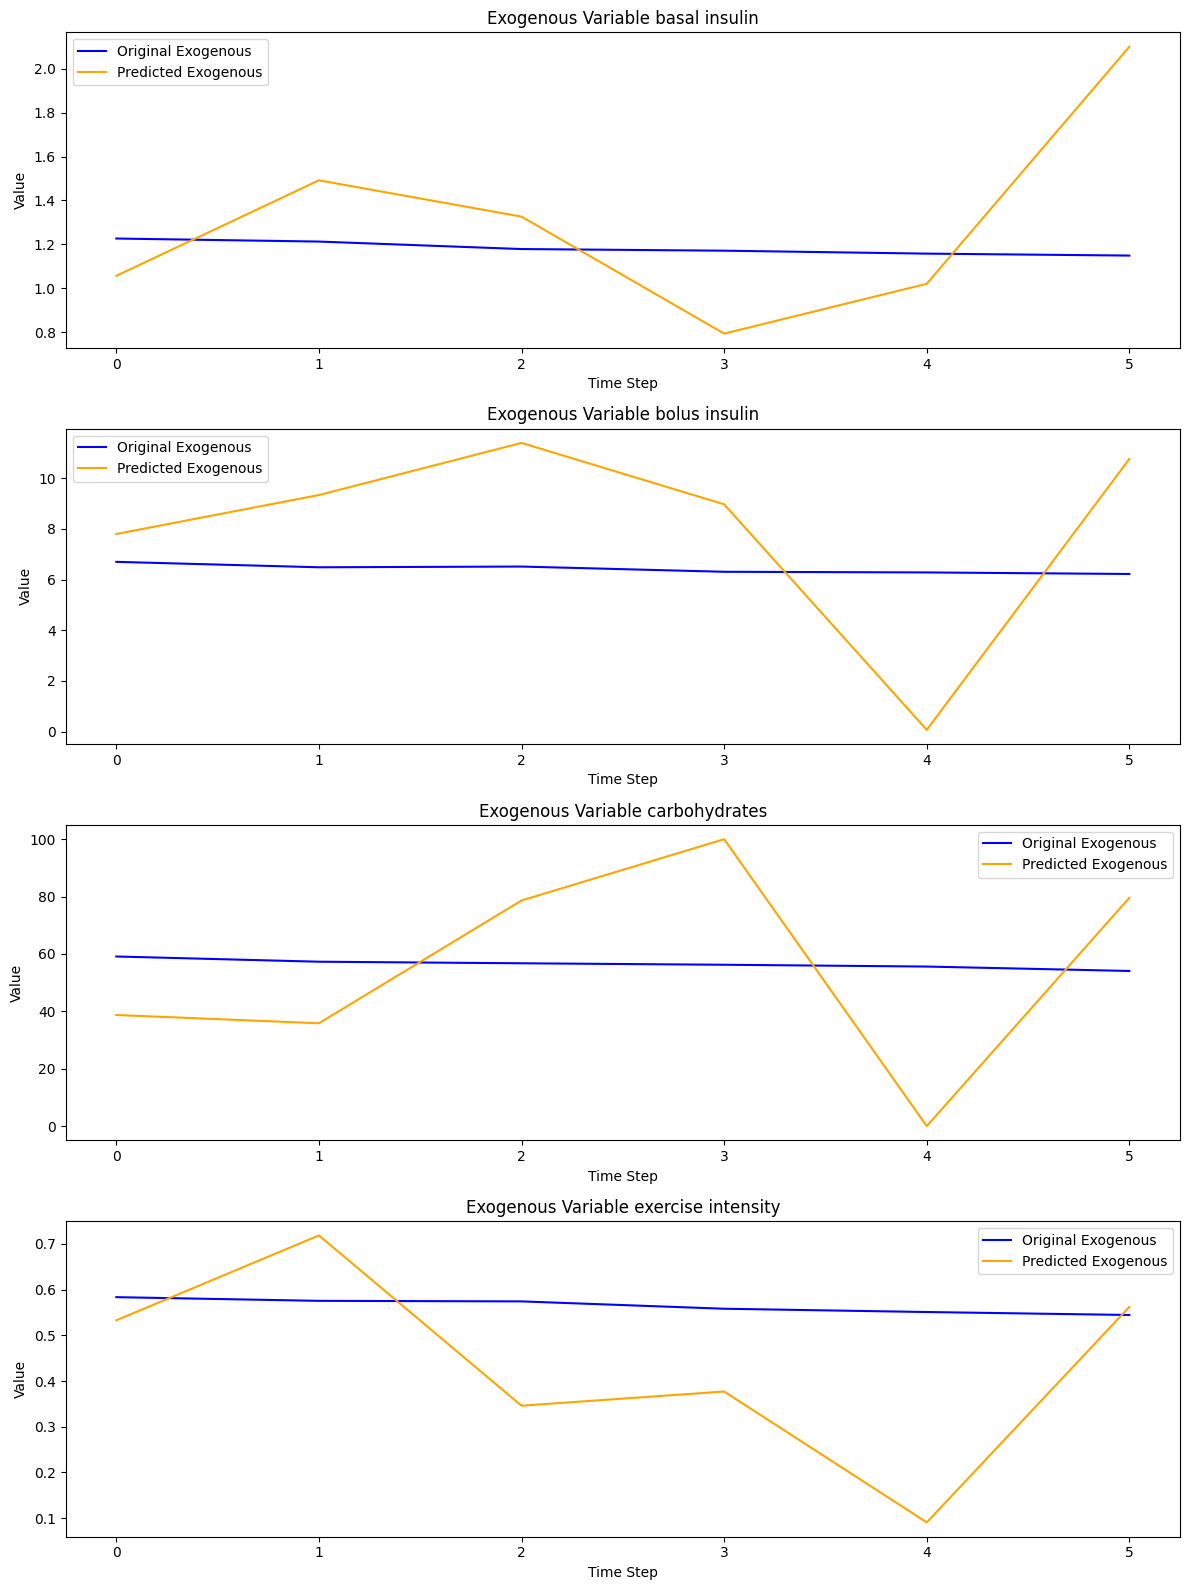

In [519]:

# Choose a sample index
sample_idx = random.sample(range(0, 100), 5)
#sample_idx = 58
for sam in sample_idx:
    time_steps = np.arange(sim_transformed_orig_targets_gru.shape[1])
    
    # Extract time series
    orig_targets = sim_transformed_orig_targets_gru[sam]
    pred_targets = sim_transformed_targets_gru[sam]
    orig_exogs = sim_transformed_orig_exogs_gru[sam]
    pred_exogs = sim_transformed_exogs_gru[sam]
    print(orig_targets, pred_targets)
    # Reshape targets if necessary
    if orig_targets.ndim == 1:
        orig_targets = orig_targets[:, np.newaxis]
    if pred_targets.ndim == 1:
        pred_targets = pred_targets[:, np.newaxis]
    if numpy_desired_min.ndim == 2:
        numpy_desired_min = numpy_desired_min[:, :, np.newaxis]
    if numpy_desired_max.ndim == 2:
        numpy_desired_max = numpy_desired_max[:, :, np.newaxis]
    
    num_target_vars = orig_targets.shape[-1]
    
        
    # Plot Targets
    plt.figure(figsize=(12, 4 * num_target_vars))
    for i in range(num_target_vars):
        plt.subplot(num_target_vars, 1, i + 1)
        plt.plot(time_steps, orig_targets[:, i], label='Original Target', color='blue')
        plt.plot(time_steps, pred_targets[:, i], label='Predicted Target', color='orange')
        plt.fill_between(
            time_steps,
            numpy_desired_min[sam, :, i],
            numpy_desired_max[sam, :, i],
            color='green',
            alpha=0.2,
            label='Desired Range' if i == 0 else None
        )
        plt.title(f"Blood Glucose Level")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"BG_gru_sim_6_24_{sam}.png")
    plt.show()
    
    if args.dataset == "ohiot1dm":
        labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
        num_exog_vars = 4
    elif args.dataset == "simulated":
        labels = ["carbohydrates", "insulin"]
        num_exog_vars = 2
    else:
        labels = None
        num_exog_vars = orig_exogs.shape[-1]
    # Plot Exogenous Variables
    plt.figure(figsize=(12, 4 * num_exog_vars))
    for i in range(num_exog_vars):
        plt.subplot(num_exog_vars, 1, i + 1)
        plt.plot(time_steps, orig_exogs[:, i], label='Original Exogenous', color='blue')
        plt.plot(time_steps, pred_exogs[:, i], label='Predicted Exogenous', color='orange')
        plt.title(f"Exogenous Variable {labels[i]}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"exogenous_gru_sim_6_24_{sam}.png")
    plt.show()


[89.25807953 91.46573639 93.56853485 93.9466095  95.68523407 97.50370026] [196.7701416  196.63259888 196.91183472 196.92407227 196.83512878
 196.89257812]


ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

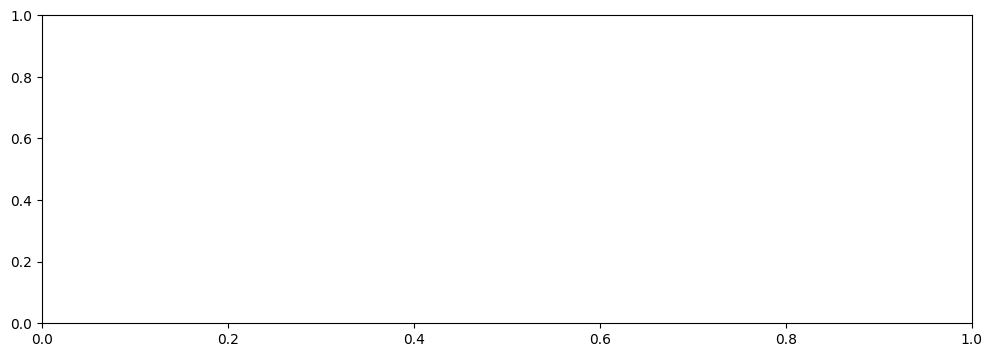

In [543]:

# Choose a sample index
sample_idx = random.sample(range(0, 100), 5)
#sample_idx = 58
for sam in sample_idx:
    time_steps = np.arange(transformed_orig_targets_sarimax.shape[1])
    
    # Extract time series
    orig_targets = sim_transformed_orig_targets_sarimax[sam]
    pred_targets = sim_transformed_targets_sarimax[sam]
    orig_exogs = sim_transformed_orig_exogs_sarimax[sam]
    pred_exogs = sim_transformed_exogs_sarimax[sam]
    print(orig_targets, pred_targets)
    # Reshape targets if necessary
    if orig_targets.ndim == 1:
        orig_targets = orig_targets[:, np.newaxis]
    if pred_targets.ndim == 1:
        pred_targets = pred_targets[:, np.newaxis]
    if numpy_desired_min.ndim == 2:
        numpy_desired_min = numpy_desired_min[:, :, np.newaxis]
    if numpy_desired_max.ndim == 2:
        numpy_desired_max = numpy_desired_max[:, :, np.newaxis]
    
    num_target_vars = orig_targets.shape[-1]
    
        
    # Plot Targets
    plt.figure(figsize=(12, 4 * num_target_vars))
    for i in range(num_target_vars):
        plt.subplot(num_target_vars, 1, i + 1)
        plt.plot(time_steps, orig_targets[:, i], label='Original Target', color='blue')
        plt.plot(time_steps, pred_targets[:, i], label='Predicted Target', color='orange')
        plt.fill_between(
            time_steps,
            numpy_desired_min[sam, :, i],
            numpy_desired_max[sam, :, i],
            color='green',
            alpha=0.2,
            label='Desired Range' if i == 0 else None
        )
        plt.title(f"Blood Glucose Level")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"BG_sarimax_sim_6_24_{sam}.png")
    plt.show()
    
    if args.dataset == "ohiot1dm":
        labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
        num_exog_vars = 4
    elif args.dataset == "simulated":
        labels = ["carbohydrates", "insulin"]
        num_exog_vars = 2
    else:
        labels = None
        num_exog_vars = orig_exogs.shape[-1]
    # Plot Exogenous Variables
    plt.figure(figsize=(12, 4 * num_exog_vars))
    for i in range(num_exog_vars):
        plt.subplot(num_exog_vars, 1, i + 1)
        plt.plot(time_steps, orig_exogs[:, i], label='Original Exogenous', color='blue')
        plt.plot(time_steps, pred_exogs[:, i], label='Predicted Exogenous', color='orange')
        plt.title(f"Exogenous Variable {labels[i]}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"exogenous_sarimax_sim_6_24_{sam}.png")
    plt.show()


Pair 1 (Orig idx: 89, Pred idx: 88) Target Euclidean distance: 0.3581


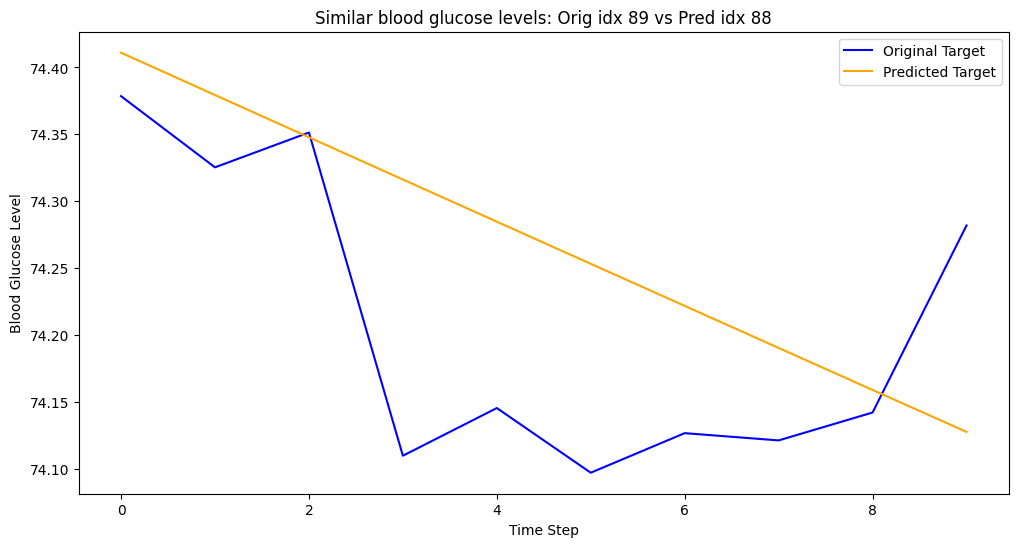

Pair 2 (Orig idx: 1, Pred idx: 0) Target Euclidean distance: 0.4406


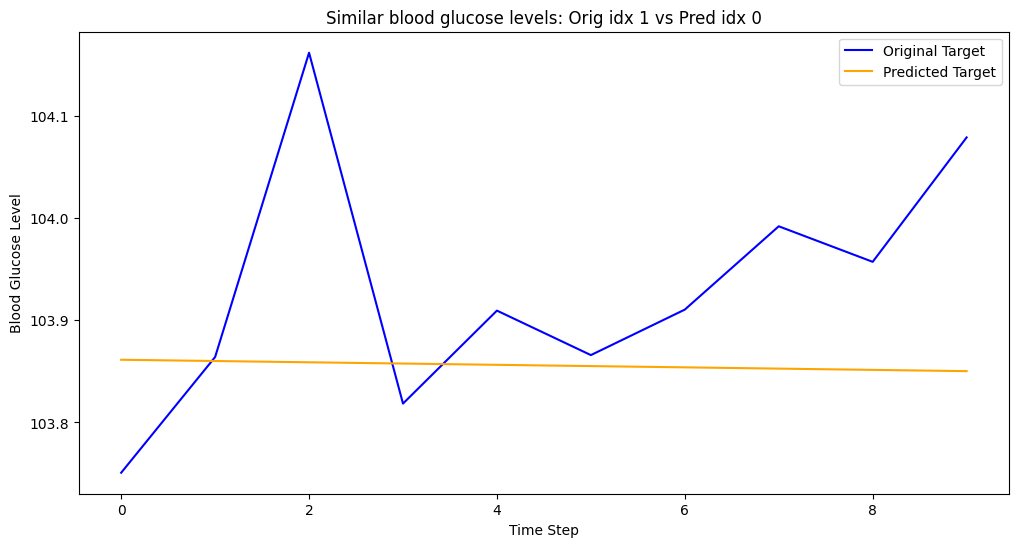

Pair 3 (Orig idx: 64, Pred idx: 5) Target Euclidean distance: 0.5856


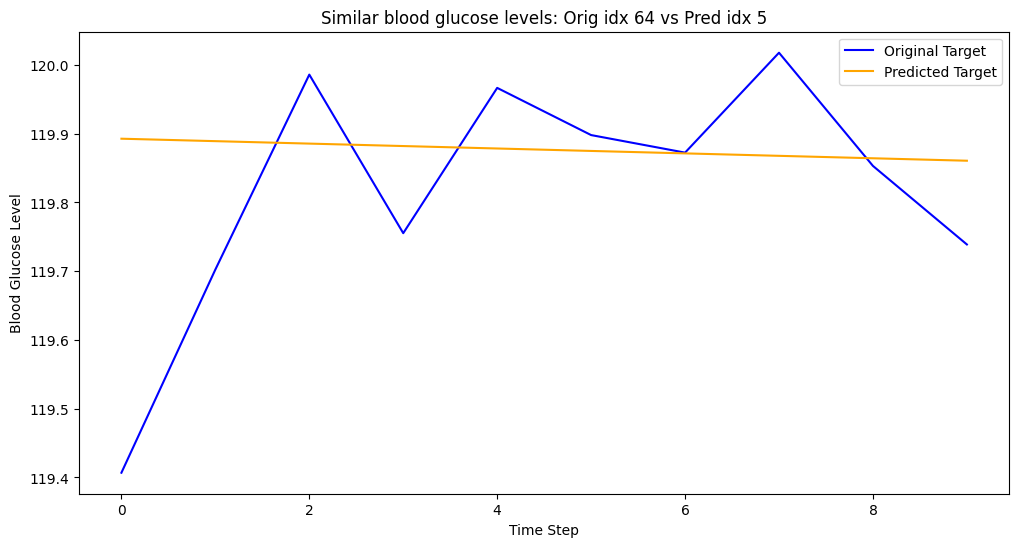

Pair 4 (Orig idx: 61, Pred idx: 6) Target Euclidean distance: 0.6405


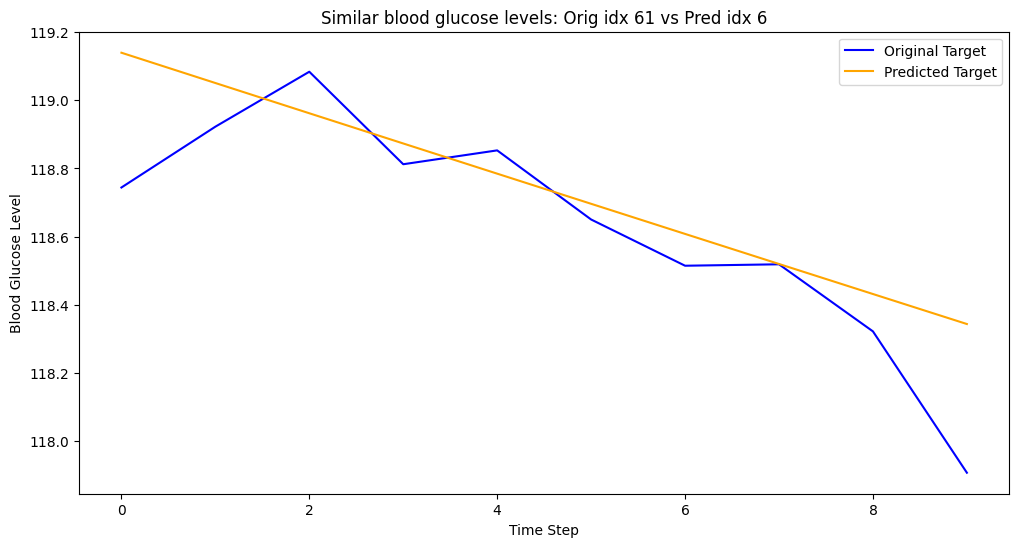

Skipping rank 5 (Orig idx 64, Pred idx 59): empty or near-zero series.


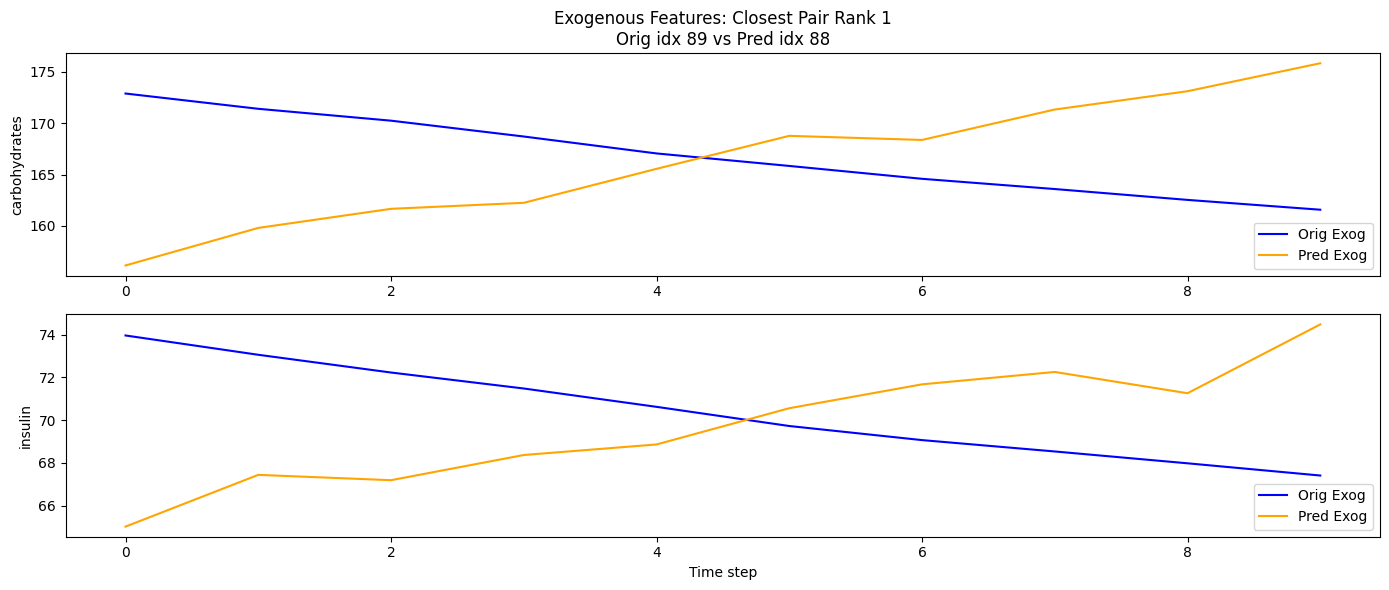

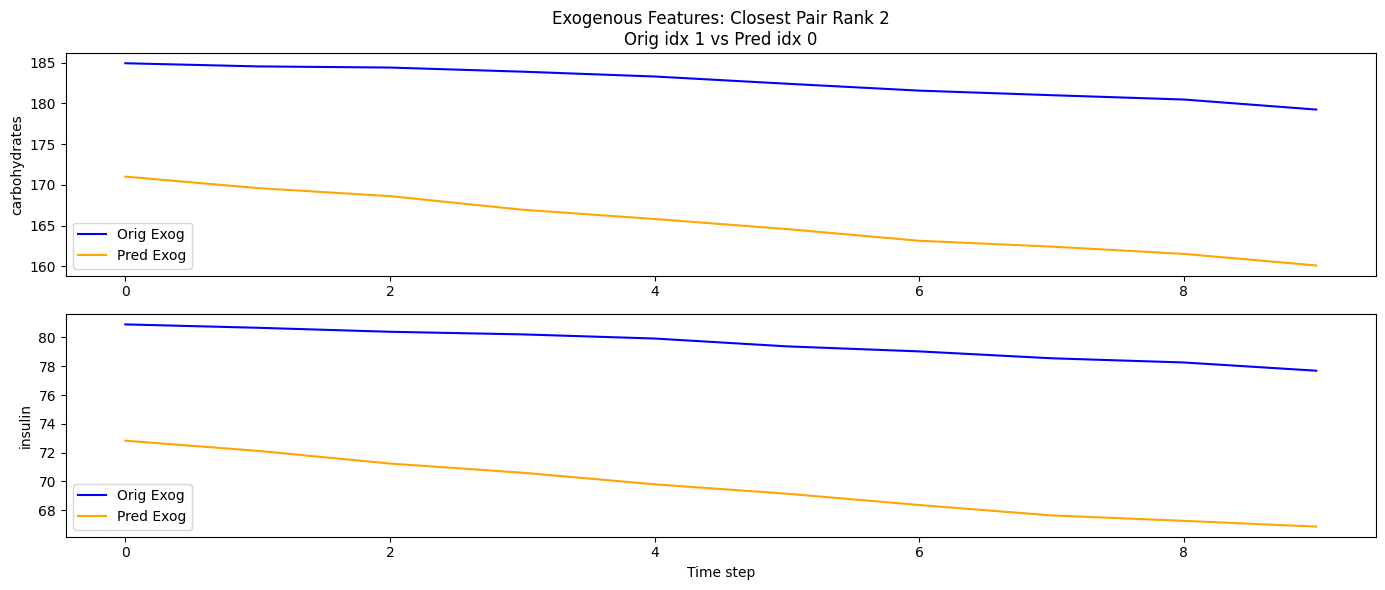

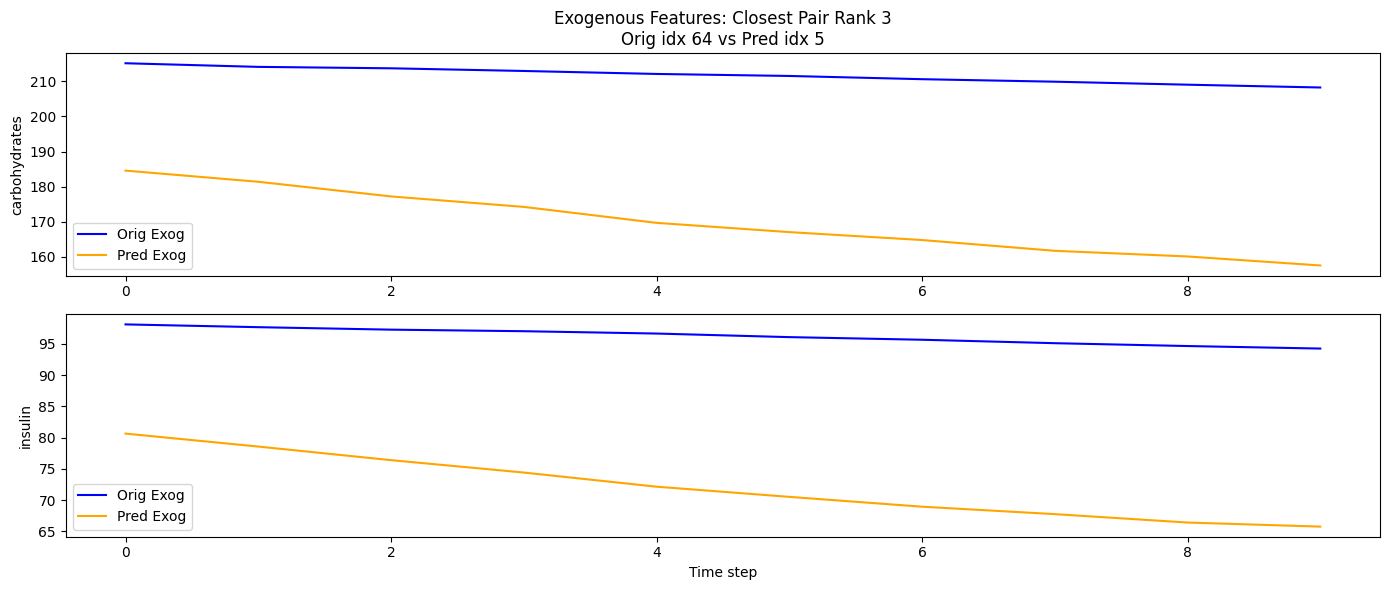

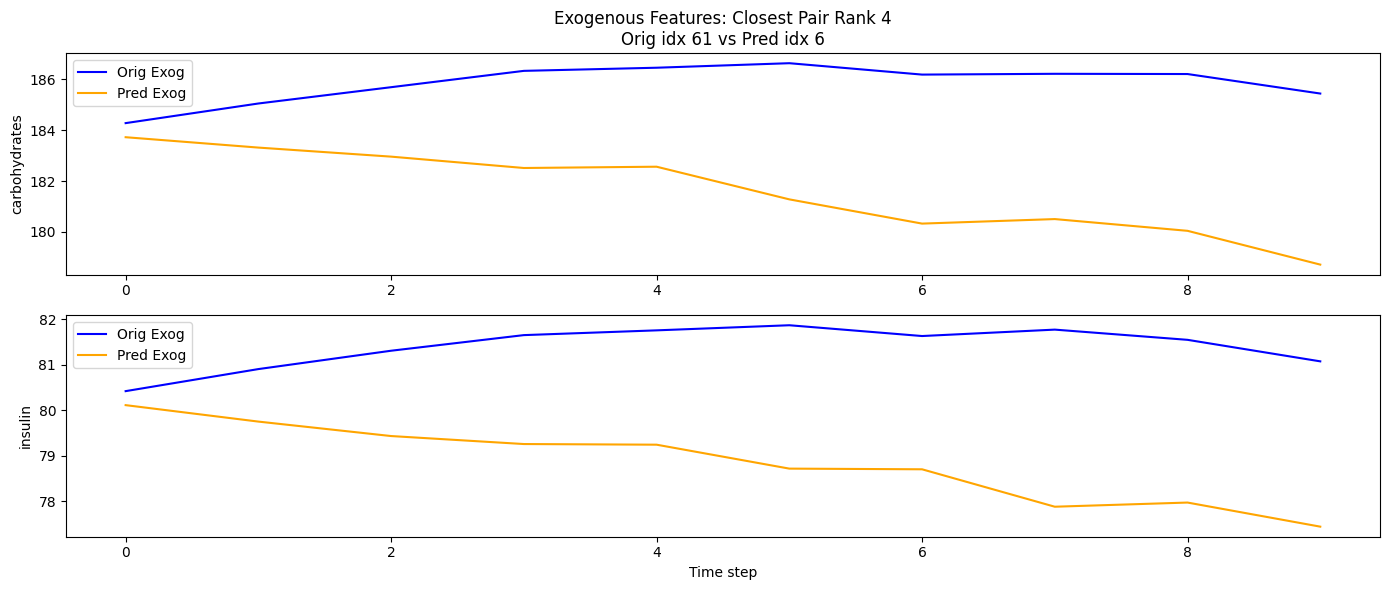

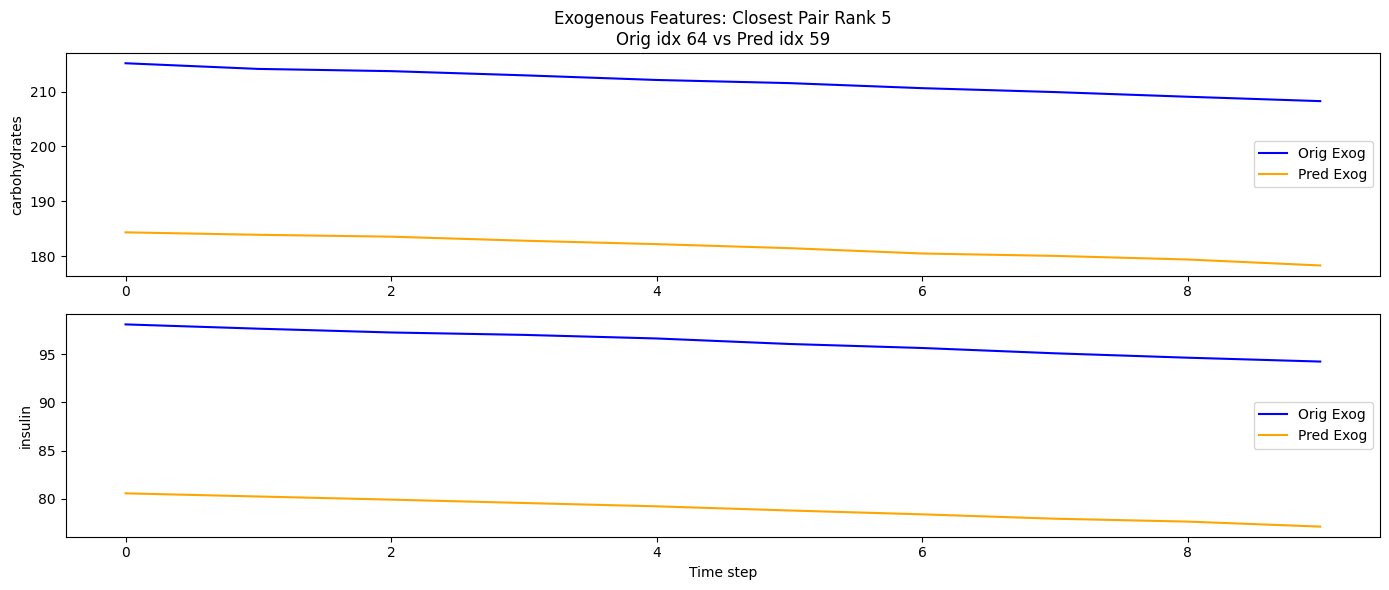

Pair 1 (Orig idx: 89, Pred idx: 88):
  Feature 1 (carbohydrates) Euclidean distance: 30.5244
  Feature 2 (insulin) Euclidean distance: 15.2088
Pair 2 (Orig idx: 1, Pred idx: 0):
  Feature 1 (carbohydrates) Euclidean distance: 54.6851
  Feature 2 (insulin) Euclidean distance: 31.5249
Pair 3 (Orig idx: 64, Pred idx: 5):
  Feature 1 (carbohydrates) Euclidean distance: 134.2800
  Feature 2 (insulin) Euclidean distance: 77.0531
Pair 4 (Orig idx: 61, Pred idx: 6):
  Feature 1 (carbohydrates) Euclidean distance: 14.8144
  Feature 2 (insulin) Euclidean distance: 8.7465
Pair 5 (Orig idx: 64, Pred idx: 59):
  Feature 1 (carbohydrates) Euclidean distance: 95.2952
  Feature 2 (insulin) Euclidean distance: 54.8171


In [278]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Define exogenous feature labels dynamically
if args.dataset == "ohiot1dm":
    labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
elif args.dataset == "simulated":
    labels = ["carbohydrates", "insulin"]
else:
    labels = [f"Feature {i}" for i in range(sim_transformed_orig_exogs_sarimax.shape[-1])]

orig_targets = sim_transformed_orig_targets_sarimax.squeeze()
pred_targets = sim_transformed_targets_sarimax.squeeze()

if orig_targets.ndim == 1:
    orig_targets = orig_targets.reshape(1, -1)

if pred_targets.ndim == 1:
    pred_targets = pred_targets.reshape(1, -1)

dist_matrix = pairwise_distances(orig_targets, pred_targets, metric='euclidean')


# Build closest pairs list (avoiding self-comparison if needed)
num_orig = orig_targets.shape[0]
num_pred = pred_targets.shape[0]

closest_pairs = []
# Mask self-distances if comparing within the same array
if np.array_equal(orig_targets, pred_targets):
    np.fill_diagonal(dist_matrix, np.inf)

# Find indices of the k smallest distances globally
k = 5
flat_indices = np.argsort(dist_matrix, axis=None)[:k]
closest_pairs = list(zip(*np.unravel_index(flat_indices, dist_matrix.shape)))

# Plot a few closest pairs
plot_samples = closest_pairs[:5]

# Plot targets for closest pairs (with filtering)
for rank, (orig_idx, pred_idx) in enumerate(closest_pairs[:5], 1):
    orig_series = orig_targets[orig_idx].squeeze()
    pred_series = pred_targets[pred_idx].squeeze()

    if not (is_nonempty_series(orig_series) and is_nonempty_series(pred_series)):
        print(f"Skipping rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}): empty or near-zero series.")
        continue

    target_distance = np.linalg.norm(orig_series - pred_series)
    print(f"Pair {rank} (Orig idx: {orig_idx}, Pred idx: {pred_idx}) Target Euclidean distance: {target_distance:.4f}")

    plt.figure(figsize=(12, 6))
    time_axis = range(orig_targets.shape[1])
    plt.plot(time_axis, orig_series, label='Original Target', color='blue')
    plt.plot(time_axis, pred_series, label='Predicted Target', color='orange')
    plt.title(f"Similar blood glucose levels: Orig idx {orig_idx} vs Pred idx {pred_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Blood Glucose Level")
    plt.legend()
    plt.savefig(f"similar_bg_{args.dataset}_{orig_idx}_{pred_idx}.png")
    plt.show()

# Plot exogenous features for closest pairs
orig_exogs = sim_transformed_orig_exogs_sarimax
pred_exogs = sim_transformed_exogs_sarimax
num_exog_vars = orig_exogs.shape[2]

for rank, (orig_idx, pred_idx) in enumerate(closest_pairs[:5], 1):
    orig_exog = orig_exogs[orig_idx]
    pred_exog = pred_exogs[pred_idx]

    if not (is_nonempty_series(orig_exog) and is_nonempty_series(pred_exog)):
        print(f"Skipping exog plot rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}) due to empty or near-zero values.")
        continue

    plt.figure(figsize=(14, 6))
    timesteps = orig_exogs.shape[1]
    time_axis = range(timesteps)

    for feature_idx in range(num_exog_vars):
        plt.subplot(num_exog_vars, 1, feature_idx + 1)
        plt.plot(time_axis, orig_exog[:, feature_dx], label='Orig Exog', color='blue')
        plt.plot(time_axis, pred_exog[:, feature_idx], label='Pred Exog', color='orange')
        plt.ylabel(f'{labels[feature_idx]}')
        if feature_idx == 0:
            plt.title(f'Exogenous Features: Closest Pair Rank {rank}\nOrig idx {orig_idx} vs Pred idx {pred_idx}')
        if feature_idx == num_exog_vars - 1:
            plt.xlabel('Time step')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"similar_exogs_{args.dataset}_{orig_idx}_{pred_idx}.png")
    plt.show()

# Calculate and print Euclidean distances for exogenous features per pair
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs[:5]:
    distances = []
    for feature_idx in range(num_exog_vars):
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)

    exog_distances_per_feature.append(distances)

# Print distances
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    orig_idx, pred_idx = closest_pairs[pair_idx - 1]
    print(f"Pair {pair_idx} (Orig idx: {orig_idx}, Pred idx: {pred_idx}):")
    for feature_idx, dist in enumerate(distances):
        print(f"  Feature {feature_idx + 1} ({labels[feature_idx]}) Euclidean distance: {dist:.4f}")

In [ ]:
import numpy as np

# Assuming orig_targets and pred_targets are numpy arrays of shape (num_samples, timesteps, 1)
orig_flat = sim_transformed_orig_targets_gru.squeeze(-1)  # (num_orig_samples, timesteps)
pred_flat = sim_transformed_targets_gru.squeeze(-1)  # (num_pred_samples, timesteps)

num_orig = orig_flat.shape[0]
num_pred = pred_flat.shape[0]

# Compute distance matrix (num_orig x num_pred)
dist_matrix = np.zeros((num_orig, num_pred))

for i in range(num_orig):
    for j in range(num_pred):
        dist_matrix[i, j] = np.linalg.norm(orig_flat[i] - pred_flat[j])

# Flatten the distance matrix and get indices of the 5 smallest distances
flat_indices = np.argpartition(dist_matrix.flatten(), 5)[:5]

# Convert flattened indices back to 2D indices
closest_pairs = [divmod(idx, num_pred) for idx in flat_indices]
closest_distances = [dist_matrix[i, j] for i, j in closest_pairs]

for rank, ((i, j), dist) in enumerate(sorted(zip(closest_pairs, closest_distances), key=lambda x: x[1]), 1):
    print(f"Rank {rank}: Orig sample {i} and Pred sample {j} with distance {dist:.4f}")

print(closest_pairs)

In [107]:
print(sim_transformed_orig_exogs_gru, sim_transformed_exogs_gru)

[[[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]

 [[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]

 [[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]

 ...

 [[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]

 [[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]

 [[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]] [[[0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]
  ...
  [0.       0.021125]
  [0.       0.021125]
  [0.       0.021125]]

 [[0.       0.

[[115.77692413]
 [115.49519348]
 [115.2904892 ]
 [114.78579712]
 [114.33899689]
 [113.82033539]
 [113.25753021]
 [112.96472168]
 [112.44643402]
 [111.86691284]] [[114.59687042]
 [114.91181183]
 [114.70130157]
 [114.66239166]
 [114.97970581]
 [115.586586  ]
 [114.51541138]
 [115.26224518]
 [113.77031708]
 [114.48387909]]
Skipping rank 1 (Orig idx 2, Pred idx 7): empty or near-zero series.
Skipping rank 2 (Orig idx 5, Pred idx 8): empty or near-zero series.
Skipping rank 3 (Orig idx 3, Pred idx 2): empty or near-zero series.
Skipping rank 4 (Orig idx 1, Pred idx 5): empty or near-zero series.
Skipping rank 5 (Orig idx 3, Pred idx 3): empty or near-zero series.


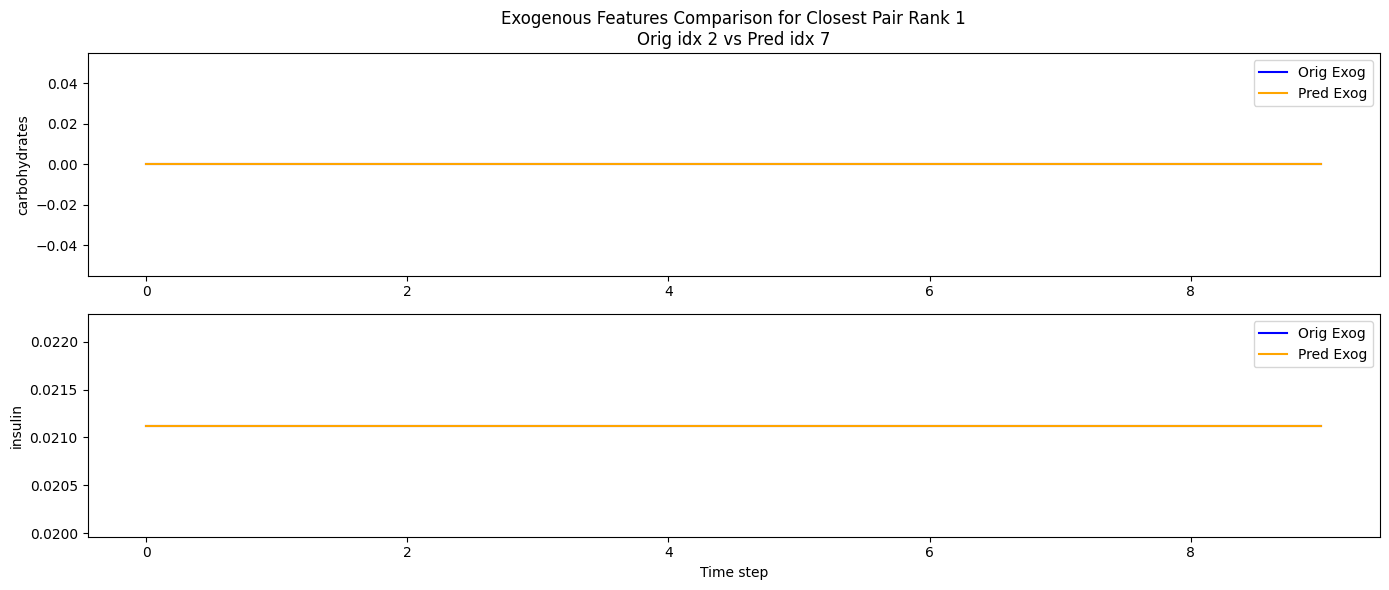

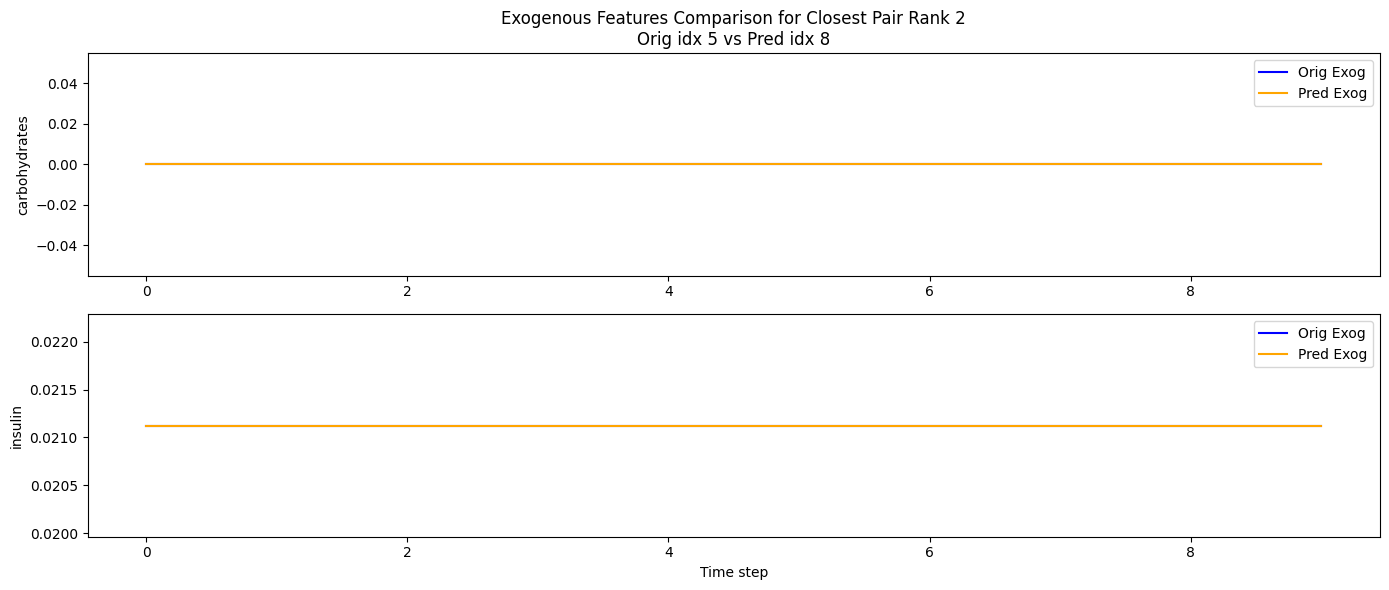

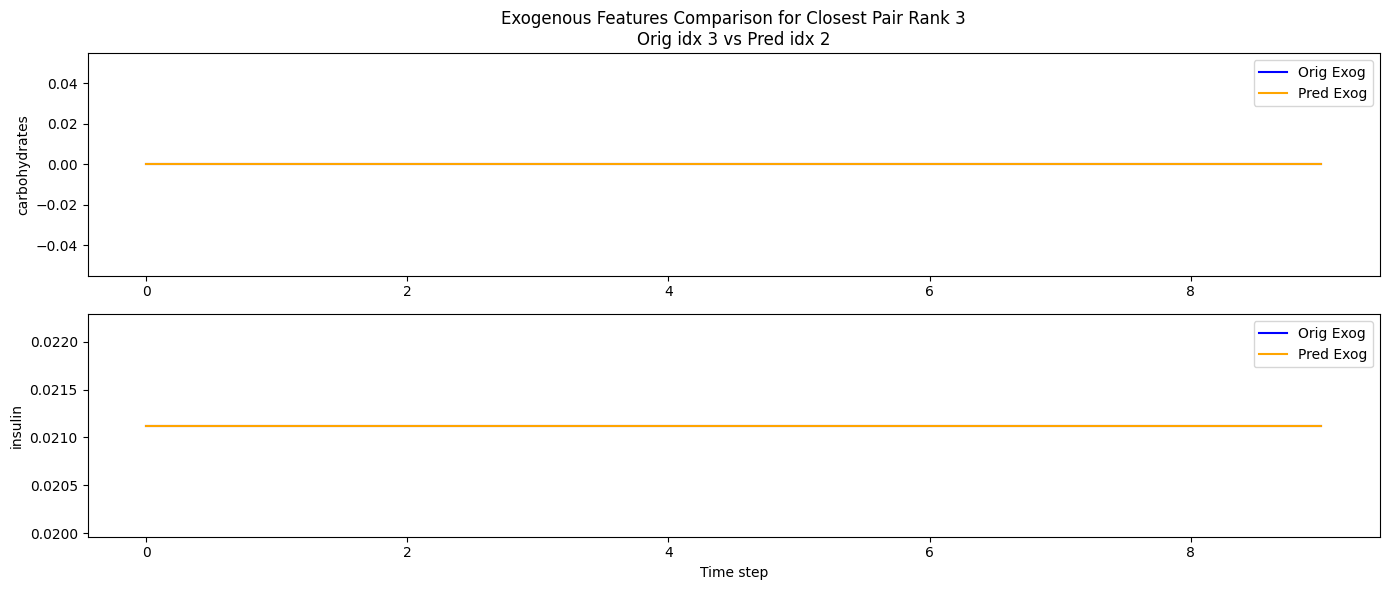

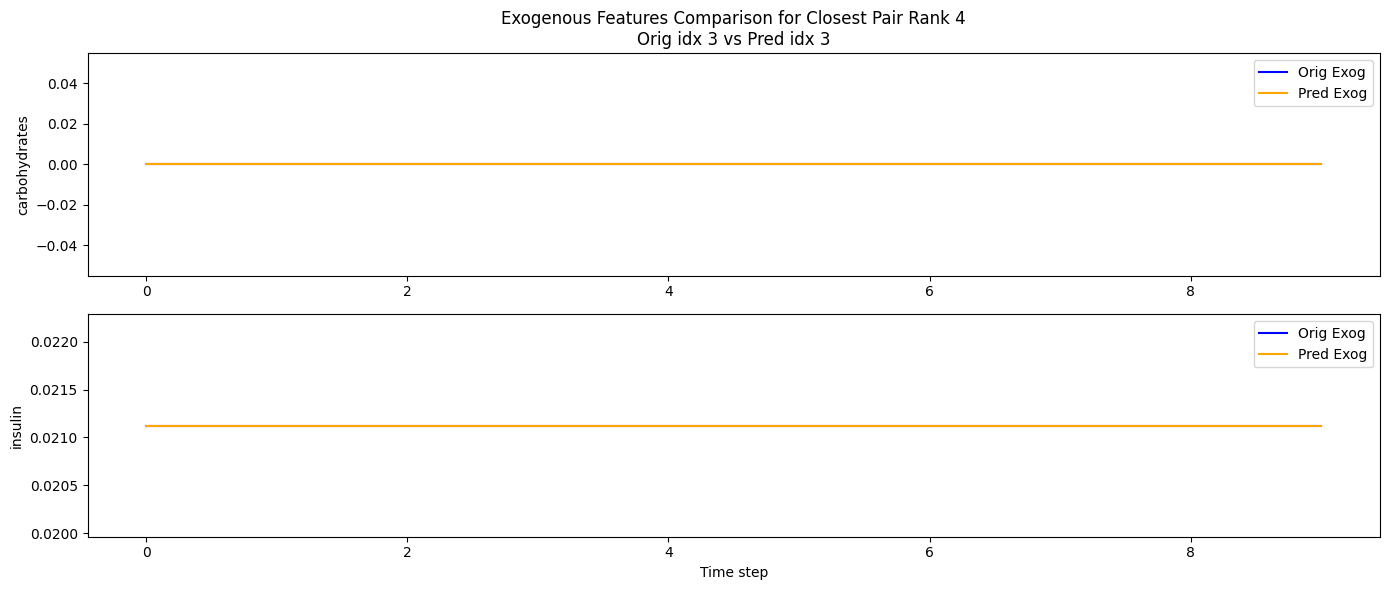

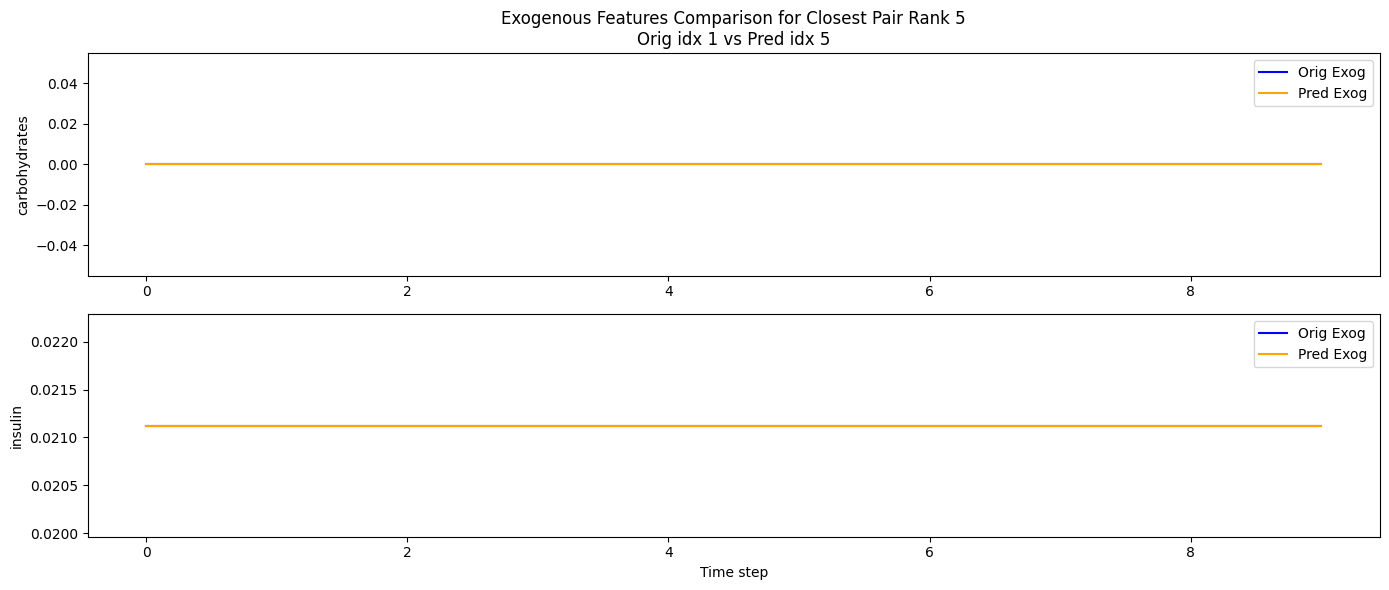

In [115]:
import matplotlib.pyplot as plt

# Assuming closest_pairs is already computed from previous step as list of (orig_idx, pred_idx)

def is_nonempty_series(series, min_range=0.01):
    series = np.array(series).flatten()
    return np.max(series) - np.min(series) > min_range

print(orig_targets, pred_targets)
for rank, (orig_idx, pred_idx) in enumerate(sorted(closest_pairs, key=lambda x: dist_matrix[x[0], x[1]]), 1):
    orig_series = orig_targets[orig_idx].squeeze()
    pred_series = pred_targets[pred_idx].squeeze()
    
    if not (is_nonempty_series(orig_series) and is_nonempty_series(pred_series)):
        print(f"Skipping rank {rank} (Orig idx {orig_idx}, Pred idx {pred_idx}): empty or near-zero series.")
        continue

    plt.figure(figsize=(12, 6))
    time_axis = range(orig_targets.shape[1])
    plt.plot(time_axis, orig_series, label='Original Target', color='blue')
    plt.plot(time_axis, pred_series, label='Predicted Target', color='orange')
    plt.title(f"Similar blood glucose levels original vs. predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Blood Glucose Level")
    plt.legend()
    plt.savefig(f"similar_bg_sim_10_40_{orig_idx}_{pred_idx}.png")
    plt.show()


# closest_pairs: list of (orig_idx, pred_idx)

orig_exogs = sim_transformed_orig_exogs_gru
pred_exogs = sim_transformed_exogs_gru

if args.dataset == "ohiot1dm":
    labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
    num_exog_vars = 4
elif args.dataset == "simulated":
    labels = ["carbohydrates", "insulin"]
    num_exog_vars = 2
    
for rank, (orig_idx, pred_idx) in enumerate(closest_pairs, 1):
    orig_exog = orig_exogs[orig_idx]
    pred_exog = pred_exogs[pred_idx]

    if not (is_nonempty_series(orig_exog) and is_nonempty_series(pred_exog)):
        print(f"Skipping exog plot rank {rank} due to empty or near-zero values.")
        continue

    plt.figure(figsize=(14, 6))
    
    timesteps = orig_exogs.shape[1]
    time_axis = range(timesteps)
    num_features = orig_exogs.shape[2]
    
    for feature_idx in range(num_features):
        plt.subplot(num_features, 1, feature_idx + 1)
        
        # Plot original exog
        plt.plot(time_axis, orig_exogs[orig_idx, :, feature_idx], label='Orig Exog', color='blue')
        
        # Plot predicted exog
        plt.plot(time_axis, pred_exogs[pred_idx, :, feature_idx], label='Pred Exog', color='orange')
        
        plt.ylabel(f'{labels[feature_idx]}')
        if feature_idx == 0:
            plt.title(f'Exogenous Features Comparison for Closest Pair Rank {rank}\nOrig idx {orig_idx} vs Pred idx {pred_idx}')
        if feature_idx == num_features - 1:
            plt.xlabel('Time step')
        
        plt.legend()
    plt.savefig(f"similar_exogs_sim_6_24_{orig_idx}_{pred_idx}.png")    
    plt.tight_layout()
    plt.show()


In [67]:
# Number of features
num_features = orig_exogs.shape[2]

# List to hold distances per pair, per feature
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs:
    distances = []
    for feature_idx in range(num_features):
        # Extract time series for this feature from original and predicted exogs
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]
        
        # Compute Euclidean distance for this feature
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)
    
    exog_distances_per_feature.append(distances)

# Print distances for each pair and feature
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    print(f"Pair {pair_idx}:")
    for feature_idx, dist in enumerate(distances, 1):
        print(f"  Feature {feature_idx} Euclidean distance: {dist:.4f}")


Pair 1:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043
Pair 2:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043
Pair 3:
  Feature 1 Euclidean distance: 167.2813
  Feature 2 Euclidean distance: 24.5022
Pair 4:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043
Pair 5:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043


In [68]:
import numpy as np

# Use normalized data
orig_targets = orig_targets_gru
pred_targets = targets_gru  # comparing within the same set
orig_exogs = orig_exogs_gru
pred_exogs = exogs_gru

# Compute pairwise Euclidean distances between targets
target_dist_matrix = np.linalg.norm(
    orig_targets[:, np.newaxis, :] - pred_targets[np.newaxis, :, :], axis=2
)

# Get top 5 closest target pairs (excluding identity pairs)
np.fill_diagonal(target_dist_matrix, np.inf)
closest_pairs = np.unravel_index(np.argsort(target_dist_matrix, axis=None)[:5], target_dist_matrix.shape)
closest_pairs = list(zip(closest_pairs[0], closest_pairs[1]))

# Number of features
num_features = orig_exogs.shape[2]

# List to hold distances per pair, per feature
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs:
    distances = []
    for feature_idx in range(num_features):
        # Extract time series for this feature from original and predicted exogs
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]

        # Compute Euclidean distance for this feature
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)

    exog_distances_per_feature.append(distances)

# Print distances for each pair and feature
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    print(f"Pair {pair_idx} (Orig idx: {closest_pairs[pair_idx-1][0]}, Pred idx: {closest_pairs[pair_idx-1][1]}):")
    for feature_idx, dist in enumerate(distances, 1):
        print(f"  Feature {feature_idx} Euclidean distance: {dist:.4f}")


Pair 1 (Orig idx: 68, Pred idx: 0):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 2 (Orig idx: 68, Pred idx: 29):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 3 (Orig idx: 68, Pred idx: 30):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 4 (Orig idx: 68, Pred idx: 31):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 5 (Orig idx: 68, Pred idx: 32):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710


In [ ]:
print(targets_gru.shape, exogs_gru.shape)

In [ ]:
import numpy as np

# Assume:
# normalized_orig_exogs: shape (n_orig, time_steps, n_features)
# normalized_pred_exogs: shape (n_pred, time_steps, n_features)

# Flatten time and feature dimensions to 2D: shape (n_samples, time_steps * n_features)
flat_orig = targets_gru.reshape(targets_gru.shape[0], -1)
flat_pred = exogs_gru.reshape(flat_pred = exogs_gru.reshape(normalized_pred_exogs.shape[0], -1).shape[0], -1)

# Compute pairwise Euclidean distances
from scipy.spatial.distance import cdist
exog_dist_matrix = cdist(flat_orig, flat_pred, metric='euclidean')  # shape (n_orig, n_pred)


In [ ]:
import numpy as np

def analyse_changes(old_array, new_array):
    old_array = np.array(old_array)
    new_array = np.array(new_array)

    if old_array.shape != new_array.shape:
        raise ValueError("Arrays must be the same shape")

    diff = new_array - old_array
    abs_diff = np.abs(diff)

    avg_change = np.mean(abs_diff)
    fraction_changed = np.mean(old_array != new_array)
    drasticity_std = np.std(diff)
    drasticity_range = np.ptp(diff)  # max - min

    return {
        "average_change": avg_change,
        "fraction_changed": fraction_changed,
        "drasticity_std_dev": drasticity_std,
        "drasticity_range": drasticity_range
    }

def analyse_fit_within_bounds(array, lower_bound, upper_bound):
    array = np.array(array)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)

    if not (array.shape == lower_bound.shape == upper_bound.shape):
        raise ValueError("All arrays must be the same shape")

    within_bounds = (array >= lower_bound) & (array <= upper_bound)
    fraction_within_bounds = np.mean(within_bounds)

    return {
        "fraction_within_bounds": fraction_within_bounds,
        "total_violations": np.size(array) - np.sum(within_bounds),
        "violated_indices": np.where(~within_bounds)
    }

change_stats = analyse_changes(opt.orig_targets, opt.targets)
fit_stats = analyse_fit_within_bounds(opt.targets, numpy_desired_min, numpy_desired_max)

print("Change Stats:", change_stats)
print("Fit Stats:", fit_stats)


/tmp/ipykernel_14906/2363299163.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=change_labels, y=change_values, ax=axs[0], palette='Blues_r')
/tmp/ipykernel_14906/2363299163.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(change_labels, rotation=15)
/tmp/ipykernel_14906/2363299163.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=fit_labels, y=fit_values, ax=axs[1], palette='Greens_r')
/tmp/ipykernel_14906/2363299163.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

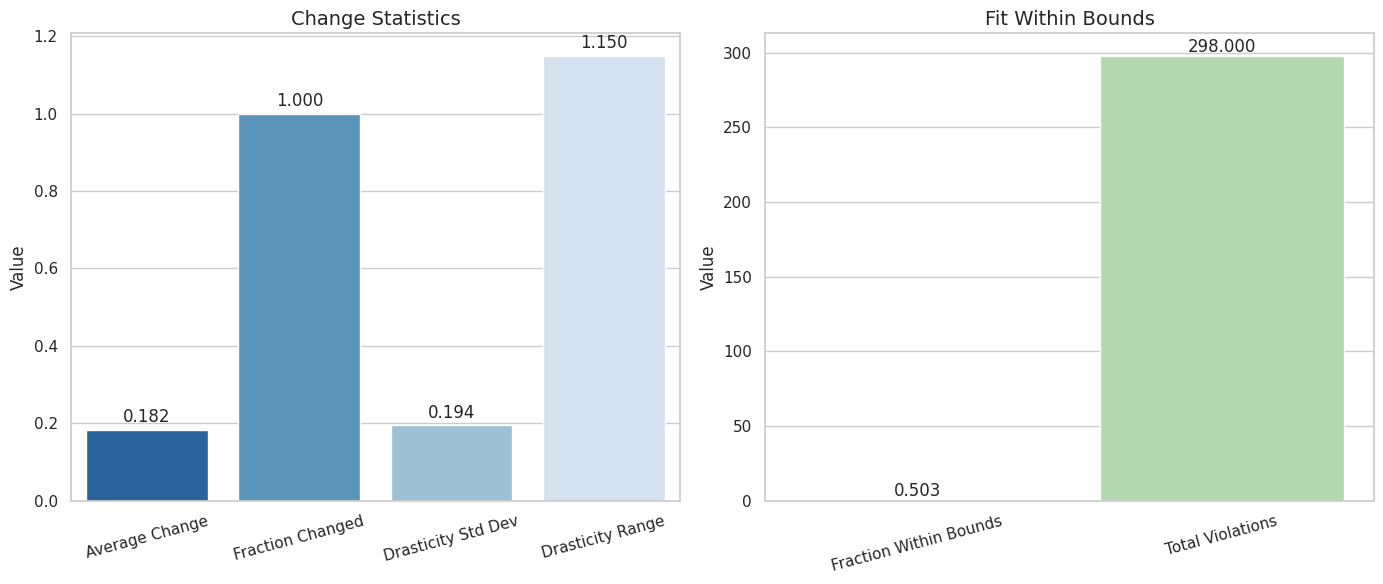

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stats(change_stats, fit_stats):
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ---- Plot 1: Change Stats ----
    change_labels = [
        'Average Change',
        'Fraction Changed',
        'Drasticity Std Dev',
        'Drasticity Range'
    ]
    change_values = [
        change_stats['average_change'],
        change_stats['fraction_changed'],
        change_stats['drasticity_std_dev'],
        change_stats['drasticity_range']
    ]

    bars = sns.barplot(x=change_labels, y=change_values, ax=axs[0], palette='Blues_r')
    axs[0].set_title("Change Statistics", fontsize=14)
    axs[0].set_ylabel("Value")
    axs[0].set_xticklabels(change_labels, rotation=15)

    for bar, val in zip(bars.patches, change_values):
        height = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

    # ---- Plot 2: Fit Stats ----
    fit_labels = ['Fraction Within Bounds', 'Total Violations']
    fit_values = [
        fit_stats['fraction_within_bounds'],
        fit_stats['total_violations']
    ]

    bars = sns.barplot(x=fit_labels, y=fit_values, ax=axs[1], palette='Greens_r')
    axs[1].set_title("Fit Within Bounds", fontsize=14)
    axs[1].set_ylabel("Value")
    axs[1].set_xticklabels(fit_labels, rotation=15)

    for bar, val in zip(bars.patches, fit_values):
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


change_stats = analyse_changes(opt.orig_targets, opt.targets)
fit_stats = analyse_fit_within_bounds(opt.targets, numpy_desired_min, numpy_desired_max)

plot_stats(change_stats, fit_stats)


/tmp/ipykernel_14906/82482816.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(mean_per_feature_change)), y=mean_per_feature_change, ax=axs[1, 0], palette="coolwarm")


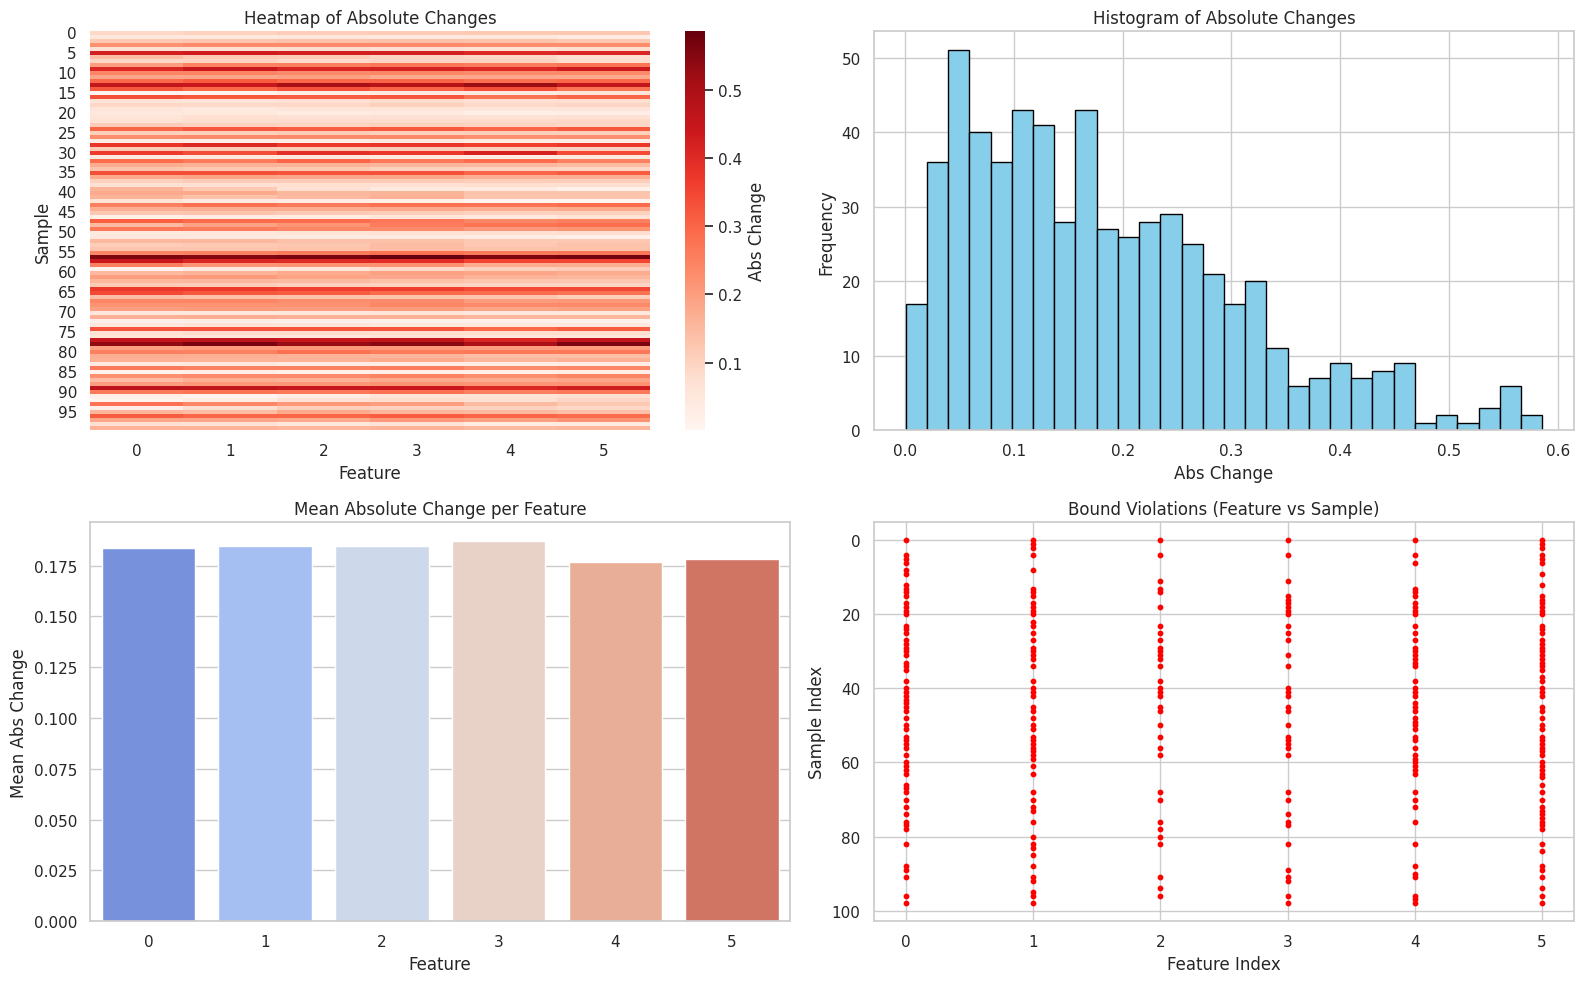

In [30]:
def plot_detailed_stats(old_array, new_array, lower_bound, upper_bound):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    old_array = np.array(old_array)
    new_array = np.array(new_array)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)

    diff = new_array - old_array
    abs_diff = np.abs(diff)
    within_bounds = (new_array >= lower_bound) & (new_array <= upper_bound)
    violations = ~within_bounds

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    sns.set(style="whitegrid")

    # 1. Heatmap of absolute changes
    sns.heatmap(abs_diff, ax=axs[0, 0], cmap="Reds", cbar_kws={'label': 'Abs Change'})
    axs[0, 0].set_title("Heatmap of Absolute Changes")
    axs[0, 0].set_xlabel("Feature")
    axs[0, 0].set_ylabel("Sample")

    # 2. Histogram of absolute changes
    axs[0, 1].hist(abs_diff.flatten(), bins=30, color='skyblue', edgecolor='black')
    axs[0, 1].set_title("Histogram of Absolute Changes")
    axs[0, 1].set_xlabel("Abs Change")
    axs[0, 1].set_ylabel("Frequency")

    # 3. Bar plot of per-feature average change
    mean_per_feature_change = abs_diff.mean(axis=0)
    sns.barplot(x=np.arange(len(mean_per_feature_change)), y=mean_per_feature_change, ax=axs[1, 0], palette="coolwarm")
    axs[1, 0].set_title("Mean Absolute Change per Feature")
    axs[1, 0].set_xlabel("Feature")
    axs[1, 0].set_ylabel("Mean Abs Change")

    # 4. Scatter plot of violations
    violation_indices = np.argwhere(violations)
    axs[1, 1].scatter(violation_indices[:, 1], violation_indices[:, 0], c='red', s=10)
    axs[1, 1].set_title("Bound Violations (Feature vs Sample)")
    axs[1, 1].set_xlabel("Feature Index")
    axs[1, 1].set_ylabel("Sample Index")
    axs[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

plot_detailed_stats(opt.orig_targets, opt.targets, numpy_desired_min, numpy_desired_max)


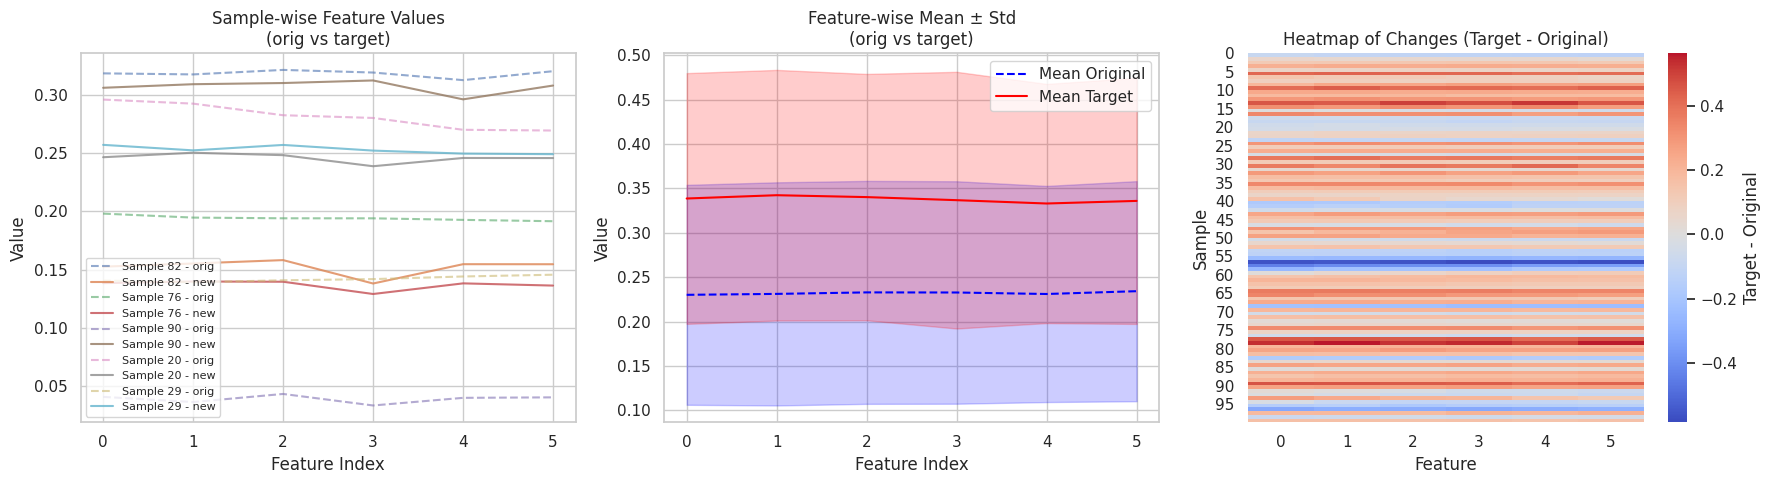

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orig_vs_target(orig_targets, targets, num_samples_to_plot=5):
    orig = np.array(orig_targets)
    new = np.array(targets)
    
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")
    
    num_samples, num_features = orig.shape

    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Line plot for a few random samples
    sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    for idx in sample_indices:
        axs[0].plot(orig[idx], label=f'Sample {idx} - orig', linestyle='--', alpha=0.6)
        axs[0].plot(new[idx], label=f'Sample {idx} - new', linestyle='-', alpha=0.8)
    
    axs[0].set_title("Sample-wise Feature Values\n(orig vs target)")
    axs[0].set_xlabel("Feature Index")
    axs[0].set_ylabel("Value")
    axs[0].legend(fontsize=8)

    # 2. Overlay plot for all samples (mean and std bands)
    mean_orig = orig.mean(axis=0)
    mean_new = new.mean(axis=0)

    axs[1].plot(mean_orig, label="Mean Original", linestyle='--', color='blue')
    axs[1].plot(mean_new, label="Mean Target", linestyle='-', color='red')

    axs[1].fill_between(
        np.arange(num_features),
        mean_orig - orig.std(axis=0),
        mean_orig + orig.std(axis=0),
        color='blue', alpha=0.2
    )
    axs[1].fill_between(
        np.arange(num_features),
        mean_new - new.std(axis=0),
        mean_new + new.std(axis=0),
        color='red', alpha=0.2
    )

    axs[1].set_title("Feature-wise Mean ± Std\n(orig vs target)")
    axs[1].set_xlabel("Feature Index")
    axs[1].set_ylabel("Value")
    axs[1].legend()

    # 3. Heatmap of deltas (orig - new)
    diff = new - orig
    sns.heatmap(diff, cmap="coolwarm", center=0, ax=axs[2], cbar_kws={'label': 'Target - Original'})
    axs[2].set_title("Heatmap of Changes (Target - Original)")
    axs[2].set_xlabel("Feature")
    axs[2].set_ylabel("Sample")

    plt.tight_layout()
    plt.show()



plot_orig_vs_target(opt.orig_targets, opt.targets)


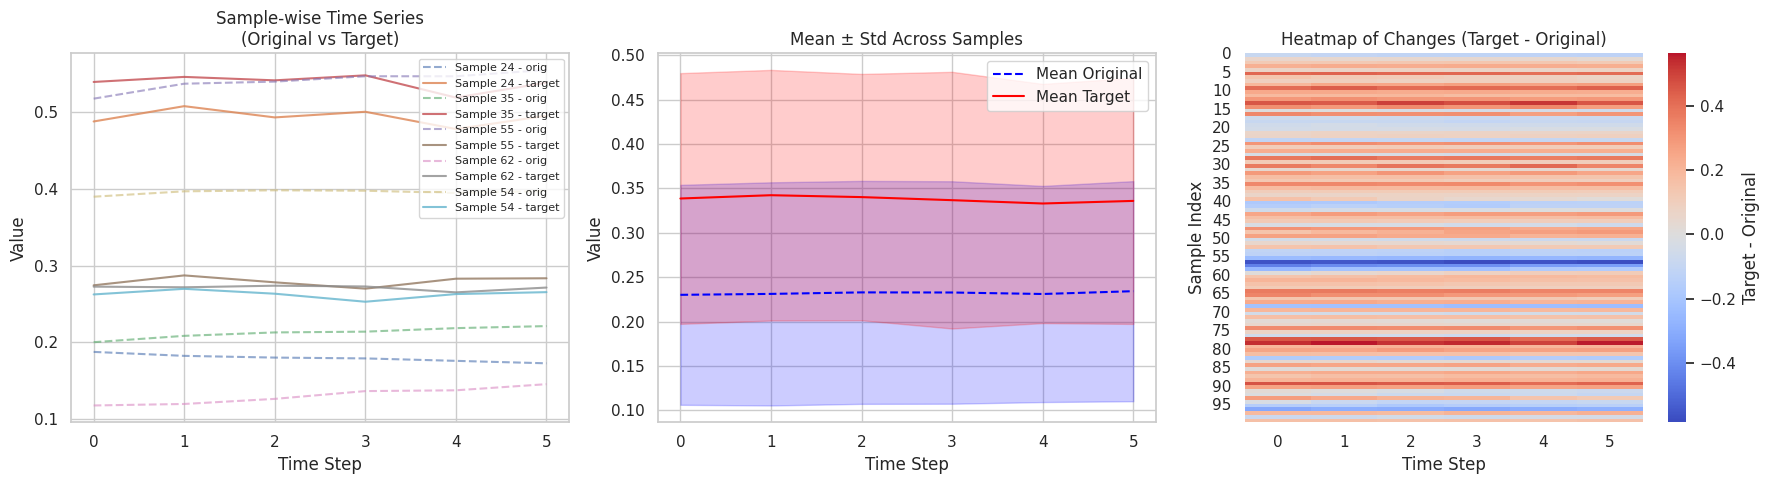

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orig_vs_target_timeseries(orig_targets, targets, num_samples_to_plot=5):
    orig = np.array(orig_targets)
    new = np.array(targets)
    
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    num_samples, num_timesteps = orig.shape

    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Time series plots for a few random samples
    sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    for idx in sample_indices:
        axs[0].plot(orig[idx], label=f'Sample {idx} - orig', linestyle='--', alpha=0.6)
        axs[0].plot(new[idx], label=f'Sample {idx} - target', linestyle='-', alpha=0.8)

    axs[0].set_title("Sample-wise Time Series\n(Original vs Target)")
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Value")
    axs[0].legend(fontsize=8)
    plt.savefig("0_gru.png")

    # 2. Mean ± std band plot across all samples
    mean_orig = orig.mean(axis=0)
    mean_new = new.mean(axis=0)
    std_orig = orig.std(axis=0)
    std_new = new.std(axis=0)

    axs[1].plot(mean_orig, label="Mean Original", linestyle='--', color='blue')
    axs[1].plot(mean_new, label="Mean Target", linestyle='-', color='red')

    axs[1].fill_between(np.arange(num_timesteps), mean_orig - std_orig, mean_orig + std_orig, color='blue', alpha=0.2)
    axs[1].fill_between(np.arange(num_timesteps), mean_new - std_new, mean_new + std_new, color='red', alpha=0.2)

    axs[1].set_title("Mean ± Std Across Samples")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Value")
    axs[1].legend()
    plt.savefig("1_gru.png")

    # 3. Heatmap of differences (target - original) per sample
    diff = new - orig
    sns.heatmap(diff, cmap="coolwarm", center=0, ax=axs[2], cbar_kws={'label': 'Target - Original'})
    axs[2].set_title("Heatmap of Changes (Target - Original)")
    axs[2].set_xlabel("Time Step")
    axs[2].set_ylabel("Sample Index")
    plt.savefig("2_gru.png")

    plt.tight_layout()
    plt.show()


plot_orig_vs_target_timeseries(opt.orig_targets, opt.targets)


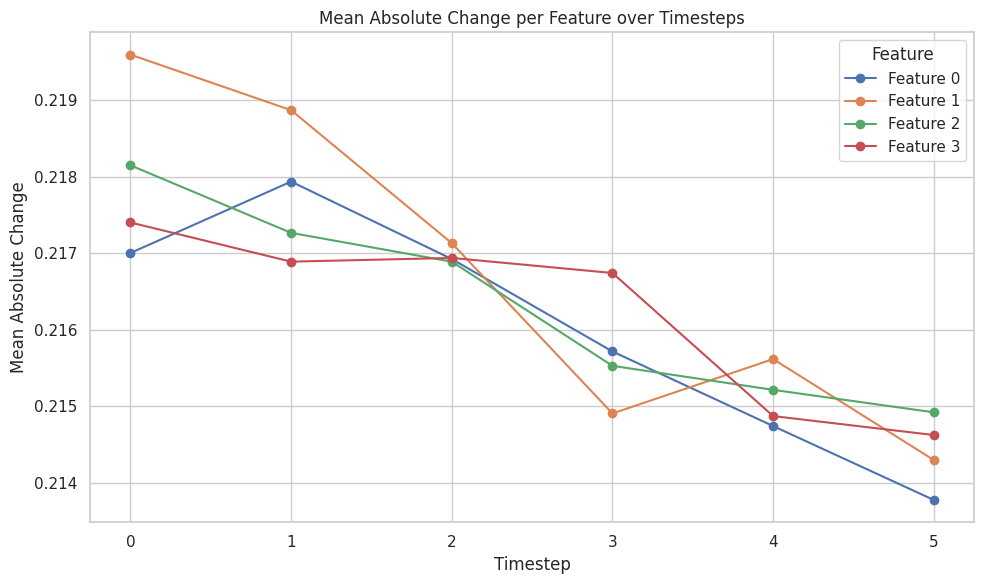

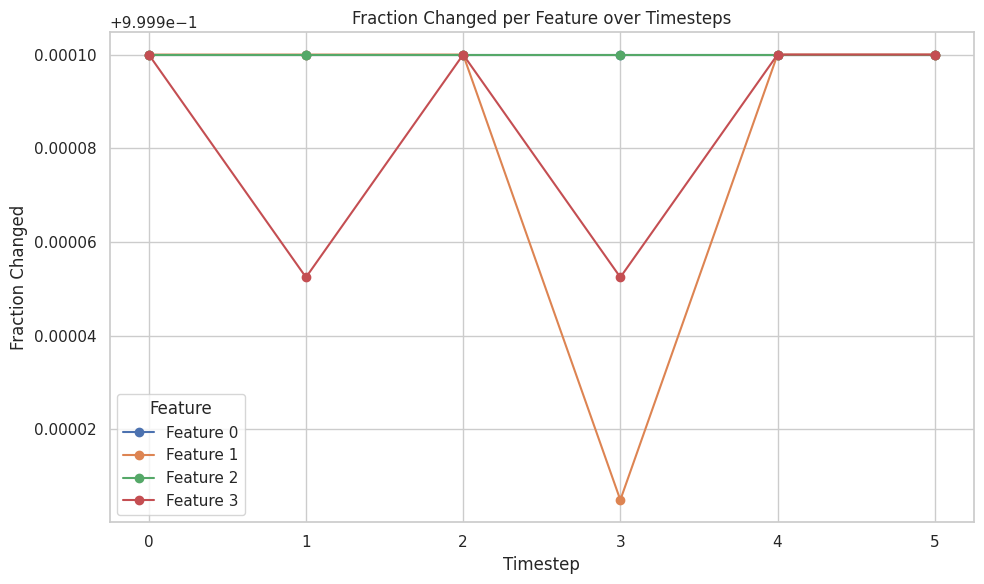

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_changes_over_time(old_array, new_array, stat='mean'):
    old = np.array(old_array)
    new = np.array(new_array)

    if old.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    abs_diff = np.abs(new - old)  # shape: (samples, timesteps, features)

    if stat == 'mean':
        data = abs_diff.mean(axis=0)  # shape: (timesteps, features)
        ylabel = "Mean Absolute Change"
    elif stat == 'std':
        data = abs_diff.std(axis=0)
        ylabel = "Std Dev of Change"
    elif stat == 'fraction':
        data = (abs_diff > 1e-6).mean(axis=0)
        ylabel = "Fraction Changed"
    else:
        raise ValueError("Unsupported stat: choose from 'mean', 'std', 'fraction'")

    timesteps = np.arange(data.shape[0])
    num_features = data.shape[1]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    for i in range(num_features):
        plt.plot(timesteps, data[:, i], marker='o', label=f"Feature {i}")

    plt.title(f"{ylabel} per Feature over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel(ylabel)
    plt.xticks(timesteps)
    plt.legend(title="Feature")
    plt.tight_layout()
    plt.savefig(f"absolute_change_{stat}.png")
    plt.show()


plot_feature_changes_over_time(pred_exog, opt.exogs, stat='mean')
plot_feature_changes_over_time(pred_exog, opt.exogs, stat='fraction')


0
[[0.22424486 0.22628564 0.23563561 0.23504877]
 [0.2188115  0.23257205 0.24109128 0.21920429]
 [0.23713034 0.2313942  0.23428693 0.22456709]
 [0.24318771 0.24072641 0.22433344 0.2342072 ]
 [0.22880353 0.23477714 0.23254861 0.23419075]
 [0.24094905 0.23642576 0.25530806 0.23227124]] [[0.03954629 0.496769   0.19813415 0.16125399]
 [0.03276172 0.6044229  0.1900064  0.24212189]
 [0.18882798 0.36929867 0.14375831 0.4584673 ]
 [0.28504127 0.2640898  0.12101551 0.34265462]
 [0.29894325 0.43321428 0.14235254 0.20991178]
 [0.47906253 0.24161644 0.18483248 0.09577516]]


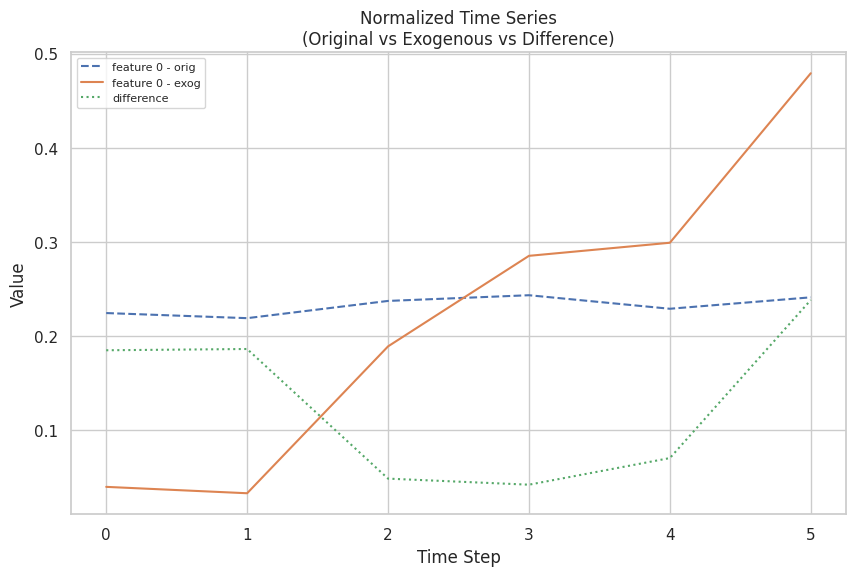

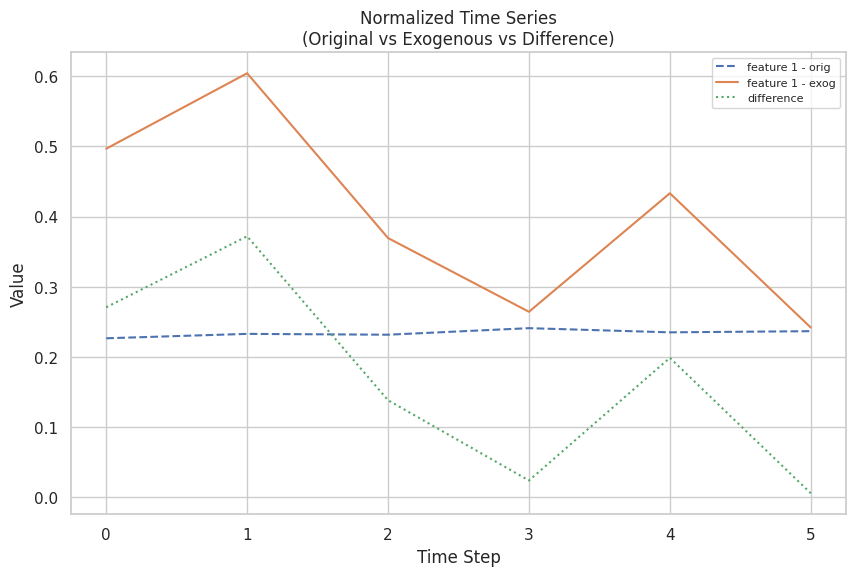

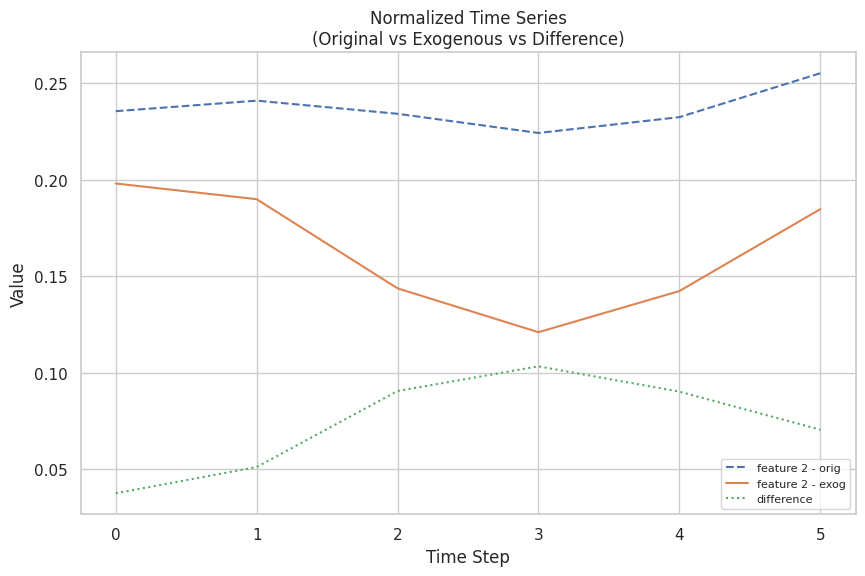

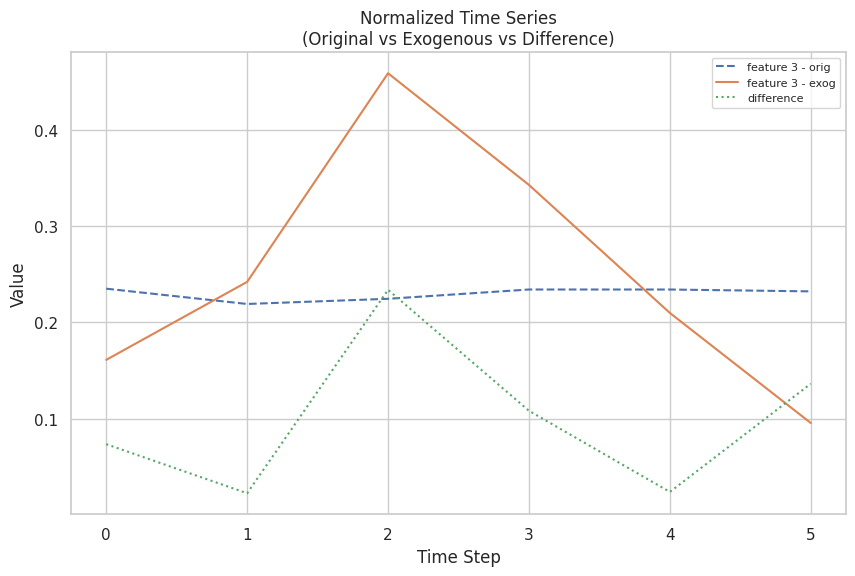

In [167]:
def plot_orig_vs_exogs_timeseries(orig_exogs, exogs, i, num_features):
    orig = np.transpose(np.array(orig_exogs))
    new = np.transpose(np.array(exogs))
    #print("TETETET", orig, new)
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    num_samples, num_timesteps = orig.shape

    sns.set(style="whitegrid")
    #fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i in range(num_features):
        plt.figure(figsize=(10, 6))
    #sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    #for idx in sample_indices:
        diff = abs(orig[i]-new[i])
        #print("TESTNEW", diff, orig[i], new[i])
        plt.plot(orig[i], label=f'feature {i} - orig', linestyle='--')
        plt.plot(new[i], label=f'feature {i} - exog', linestyle='-')
        plt.plot(diff, label=f'difference', linestyle=':')
        plt.title("Normalized Time Series\n(Original vs Exogenous vs Difference)")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend(fontsize=8)
        plt.savefig(f"orig_exog_feature{i}.png")


num_samples_to_plot=1
num_samples, num_timesteps, num_features = pred_exog.shape
sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
for i in range(1):#sample_indices
    print(i)
    print(pred_exog[i], opt.exogs[i])
    plot_orig_vs_exogs_timeseries(pred_exog[i], opt.exogs[i], i, num_features)

1 [[0.03954629 0.496769   0.19813415 0.16125399]
 [0.03276172 0.6044229  0.1900064  0.24212189]
 [0.18882798 0.36929867 0.14375831 0.4584673 ]
 [0.28504127 0.2640898  0.12101551 0.34265462]
 [0.29894325 0.43321428 0.14235254 0.20991178]
 [0.47906253 0.24161644 0.18483248 0.09577516]] [[0.22424486 0.22628564 0.23563561 0.23504877]
 [0.2188115  0.23257205 0.24109128 0.21920429]
 [0.23713034 0.2313942  0.23428693 0.22456709]
 [0.24318771 0.24072641 0.22433344 0.2342072 ]
 [0.22880353 0.23477714 0.23254861 0.23419075]
 [0.24094905 0.23642576 0.25530806 0.23227124]]
DIFF [0.07379478 0.0229176  0.23390022 0.10844742 0.02427897 0.13649608]
DIFF [0.05502234 0.03196548 0.14910567 0.26315948 0.01697791 0.19638856]
DIFF [0.08046876 0.05550937 0.01732145 0.18442291 0.05894296 0.15826863]


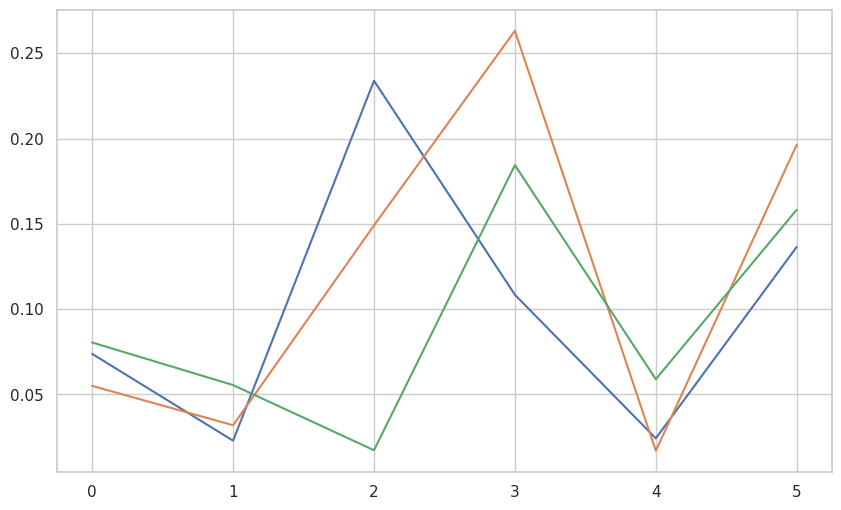

In [145]:
#AVERAGE
def get_average_difference(pred, orig):
    for i in range(pred.shape[1]):
        a_pred = [x[i] for x in pred]
        a_orig = [x[i] for x in orig]
    difference=(abs(np.array(a_pred)-np.array(a_orig)))
    print("DIFF",difference)
    return difference
    

def get_average_of_instance(pred, orig):
    avg_pred, avg_orig, difference = [],[],[]
    for i in range(pred.shape[1]):
        a_pred = [x[i] for x in pred]
        a_orig = [x[i] for x in orig]
        avg_pred.append(np.average(a_pred))
        avg_orig.append(np.average(a_orig))
    return avg_pred, avg_orig

print("1",opt.exogs[0],pred_exog[0])
all_diff = []
for i in range(len(pred_exog)):
    if i < 3:
        #print(opt.exogs[i],pred_exog[i])
    #    results = get_average_of_instance(opt.exogs[i], pred_exog[i])
    #    print(results)
        all_diff.append(get_average_difference(opt.exogs[i], pred_exog[i]))

all_diff = np.transpose(all_diff)

plt.figure(figsize=(10, 6))

plt.plot(all_diff, label='test', linestyle='-')
    

In [135]:
def calc_euclidean(predic, actual):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(predic, actual):
    return np.mean(np.abs((actual - predic) / actual))

def calc_correlation(predic, actual):
    a_diff = actual - np.mean(actual)
    p_diff = predic - np.mean(predic)
    numerator = np.sum(a_diff * p_diff)
    denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
    return numerator / denominator


for i in range(len(pred_exog)):
    if i <3:
        euclidean = calc_euclidean(opt.exogs[i], pred_exog[i])
        mape = calc_mape(opt.exogs[i], pred_exog[i])
        correlation = calc_correlation(opt.exogs[i], pred_exog[i])
        print(euclidean, mape, correlation)

0.729714 0.50813377 0.081727624
1.1836964 0.78292626 -0.26152593
1.0830171 0.8815405 -0.3713419


In [136]:
from sklearn.metrics import r2_score



for i in range(len(pred_exog)):
    if i <3:
        r2 = r2_score(opt.exogs[i], pred_exog[i])
        print(r2)

-1.9969663426418727
-22.47973795304156
-8.449809120697052
